# Measuring all 5 protocols and 4 player sizes (720p+) (quality auto) on the test VM -- 1 video only

In [2]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import math
import Cdf
import Pmf
mpl.rcParams['figure.dpi'] = 200
okabe_ito = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
sns.set_context('paper')
sns.set_palette(sns.color_palette(okabe_ito))
#https://stackoverflow.com/a/45846841
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
def make_cdf(series):
    return series.value_counts(normalize=True).sort_index().cumsum()
def make_pdf(series):
    return series.value_counts(normalize=True).sort_index()

In [350]:
conn = sqlite3.connect('../web-performance/web-performance-youtube-single-vm-5-proto.db')
measurements = pd.read_sql_query("SELECT * FROM measurements", conn)
measurements
#conn.close()

msm_id              py_time       js_time  \
0     e5f5130a-84cb-c651-f453-00b705527bbe  1645468238183222636  1.645468e+12   
1     8c5231a9-bc42-28d8-1dba-e0f25b423ca7  1645468273208159312  1.645468e+12   
2     715bcb78-35e4-41aa-d9b7-0384e0529b0d  1645468311162760538  1.645468e+12   
3     c25cd82a-2a61-3909-cafb-f0d8c477bf5b  1645468346352580760  1.645468e+12   
4     29d2303e-194c-8890-0671-5cc5ddb105a9  1645468384332457386  1.645468e+12   
...                                    ...                  ...           ...   
3675  cd22ae6a-4201-0af7-f4e4-f086133db043  1645633331461312178  1.645633e+12   
3676  7855a369-9baf-b339-1bea-4ac34ec48899  1645633369798417825  1.645633e+12   
3677  58fdda2b-fe4d-5e72-c0f2-92db7caff285  1645633405059264932  1.645633e+12   
3678  282aac47-435a-6276-6d77-93c0b2574d2c  1645633444528141955  1.645633e+12   
3679  99dae425-7e1f-8e6a-d6f8-e8a5b354583d  1645633480106872525  1.645633e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
0             1.645468e+12      tls  94.140.14.140  aqz-KE-bpKQ                
1             1.645468e+12      tls  94.140.14.140  aqz-KE-bpKQ                
2             1.645468e+12      tls  94.140.14.140  aqz-KE-bpKQ                
3             1.645468e+12      tls  94.140.14.140  aqz-KE-bpKQ                
4             1.645468e+12      tls  94.140.14.140  aqz-KE-bpKQ                
...                    ...      ...            ...          ...          ...   
3675          1.645633e+12      udp  94.140.14.140  aqz-KE-bpKQ                
3676          1.645633e+12      udp  94.140.14.140  aqz-KE-bpKQ                
3677          1.645633e+12      udp  94.140.14.140  aqz-KE-bpKQ                
3678          1.645633e+12      udp  94.140.14.140  aqz-KE-bpKQ                
3679          1.645633e+12      udp  94.140.14.140  aqz-KE-bpKQ                

                       timestamp suggested_quality  player_width  \
0     2022-02-21 18:30:04.722114              auto          1280   
1     2022-02-21 18:30:39.976429              auto          1280   
2     2022-02-21 18:31:17.708532              auto          1920   
3     2022-02-21 18:31:52.991132              auto          1920   
4     2022-02-21 18:32:30.880862              auto          2560   
...                          ...               ...           ...   
3675  2022-02-23 16:21:38.135530              auto          1920   
3676  2022-02-23 16:22:16.388225              auto          2560   
3677  2022-02-23 16:22:51.603198              auto          2560   
3678  2022-02-23 16:23:31.037030              auto          3840   
3679  2022-02-23 16:24:06.417968              auto          3840   

      player_height  start_time  play_time    video_ids  cacheWarming error  
0               720           0         30  aqz-KE-bpKQ             1        
1               720           0         30  aqz-KE-bpKQ             0        
2              1080           0         30  aqz-KE-bpKQ             1        
3              1080           0         30  aqz-KE-bpKQ             0        
4              1440           0         30  aqz-KE-bpKQ             1        
...             ...         ...        ...          ...           ...   ...  
3675           1080           0         30  aqz-KE-bpKQ             0        
3676           1440           0         30  aqz-KE-bpKQ             1        
3677           1440           0         30  aqz-KE-bpKQ             0        
3678           2160           0         30  aqz-KE-bpKQ             1        
3679           2160           0         30  aqz-KE-bpKQ             0        

[3680 rows x 17 columns]

# data pre-processing

In [351]:
measurements.error.value_counts()

                                                                                        3679
failed switching selenium focus to youtube iframe or monitoring loop ### Message: \n       1
Name: error, dtype: int64

In [352]:
measurements = measurements[measurements.error == '']

remove cache warming runs early to reduce processing later on

In [353]:
measurements = measurements[measurements.cacheWarming == 0]

In [354]:
measurements['player_width'] = measurements['player_width'].astype(str)
measurements['player_height'] = measurements['player_height'].astype(str)
measurements['player_dimensions'] = measurements['player_width']+"x"+measurements['player_height']

In [355]:
measurements['protocol'] = measurements['protocol'].str.upper()

In [356]:
measurements

msm_id              py_time       js_time  \
1     8c5231a9-bc42-28d8-1dba-e0f25b423ca7  1645468273208159312  1.645468e+12   
3     c25cd82a-2a61-3909-cafb-f0d8c477bf5b  1645468346352580760  1.645468e+12   
5     d74843ac-1555-a3c5-d2db-8fda373bf567  1645468419605662461  1.645468e+12   
7     f8d1925d-ed30-5035-7754-a9c06da9ef10  1645468494295011517  1.645468e+12   
9     bc7212a0-3cb7-6003-a118-73152ac4dfc3  1645468568187263088  1.645469e+12   
...                                    ...                  ...           ...   
3671  99fc9fc6-3f6b-8740-faf3-98d4ce752f28  1645633183321389684  1.645633e+12   
3673  db553758-dc83-11f5-f8bc-6fd4a8070134  1645633257781670701  1.645633e+12   
3675  cd22ae6a-4201-0af7-f4e4-f086133db043  1645633331461312178  1.645633e+12   
3677  58fdda2b-fe4d-5e72-c0f2-92db7caff285  1645633405059264932  1.645633e+12   
3679  99dae425-7e1f-8e6a-d6f8-e8a5b354583d  1645633480106872525  1.645633e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
1             1.645468e+12      TLS  94.140.14.140  aqz-KE-bpKQ                
3             1.645468e+12      TLS  94.140.14.140  aqz-KE-bpKQ                
5             1.645468e+12      TLS  94.140.14.140  aqz-KE-bpKQ                
7             1.645468e+12      TLS  94.140.14.140  aqz-KE-bpKQ                
9             1.645469e+12    HTTPS  94.140.14.140  aqz-KE-bpKQ                
...                    ...      ...            ...          ...          ...   
3671          1.645633e+12      TCP  94.140.14.140  aqz-KE-bpKQ                
3673          1.645633e+12      UDP  94.140.14.140  aqz-KE-bpKQ                
3675          1.645633e+12      UDP  94.140.14.140  aqz-KE-bpKQ                
3677          1.645633e+12      UDP  94.140.14.140  aqz-KE-bpKQ                
3679          1.645633e+12      UDP  94.140.14.140  aqz-KE-bpKQ                

                       timestamp suggested_quality player_width player_height  \
1     2022-02-21 18:30:39.976429              auto         1280           720   
3     2022-02-21 18:31:52.991132              auto         1920          1080   
5     2022-02-21 18:33:06.320152              auto         2560          1440   
7     2022-02-21 18:34:20.893513              auto         3840          2160   
9     2022-02-21 18:35:34.789859              auto         1280           720   
...                          ...               ...          ...           ...   
3671  2022-02-23 16:19:09.456951              auto         3840          2160   
3673  2022-02-23 16:20:24.465181              auto         1280           720   
3675  2022-02-23 16:21:38.135530              auto         1920          1080   
3677  2022-02-23 16:22:51.603198              auto         2560          1440   
3679  2022-02-23 16:24:06.417968              auto         3840          2160   

      start_time  play_time    video_ids  cacheWarming error player_dimensions  
1              0         30  aqz-KE-bpKQ             0                1280x720  
3              0         30  aqz-KE-bpKQ             0               1920x1080  
5              0         30  aqz-KE-bpKQ             0               2560x1440  
7              0         30  aqz-KE-bpKQ             0               3840x2160  
9              0         30  aqz-KE-bpKQ             0                1280x720  
...          ...        ...          ...           ...   ...               ...  
3671           0         30  aqz-KE-bpKQ             0               3840x2160  
3673           0         30  aqz-KE-bpKQ             0                1280x720  
3675           0         30  aqz-KE-bpKQ             0               1920x1080  
3677           0         30  aqz-KE-bpKQ             0               2560x1440  
3679           0         30  aqz-KE-bpKQ             0               3840x2160  

[1839 rows x 18 columns]

## find the optimal resolution as determined by the youtube player for each run

In [357]:
df_optimal_resolutions = pd.read_sql_query("""
SELECT msm_id, resolution, time FROM nerd_stats
""", conn)

In [358]:
df_optimal_resolutions['current_res'] = df_optimal_resolutions['resolution'].str.split(' / ').str[0]
df_optimal_resolutions['current_res'] = df_optimal_resolutions['current_res'].str.split('@').str[0]
df_optimal_resolutions['optimal_res'] = df_optimal_resolutions['resolution'].str.split(' / ').str[1]
df_optimal_resolutions['optimal_res'] = df_optimal_resolutions['optimal_res'].str.split('@').str[0]
df_optimal_resolutions['time'] = pd.to_datetime(df_optimal_resolutions['time'], unit='ms', origin='unix')

In [359]:
df_optimal_resolutions = df_optimal_resolutions[['msm_id','optimal_res', 'time', 'current_res']]

In [360]:
df_optimal_resolutions.groupby('msm_id').optimal_res.nunique().sort_values()

msm_id
00177241-b3ce-48bc-f02a-bdd0f9ad04bb    1
ab49a123-460c-63d7-ad1c-f7dca498c1e3    1
ab5c4a35-ea07-9b65-d0c7-648a772e92cc    1
ab5d19c5-6c84-d9b9-dc3b-4387261b965b    1
ab5e8868-dd91-f953-b244-782742f6d3a7    1
                                       ..
491aa013-5323-1fab-7ac7-69f8fd3d8760    2
58ec003e-3c48-4b1d-9ee8-0bc2def94ae2    2
d947ce75-a2cb-05b8-7be7-b917cb0d0a24    2
ba581ef5-c9a1-39f0-8d13-39091bfbfae9    2
9377e896-b27e-ecd7-0171-e6f36be579d1    2
Name: optimal_res, Length: 3679, dtype: int64

### filter out measurements where the player changes the optimal resolution within the run (mostly from 4k to 1440p)

In [361]:
s_filter_msm = df_optimal_resolutions.groupby('msm_id').optimal_res.nunique()

In [362]:
s_filter_msm[s_filter_msm > 1].index.tolist()

['40506e66-0285-2d47-8142-e07d60e12065',
 '491aa013-5323-1fab-7ac7-69f8fd3d8760',
 '58ec003e-3c48-4b1d-9ee8-0bc2def94ae2',
 '5c56630d-ba70-1f4b-84af-ed480416bb88',
 '9377e896-b27e-ecd7-0171-e6f36be579d1',
 'ba581ef5-c9a1-39f0-8d13-39091bfbfae9',
 'd947ce75-a2cb-05b8-7be7-b917cb0d0a24']

In [363]:
df_optimal_resolutions[df_optimal_resolutions.msm_id.isin(s_filter_msm[s_filter_msm > 1].index.tolist())].sort_values('time').groupby(['msm_id', 'optimal_res']).agg({'time':'min'}).sort_values('time')

time
msm_id                               optimal_res                              
9377e896-b27e-ecd7-0171-e6f36be579d1 3840x2160   2022-02-21 20:49:16.884100096
                                     2560x1440   2022-02-21 20:49:34.595300096
40506e66-0285-2d47-8142-e07d60e12065 3840x2160   2022-02-21 23:19:10.119800064
                                     2560x1440   2022-02-21 23:19:40.011599872
5c56630d-ba70-1f4b-84af-ed480416bb88 3840x2160   2022-02-22 06:13:38.568499968
                                     2560x1440   2022-02-22 06:14:04.034800128
491aa013-5323-1fab-7ac7-69f8fd3d8760 3840x2160   2022-02-22 11:38:44.539200000
                                     2560x1440   2022-02-22 11:39:04.265099776
ba581ef5-c9a1-39f0-8d13-39091bfbfae9 3840x2160   2022-02-22 11:49:09.017999872
                                     2560x1440   2022-02-22 11:49:26.622700032
d947ce75-a2cb-05b8-7be7-b917cb0d0a24 3840x2160   2022-02-23 00:38:44.534500096
                                     2560x1440   2022-02-23 00:39:04.747899904
58ec003e-3c48-4b1d-9ee8-0bc2def94ae2 3840x2160   2022-02-23 16:13:41.016000000
                                     2560x1440   2022-02-23 16:14:01.195200256

first idea: we take the nerd stats optimal res at the end of playback (i.e. the furthest in terms of video playback) as the "true" optimal res  ------ probably dumb idea, see example above, for now just filter out the ones with multiple optimal resolutions?

In [364]:
#assert set(df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].msm_id.value_counts().values) == {1}
#assert df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].msm_id.nunique() == measurements.msm_id.nunique()
#df_optimal_resolutions = df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].reset_index(drop=True)


In [365]:
df_msms_with_multiple_opt_res = df_optimal_resolutions.groupby('msm_id', as_index=False).agg(opt_res_num=('optimal_res',pd.Series.nunique), opt_res_list=('optimal_res',pd.Series.unique)).sort_values('opt_res_num')

In [366]:
df_msms_with_multiple_opt_res[df_msms_with_multiple_opt_res.opt_res_num > 1]

msm_id  opt_res_num  \
917   40506e66-0285-2d47-8142-e07d60e12065            2   
1303  5c56630d-ba70-1f4b-84af-ed480416bb88            2   
1056  491aa013-5323-1fab-7ac7-69f8fd3d8760            2   
1250  58ec003e-3c48-4b1d-9ee8-0bc2def94ae2            2   
3119  d947ce75-a2cb-05b8-7be7-b917cb0d0a24            2   
2667  ba581ef5-c9a1-39f0-8d13-39091bfbfae9            2   
2100  9377e896-b27e-ecd7-0171-e6f36be579d1            2   

                opt_res_list  
917   [3840x2160, 2560x1440]  
1303  [3840x2160, 2560x1440]  
1056  [3840x2160, 2560x1440]  
1250  [3840x2160, 2560x1440]  
3119  [3840x2160, 2560x1440]  
2667  [3840x2160, 2560x1440]  
2100  [3840x2160, 2560x1440]

In [367]:
measurements_to_remove = df_msms_with_multiple_opt_res[df_msms_with_multiple_opt_res.opt_res_num > 1].msm_id.unique().tolist()

In [368]:
measurements_to_remove

['40506e66-0285-2d47-8142-e07d60e12065',
 '5c56630d-ba70-1f4b-84af-ed480416bb88',
 '491aa013-5323-1fab-7ac7-69f8fd3d8760',
 '58ec003e-3c48-4b1d-9ee8-0bc2def94ae2',
 'd947ce75-a2cb-05b8-7be7-b917cb0d0a24',
 'ba581ef5-c9a1-39f0-8d13-39091bfbfae9',
 '9377e896-b27e-ecd7-0171-e6f36be579d1']

In [369]:
measurements[measurements.msm_id.isin(measurements_to_remove)].player_dimensions.value_counts()

3840x2160    3
Name: player_dimensions, dtype: int64

In [370]:
measurements[measurements.msm_id.isin(measurements_to_remove)].protocol.value_counts()

TCP    3
Name: protocol, dtype: int64

In [371]:
measurements[measurements.player_dimensions == "3840x2160"].protocol.value_counts()

TLS      92
HTTPS    92
UDP      92
QUIC     92
TCP      92
Name: protocol, dtype: int64

In [372]:
measurements = measurements[~measurements.msm_id.isin(measurements_to_remove)]

In [373]:
df_optimal_resolutions = df_optimal_resolutions[~df_optimal_resolutions.msm_id.isin(measurements_to_remove)][['msm_id', 'optimal_res']].drop_duplicates().reset_index().drop('index', axis=1)

In [374]:
df_optimal_resolutions

msm_id optimal_res
0     e5f5130a-84cb-c651-f453-00b705527bbe    1280x720
1     8c5231a9-bc42-28d8-1dba-e0f25b423ca7    1280x720
2     715bcb78-35e4-41aa-d9b7-0384e0529b0d   1920x1080
3     c25cd82a-2a61-3909-cafb-f0d8c477bf5b   1920x1080
4     29d2303e-194c-8890-0671-5cc5ddb105a9   2560x1440
...                                    ...         ...
3667  cd22ae6a-4201-0af7-f4e4-f086133db043   1920x1080
3668  7855a369-9baf-b339-1bea-4ac34ec48899   2560x1440
3669  58fdda2b-fe4d-5e72-c0f2-92db7caff285   2560x1440
3670  282aac47-435a-6276-6d77-93c0b2574d2c   3840x2160
3671  99dae425-7e1f-8e6a-d6f8-e8a5b354583d   3840x2160

[3672 rows x 2 columns]

In [375]:
df_optimal_resolutions = pd.merge(df_optimal_resolutions, measurements[['msm_id', 'player_dimensions']], on='msm_id')
df_optimal_resolutions

msm_id optimal_res player_dimensions
0     8c5231a9-bc42-28d8-1dba-e0f25b423ca7    1280x720          1280x720
1     c25cd82a-2a61-3909-cafb-f0d8c477bf5b   1920x1080         1920x1080
2     d74843ac-1555-a3c5-d2db-8fda373bf567   2560x1440         2560x1440
3     f8d1925d-ed30-5035-7754-a9c06da9ef10   3840x2160         3840x2160
4     bc7212a0-3cb7-6003-a118-73152ac4dfc3    1280x720          1280x720
...                                    ...         ...               ...
1831  99fc9fc6-3f6b-8740-faf3-98d4ce752f28   3840x2160         3840x2160
1832  db553758-dc83-11f5-f8bc-6fd4a8070134    1280x720          1280x720
1833  cd22ae6a-4201-0af7-f4e4-f086133db043   1920x1080         1920x1080
1834  58fdda2b-fe4d-5e72-c0f2-92db7caff285   2560x1440         2560x1440
1835  99dae425-7e1f-8e6a-d6f8-e8a5b354583d   3840x2160         3840x2160

[1836 rows x 3 columns]

### make sure the optimal resolutions match what we set as the player size

In [376]:
df_optimal_resolutions[df_optimal_resolutions.optimal_res != df_optimal_resolutions.player_dimensions]

Empty DataFrame
Columns: [msm_id, optimal_res, player_dimensions]
Index: []

### make sure each run has a start playing event that fired before 1s of playtime passed (there seems to always be a little bit of playtime (i.e. the curr play time when the event fires is never zero) presumably due to the delay from javascript execution between getting the playback time within the callback)

In [377]:
df_player_state_playing = pd.read_sql_query("select time, msm_id, curr_play_time from iframe_api where event_type = 'PlayerStatePLAYING'", conn)

In [378]:
df_player_state_playing[df_player_state_playing.curr_play_time > 1].curr_play_time.describe()

count    2859.000000
mean       19.900307
std         2.329134
min         3.117650
25%        17.943333
50%        19.350333
75%        21.121000
max        28.246888
Name: curr_play_time, dtype: float64

In [379]:
df_player_state_playing[df_player_state_playing.curr_play_time < 1].curr_play_time.describe()

count    3679.000000
mean        0.022281
std         0.012740
min         0.004957
25%         0.016903
50%         0.020605
75%         0.023771
max         0.203876
Name: curr_play_time, dtype: float64

In [380]:
df_player_state_intial_playback = df_player_state_playing[(df_player_state_playing.curr_play_time < 1) & 
                                    (df_player_state_playing.msm_id.isin(measurements.msm_id.unique()))]

make sure each measurement only has one corresponding initial playing state event and that all measurements have such an event

In [381]:
assert set(df_player_state_intial_playback.msm_id.value_counts().values) == {1}
assert pd.Series.nunique(df_player_state_intial_playback.msm_id.value_counts().index) == \
pd.Series.nunique(measurements['msm_id'])

### if the 1s metric produced a unique start playing state event for each run, we can use it to calculate the startup delay between when we tell the player to start playing and when it actually plays

In [382]:
df_start_time = pd.read_sql_query("""
SELECT start_time, play_time, msm_id, current_quality AS initial_quality FROM
(SELECT time AS start_time, msm_id FROM iframe_api WHERE event_type = 'PlayStartedFromFunction')
JOIN
(SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time < 1)
USING (msm_id);
""", conn)
df_start_time = df_start_time[df_start_time.msm_id.isin(measurements.msm_id.unique())]

df_start_time['start_time'] = pd.to_datetime(df_start_time['start_time'], unit='ms', origin='unix')
df_start_time['play_time'] = pd.to_datetime(df_start_time['play_time'], unit='ms', origin='unix')

df_start_time['startup_delay'] = (df_start_time['play_time'] - df_start_time['start_time']).dt.total_seconds()

In [383]:
df_start_time

start_time                     play_time  \
1    2022-02-21 18:30:42.292100096 2022-02-21 18:30:42.688600064   
3    2022-02-21 18:31:55.329699840 2022-02-21 18:31:55.718899968   
5    2022-02-21 18:33:08.666700032 2022-02-21 18:33:09.061799936   
7    2022-02-21 18:34:23.242800128 2022-02-21 18:34:23.732999936   
9    2022-02-21 18:35:37.206300160 2022-02-21 18:35:37.607599872   
...                            ...                           ...   
3670 2022-02-23 16:19:12.234300160 2022-02-23 16:19:12.642100224   
3672 2022-02-23 16:20:26.868499968 2022-02-23 16:20:27.271600128   
3674 2022-02-23 16:21:40.475000064 2022-02-23 16:21:40.865900032   
3676 2022-02-23 16:22:54.032700160 2022-02-23 16:22:54.424999936   
3678 2022-02-23 16:24:08.868900096 2022-02-23 16:24:09.259400192   

                                    msm_id initial_quality  startup_delay  
1     8c5231a9-bc42-28d8-1dba-e0f25b423ca7           hd720         0.3965  
3     c25cd82a-2a61-3909-cafb-f0d8c477bf5b          hd1080         0.3892  
5     d74843ac-1555-a3c5-d2db-8fda373bf567          hd1440         0.3951  
7     f8d1925d-ed30-5035-7754-a9c06da9ef10          hd2160         0.4902  
9     bc7212a0-3cb7-6003-a118-73152ac4dfc3           hd720         0.4013  
...                                    ...             ...            ...  
3670  99fc9fc6-3f6b-8740-faf3-98d4ce752f28          hd2160         0.4078  
3672  db553758-dc83-11f5-f8bc-6fd4a8070134           hd720         0.4031  
3674  cd22ae6a-4201-0af7-f4e4-f086133db043          hd1080         0.3909  
3676  58fdda2b-fe4d-5e72-c0f2-92db7caff285          hd1440         0.3923  
3678  99dae425-7e1f-8e6a-d6f8-e8a5b354583d          hd2160         0.3905  

[1836 rows x 5 columns]

### for each measurement we call getQuality when the player fires the start playing callback, however this seems to again be susceptible to some delay, some measurements have quality change events for that resolution fire __after__ the recorded timestamp for the playing event ---> thus we figure out the quality change event that happened closest to the timestamp of the start playing event but still happened before it

In [384]:
df_player_quality_change_event = pd.read_sql_query("select msm_id, time, curr_play_time, current_quality from iframe_api where event_type LIKE 'QualityChange%'", conn)
df_player_quality_change_event = df_player_quality_change_event[df_player_quality_change_event.msm_id.isin(measurements.msm_id.unique())]

In [385]:
df_player_quality_change_event['time'] = pd.to_datetime(df_player_quality_change_event['time'], unit='ms', origin='unix')

In [386]:
df_player_quality_change_event.curr_play_time.value_counts().sort_index()

0.000000     3638
0.020292        1
0.020352        1
0.021482        1
0.021591        1
             ... 
27.618637       1
27.650117       1
27.674918       1
27.740415       1
27.866526       1
Name: curr_play_time, Length: 286, dtype: int64

In [387]:
df_player_quality_change_event[df_player_quality_change_event.curr_play_time == 0].msm_id.value_counts()

41e65018-f369-2869-7658-4e29451b314a    3
d1a87a5d-fea4-c0ee-bcfd-c7ec974dae82    3
e7f38dfc-0a29-706e-cd0e-a34aef4363bb    2
5f496f04-bbc0-07b7-4ea5-e24dc4770b00    2
4bef281d-9f77-5d21-7060-a81330760e56    2
                                       ..
fc5dccab-f666-9834-8ae1-597527f4b374    1
c023b64b-fa8b-c921-8420-d569bf166fd4    1
a7f925e8-9e2d-5442-1b80-b7d26b446aef    1
069cc40b-5558-292f-dbbe-ff385490a050    1
43ea6595-26eb-6a5e-03ac-a367ea5b31dd    1
Name: msm_id, Length: 1836, dtype: int64

In [388]:
df_player_quality_change_event[df_player_quality_change_event.msm_id == "41e65018-f369-2869-7658-4e29451b314a"]

msm_id                          time  \
4355  41e65018-f369-2869-7658-4e29451b314a 2022-02-22 19:47:57.994099968   
4356  41e65018-f369-2869-7658-4e29451b314a 2022-02-22 19:47:58.090500096   
4357  41e65018-f369-2869-7658-4e29451b314a 2022-02-22 19:47:58.229199872   

      curr_play_time current_quality  
4355             0.0          medium  
4356             0.0          hd1080  
4357             0.0          hd1440

In [389]:
measurements[measurements.msm_id == "41e65018-f369-2869-7658-4e29451b314a"]

msm_id              py_time       js_time  \
2029  41e65018-f369-2869-7658-4e29451b314a  1645559308868757683  1.645559e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
2029          1.645559e+12      TCP  94.140.14.140  aqz-KE-bpKQ                

                       timestamp suggested_quality player_width player_height  \
2029  2022-02-22 19:47:55.463169              auto         2560          1440   

      start_time  play_time    video_ids  cacheWarming error player_dimensions  
2029           0         30  aqz-KE-bpKQ             0               2560x1440

In [390]:
df_start_time[df_start_time.msm_id == "41e65018-f369-2869-7658-4e29451b314a"]

start_time                     play_time  \
2029 2022-02-22 19:47:57.773899776 2022-02-22 19:47:58.288799744   

                                    msm_id initial_quality  startup_delay  
2029  41e65018-f369-2869-7658-4e29451b314a          hd1440         0.5149

In [391]:
df_true_initial_quality = pd.merge(df_start_time[['msm_id', 'play_time', 'initial_quality']], df_player_quality_change_event[df_player_quality_change_event.curr_play_time < 1][['time', 'current_quality', 'msm_id']], on='msm_id')


In [392]:
df_true_initial_quality['delay_to_play_time'] = (df_true_initial_quality['play_time'] - df_true_initial_quality['time']).dt.total_seconds()

In [393]:
df_true_initial_quality[df_true_initial_quality.msm_id == "41e65018-f369-2869-7658-4e29451b314a"]

msm_id                     play_time  \
2053  41e65018-f369-2869-7658-4e29451b314a 2022-02-22 19:47:58.288799744   
2054  41e65018-f369-2869-7658-4e29451b314a 2022-02-22 19:47:58.288799744   
2055  41e65018-f369-2869-7658-4e29451b314a 2022-02-22 19:47:58.288799744   

     initial_quality                          time current_quality  \
2053          hd1440 2022-02-22 19:47:57.994099968          medium   
2054          hd1440 2022-02-22 19:47:58.090500096          hd1080   
2055          hd1440 2022-02-22 19:47:58.229199872          hd1440   

      delay_to_play_time  
2053              0.2947  
2054              0.1983  
2055              0.0596

In [394]:
df_true_initial_quality = df_true_initial_quality[df_true_initial_quality.delay_to_play_time > 0]

In [395]:
df_true_initial_quality = df_true_initial_quality.loc[df_true_initial_quality.groupby('msm_id').delay_to_play_time.idxmin()].reset_index(drop=True)

In [396]:
df_true_initial_quality[df_true_initial_quality.initial_quality != df_true_initial_quality.current_quality]

msm_id                     play_time  \
46    069cc40b-5558-292f-dbbe-ff385490a050 2022-02-23 01:43:01.096599808   
95    0d064b24-1dc0-bcef-e3b3-b88e9c52ff8e 2022-02-22 20:30:42.965799680   
561   4d11c43c-b285-1a99-88e6-5e14af3e69bf 2022-02-22 12:45:25.146200064   
651   5b825975-179a-5237-72e9-402e771b4746 2022-02-23 11:00:43.120300032   
1064  967a72ed-20ce-4cb5-45f8-719e7636fa5d 2022-02-22 18:14:16.187000064   
1111  9c45cbdd-081f-ee23-78e3-db3ed1852090 2022-02-22 19:01:56.153399808   
1255  b0186976-ba67-6fd6-72c6-202c6ca9f227 2022-02-23 05:47:55.517200128   
1371  c023b64b-fa8b-c921-8420-d569bf166fd4 2022-02-23 05:49:09.069499904   
1533  d73665d4-0fb1-b7da-a218-6016e229c4aa 2022-02-22 10:44:13.367599872   
1549  d8d509fe-33f7-953b-7cfa-341d0f0ef548 2022-02-21 21:50:24.768099840   
1833  fff214a2-aa9e-849d-257d-0fef31523c59 2022-02-23 12:43:02.072499968   

     initial_quality                          time current_quality  \
46            hd1440 2022-02-23 01:43:00.924800000          medium   
95             hd720 2022-02-22 20:30:42.617899776          medium   
561            hd720 2022-02-22 12:45:25.026300160          medium   
651            hd720 2022-02-23 11:00:43.005099776          medium   
1064          hd2160 2022-02-22 18:14:16.069299712          medium   
1111          hd1080 2022-02-22 19:01:55.988100096          medium   
1255          hd1440 2022-02-23 05:47:55.335900160          medium   
1371          hd2160 2022-02-23 05:49:08.975899904          medium   
1533          hd1440 2022-02-22 10:44:13.262099968          medium   
1549           hd720 2022-02-21 21:50:24.626500096          medium   
1833          hd1440 2022-02-23 12:43:01.792899840          medium   

      delay_to_play_time  
46                0.1718  
95                0.3479  
561               0.1199  
651               0.1152  
1064              0.1177  
1111              0.1653  
1255              0.1813  
1371              0.0936  
1533              0.1055  
1549              0.1416  
1833              0.2796

In [397]:
df_true_initial_quality.rename(columns=lambda x: x.replace('current_quality', 'true_initial_quality'), inplace=True)

In [398]:
df_true_initial_quality

msm_id                     play_time  \
0     00753b37-0262-91d7-a915-087ae3d4d72f 2022-02-23 11:13:02.739899904   
1     00863967-9e6e-6960-9295-86e7adead4ac 2022-02-23 05:10:33.070500096   
2     008efbfb-be1f-394b-0bc2-df624557c686 2022-02-23 13:15:29.762800128   
3     00913f69-9dc1-0b77-8530-2b3e0ed6e490 2022-02-23 15:39:21.996800000   
4     00c0df40-316d-2dea-0057-673134024619 2022-02-23 06:43:01.150200064   
...                                    ...                           ...   
1831  ffc3eec5-1e48-b565-8661-7373e8c4a5ce 2022-02-23 14:47:56.300400128   
1832  ffe7edb0-ff10-bec3-07a7-e1bef8c62c82 2022-02-23 02:06:53.185600000   
1833  fff214a2-aa9e-849d-257d-0fef31523c59 2022-02-23 12:43:02.072499968   
1834  fff93290-8a90-ada1-b96e-e8c6c2893f86 2022-02-22 23:22:49.362800128   
1835  fffda141-c88d-af5f-148d-6fccde7900e3 2022-02-22 22:34:22.939400192   

     initial_quality                          time true_initial_quality  \
0             hd1440 2022-02-23 11:13:02.708000000               hd1440   
1              hd720 2022-02-23 05:10:32.973899776                hd720   
2              hd720 2022-02-23 13:15:29.672399872                hd720   
3             hd2160 2022-02-23 15:39:21.943500032               hd2160   
4             hd1440 2022-02-23 06:43:01.070700032               hd1440   
...              ...                           ...                  ...   
1831          hd1440 2022-02-23 14:47:56.175699968               hd1440   
1832          hd1080 2022-02-23 02:06:53.136999936               hd1080   
1833          hd1440 2022-02-23 12:43:01.792899840               medium   
1834          hd1440 2022-02-22 23:22:49.350400256               hd1440   
1835          hd2160 2022-02-22 22:34:22.860699904               hd2160   

      delay_to_play_time  
0                 0.0319  
1                 0.0966  
2                 0.0904  
3                 0.0533  
4                 0.0795  
...                  ...  
1831              0.1247  
1832              0.0486  
1833              0.2796  
1834              0.0124  
1835              0.0787  

[1836 rows x 6 columns]

### helper functions

In [399]:
res_to_quality = {
    "256x144":"tiny", "426x240": "small", "640x360": "medium", "854x480": "large",
    "1280x720": "hd720", "1920x1080": "hd1080", "2560x1440": "hd1440", "3840x2160": "hd2160"
}

quality_to_res = {v: k for k, v in res_to_quality.items()}

def map_quality_to_res(quality):
    return quality_to_res[quality]
def map_res_to_quality(resolution):
    return res_to_quality[resolution]

def make_quality_column_sortable(df_, col_name_):
    df_[col_name_] = pd.Categorical(df_[col_name_], ['auto', 'tiny', 'small', 'medium', 'large', 'hd720', 'hd1080', 'highres', 'hd1440', 'hd2160'])

def make_res_column_sortable(df_, col_name_):
    df_[col_name_] = pd.Categorical(df_[col_name_], ['256x144', '426x240', '640x360', '854x480', '1280x720', '1920x1080', '2560x1440', '3840x2160'])

In [400]:
df_resource_timing = pd.read_sql_query("SELECT msm_id, name FROM page_resources", conn)
#df_resource_timing = df_resource_timing[df_resource_timing.msm_id.isin(measurements.msm_id.unique())]

In [401]:
df_resource_timing['googlevideo'] = df_resource_timing.name.str.split('/').str[2]

In [402]:
df_resource_timing.googlevideo.unique()

array(['rr2---sn-4g5ednly.googlevideo.com',
       'rr2---sn-4g5lzner.googlevideo.com',
       'rr1---sn-1gieen7e.googlevideo.com',
       'rr2---sn-5hne6nsr.googlevideo.com'], dtype=object)

In [403]:
df_resource_timing.msm_id.nunique()

3679

In [404]:
df_resource_timing = pd.merge(df_resource_timing, pd.read_sql_query("SELECT msm_id, cacheWarming, (player_width || 'x' || player_height) as player_dimensions FROM measurements", conn))

In [405]:
df_resource_timing.groupby(['player_dimensions', 'googlevideo']).agg({'cacheWarming':lambda x: list(set(x))})

cacheWarming
player_dimensions googlevideo                                   
1280x720          rr2---sn-4g5ednly.googlevideo.com       [0, 1]
                  rr2---sn-4g5lzner.googlevideo.com       [0, 1]
                  rr2---sn-5hne6nsr.googlevideo.com       [0, 1]
1920x1080         rr1---sn-1gieen7e.googlevideo.com       [0, 1]
                  rr2---sn-4g5ednly.googlevideo.com       [0, 1]
                  rr2---sn-4g5lzner.googlevideo.com       [0, 1]
                  rr2---sn-5hne6nsr.googlevideo.com       [0, 1]
2560x1440         rr2---sn-4g5ednly.googlevideo.com       [0, 1]
                  rr2---sn-4g5lzner.googlevideo.com       [0, 1]
                  rr2---sn-5hne6nsr.googlevideo.com       [0, 1]
3840x2160         rr1---sn-1gieen7e.googlevideo.com          [1]
                  rr2---sn-4g5ednly.googlevideo.com       [0, 1]
                  rr2---sn-4g5lzner.googlevideo.com       [0, 1]
                  rr2---sn-5hne6nsr.googlevideo.com          [0]

In [406]:
#df_start_time = df_start_time[~df_start_time.msm_id.isin(measurements_to_remove)]
df_start_time

start_time                     play_time  \
1    2022-02-21 18:30:42.292100096 2022-02-21 18:30:42.688600064   
3    2022-02-21 18:31:55.329699840 2022-02-21 18:31:55.718899968   
5    2022-02-21 18:33:08.666700032 2022-02-21 18:33:09.061799936   
7    2022-02-21 18:34:23.242800128 2022-02-21 18:34:23.732999936   
9    2022-02-21 18:35:37.206300160 2022-02-21 18:35:37.607599872   
...                            ...                           ...   
3670 2022-02-23 16:19:12.234300160 2022-02-23 16:19:12.642100224   
3672 2022-02-23 16:20:26.868499968 2022-02-23 16:20:27.271600128   
3674 2022-02-23 16:21:40.475000064 2022-02-23 16:21:40.865900032   
3676 2022-02-23 16:22:54.032700160 2022-02-23 16:22:54.424999936   
3678 2022-02-23 16:24:08.868900096 2022-02-23 16:24:09.259400192   

                                    msm_id initial_quality  startup_delay  
1     8c5231a9-bc42-28d8-1dba-e0f25b423ca7           hd720         0.3965  
3     c25cd82a-2a61-3909-cafb-f0d8c477bf5b          hd1080         0.3892  
5     d74843ac-1555-a3c5-d2db-8fda373bf567          hd1440         0.3951  
7     f8d1925d-ed30-5035-7754-a9c06da9ef10          hd2160         0.4902  
9     bc7212a0-3cb7-6003-a118-73152ac4dfc3           hd720         0.4013  
...                                    ...             ...            ...  
3670  99fc9fc6-3f6b-8740-faf3-98d4ce752f28          hd2160         0.4078  
3672  db553758-dc83-11f5-f8bc-6fd4a8070134           hd720         0.4031  
3674  cd22ae6a-4201-0af7-f4e4-f086133db043          hd1080         0.3909  
3676  58fdda2b-fe4d-5e72-c0f2-92db7caff285          hd1440         0.3923  
3678  99dae425-7e1f-8e6a-d6f8-e8a5b354583d          hd2160         0.3905  

[1836 rows x 5 columns]

In [407]:
measurements

msm_id              py_time       js_time  \
1     8c5231a9-bc42-28d8-1dba-e0f25b423ca7  1645468273208159312  1.645468e+12   
3     c25cd82a-2a61-3909-cafb-f0d8c477bf5b  1645468346352580760  1.645468e+12   
5     d74843ac-1555-a3c5-d2db-8fda373bf567  1645468419605662461  1.645468e+12   
7     f8d1925d-ed30-5035-7754-a9c06da9ef10  1645468494295011517  1.645468e+12   
9     bc7212a0-3cb7-6003-a118-73152ac4dfc3  1645468568187263088  1.645469e+12   
...                                    ...                  ...           ...   
3671  99fc9fc6-3f6b-8740-faf3-98d4ce752f28  1645633183321389684  1.645633e+12   
3673  db553758-dc83-11f5-f8bc-6fd4a8070134  1645633257781670701  1.645633e+12   
3675  cd22ae6a-4201-0af7-f4e4-f086133db043  1645633331461312178  1.645633e+12   
3677  58fdda2b-fe4d-5e72-c0f2-92db7caff285  1645633405059264932  1.645633e+12   
3679  99dae425-7e1f-8e6a-d6f8-e8a5b354583d  1645633480106872525  1.645633e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
1             1.645468e+12      TLS  94.140.14.140  aqz-KE-bpKQ                
3             1.645468e+12      TLS  94.140.14.140  aqz-KE-bpKQ                
5             1.645468e+12      TLS  94.140.14.140  aqz-KE-bpKQ                
7             1.645468e+12      TLS  94.140.14.140  aqz-KE-bpKQ                
9             1.645469e+12    HTTPS  94.140.14.140  aqz-KE-bpKQ                
...                    ...      ...            ...          ...          ...   
3671          1.645633e+12      TCP  94.140.14.140  aqz-KE-bpKQ                
3673          1.645633e+12      UDP  94.140.14.140  aqz-KE-bpKQ                
3675          1.645633e+12      UDP  94.140.14.140  aqz-KE-bpKQ                
3677          1.645633e+12      UDP  94.140.14.140  aqz-KE-bpKQ                
3679          1.645633e+12      UDP  94.140.14.140  aqz-KE-bpKQ                

                       timestamp suggested_quality player_width player_height  \
1     2022-02-21 18:30:39.976429              auto         1280           720   
3     2022-02-21 18:31:52.991132              auto         1920          1080   
5     2022-02-21 18:33:06.320152              auto         2560          1440   
7     2022-02-21 18:34:20.893513              auto         3840          2160   
9     2022-02-21 18:35:34.789859              auto         1280           720   
...                          ...               ...          ...           ...   
3671  2022-02-23 16:19:09.456951              auto         3840          2160   
3673  2022-02-23 16:20:24.465181              auto         1280           720   
3675  2022-02-23 16:21:38.135530              auto         1920          1080   
3677  2022-02-23 16:22:51.603198              auto         2560          1440   
3679  2022-02-23 16:24:06.417968              auto         3840          2160   

      start_time  play_time    video_ids  cacheWarming error player_dimensions  
1              0         30  aqz-KE-bpKQ             0                1280x720  
3              0         30  aqz-KE-bpKQ             0               1920x1080  
5              0         30  aqz-KE-bpKQ             0               2560x1440  
7              0         30  aqz-KE-bpKQ             0               3840x2160  
9              0         30  aqz-KE-bpKQ             0                1280x720  
...          ...        ...          ...           ...   ...               ...  
3671           0         30  aqz-KE-bpKQ             0               3840x2160  
3673           0         30  aqz-KE-bpKQ             0                1280x720  
3675           0         30  aqz-KE-bpKQ             0               1920x1080  
3677           0         30  aqz-KE-bpKQ             0               2560x1440  
3679           0         30  aqz-KE-bpKQ             0               3840x2160  

[1836 rows x 18 columns]

In [408]:
df_start_time = pd.merge(df_start_time, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']])

In [58]:
#df_start_time = df_start_time[df_start_time.cacheWarming == 0]

In [409]:
df_start_time.protocol.value_counts()

UDP      368
TLS      368
QUIC     368
HTTPS    367
TCP      365
Name: protocol, dtype: int64

In [410]:
df_start_time.columns

Index(['start_time', 'play_time', 'msm_id', 'initial_quality', 'startup_delay',
       'player_dimensions', 'protocol', 'vantagePoint', 'domain'],
      dtype='object')

In [411]:
df_start_time = pd.merge(df_start_time, df_true_initial_quality[['msm_id', 'true_initial_quality']], on='msm_id')

In [412]:
df_start_time[df_start_time.initial_quality != df_start_time.true_initial_quality]

start_time                     play_time  \
135  2022-02-21 21:50:24.404099840 2022-02-21 21:50:24.768099840   
649  2022-02-22 10:44:12.994500096 2022-02-22 10:44:13.367599872   
729  2022-02-22 12:45:24.786200064 2022-02-22 12:45:25.146200064   
948  2022-02-22 18:14:15.842200064 2022-02-22 18:14:16.187000064   
978  2022-02-22 19:01:55.705100032 2022-02-22 19:01:56.153399808   
1037 2022-02-22 20:30:42.343200000 2022-02-22 20:30:42.965799680   
1247 2022-02-23 01:43:00.704899840 2022-02-23 01:43:01.096599808   
1411 2022-02-23 05:47:55.115200256 2022-02-23 05:47:55.517200128   
1412 2022-02-23 05:49:08.779600128 2022-02-23 05:49:09.069499904   
1616 2022-02-23 11:00:42.783500032 2022-02-23 11:00:43.120300032   
1686 2022-02-23 12:43:01.419300096 2022-02-23 12:43:02.072499968   

                                    msm_id initial_quality  startup_delay  \
135   d8d509fe-33f7-953b-7cfa-341d0f0ef548           hd720         0.3640   
649   d73665d4-0fb1-b7da-a218-6016e229c4aa          hd1440         0.3731   
729   4d11c43c-b285-1a99-88e6-5e14af3e69bf           hd720         0.3600   
948   967a72ed-20ce-4cb5-45f8-719e7636fa5d          hd2160         0.3448   
978   9c45cbdd-081f-ee23-78e3-db3ed1852090          hd1080         0.4483   
1037  0d064b24-1dc0-bcef-e3b3-b88e9c52ff8e           hd720         0.6226   
1247  069cc40b-5558-292f-dbbe-ff385490a050          hd1440         0.3917   
1411  b0186976-ba67-6fd6-72c6-202c6ca9f227          hd1440         0.4020   
1412  c023b64b-fa8b-c921-8420-d569bf166fd4          hd2160         0.2899   
1616  5b825975-179a-5237-72e9-402e771b4746           hd720         0.3368   
1686  fff214a2-aa9e-849d-257d-0fef31523c59          hd1440         0.6532   

     player_dimensions protocol vantagePoint       domain true_initial_quality  
135           1280x720      UDP               aqz-KE-bpKQ               medium  
649          3840x2160     QUIC               aqz-KE-bpKQ               medium  
729           1280x720      TCP               aqz-KE-bpKQ               medium  
948          3840x2160     QUIC               aqz-KE-bpKQ               medium  
978          1920x1080      TLS               aqz-KE-bpKQ               medium  
1037          1280x720      TLS               aqz-KE-bpKQ               medium  
1247         2560x1440     QUIC               aqz-KE-bpKQ               medium  
1411         2560x1440      TCP               aqz-KE-bpKQ               medium  
1412         3840x2160      TCP               aqz-KE-bpKQ               medium  
1616          1280x720      TLS               aqz-KE-bpKQ               medium  
1686         2560x1440     QUIC               aqz-KE-bpKQ               medium

In [413]:
make_quality_column_sortable(df_start_time, 'true_initial_quality')
make_quality_column_sortable(df_start_time, 'initial_quality')
make_res_column_sortable(df_start_time, 'player_dimensions')

In [414]:
df_player_quality_change_event['curr_qual_as_res'] = df_player_quality_change_event['current_quality'].map(map_quality_to_res)

In [415]:
df_player_started = pd.read_sql_query("""
SELECT time AS start_time, msm_id FROM iframe_api WHERE event_type = 'PlayStartedFromFunction'
""", conn)
df_player_started = df_player_started[df_player_started.msm_id.isin(measurements.msm_id.unique())]

df_player_started['start_time'] = pd.to_datetime(df_player_started['start_time'], unit='ms', origin='unix')


#df_start_time['startup_delay'] = (df_start_time['play_time'] - df_start_time['start_time']).dt.total_seconds()

In [416]:
df_optimal_resolutions

msm_id optimal_res player_dimensions
0     8c5231a9-bc42-28d8-1dba-e0f25b423ca7    1280x720          1280x720
1     c25cd82a-2a61-3909-cafb-f0d8c477bf5b   1920x1080         1920x1080
2     d74843ac-1555-a3c5-d2db-8fda373bf567   2560x1440         2560x1440
3     f8d1925d-ed30-5035-7754-a9c06da9ef10   3840x2160         3840x2160
4     bc7212a0-3cb7-6003-a118-73152ac4dfc3    1280x720          1280x720
...                                    ...         ...               ...
1831  99fc9fc6-3f6b-8740-faf3-98d4ce752f28   3840x2160         3840x2160
1832  db553758-dc83-11f5-f8bc-6fd4a8070134    1280x720          1280x720
1833  cd22ae6a-4201-0af7-f4e4-f086133db043   1920x1080         1920x1080
1834  58fdda2b-fe4d-5e72-c0f2-92db7caff285   2560x1440         2560x1440
1835  99dae425-7e1f-8e6a-d6f8-e8a5b354583d   3840x2160         3840x2160

[1836 rows x 3 columns]

In [417]:
df_player_quality_change_event = pd.merge(df_player_quality_change_event, df_optimal_resolutions[['msm_id', 'optimal_res']], on='msm_id')
df_player_quality_change_event

msm_id                          time  \
0     8c5231a9-bc42-28d8-1dba-e0f25b423ca7 2022-02-21 18:30:42.525100032   
1     8c5231a9-bc42-28d8-1dba-e0f25b423ca7 2022-02-21 18:30:42.588600064   
2     c25cd82a-2a61-3909-cafb-f0d8c477bf5b 2022-02-21 18:31:55.545199872   
3     c25cd82a-2a61-3909-cafb-f0d8c477bf5b 2022-02-21 18:31:55.628099840   
4     d74843ac-1555-a3c5-d2db-8fda373bf567 2022-02-21 18:33:08.901900032   
...                                    ...                           ...   
3918  58fdda2b-fe4d-5e72-c0f2-92db7caff285 2022-02-23 16:22:54.260200192   
3919  58fdda2b-fe4d-5e72-c0f2-92db7caff285 2022-02-23 16:22:54.321700096   
3920  99dae425-7e1f-8e6a-d6f8-e8a5b354583d 2022-02-23 16:24:09.074800128   
3921  99dae425-7e1f-8e6a-d6f8-e8a5b354583d 2022-02-23 16:24:09.145499904   
3922  99dae425-7e1f-8e6a-d6f8-e8a5b354583d 2022-02-23 16:24:39.937100032   

      curr_play_time current_quality curr_qual_as_res optimal_res  
0           0.000000          medium          640x360    1280x720  
1           0.000000           hd720         1280x720    1280x720  
2           0.000000          medium          640x360   1920x1080  
3           0.000000          hd1080        1920x1080   1920x1080  
4           0.000000          medium          640x360   2560x1440  
...              ...             ...              ...         ...  
3918        0.000000          medium          640x360   2560x1440  
3919        0.000000          hd1440        2560x1440   2560x1440  
3920        0.000000          medium          640x360   3840x2160  
3921        0.000000          hd2160        3840x2160   3840x2160  
3922       23.341165          hd1440        2560x1440   3840x2160  

[3923 rows x 6 columns]

In [418]:
df_player_quality_change_event[df_player_quality_change_event.curr_qual_as_res == df_player_quality_change_event.optimal_res].msm_id.nunique()

1836

In [419]:
df_player_quality_change_event = df_player_quality_change_event[df_player_quality_change_event.curr_qual_as_res == df_player_quality_change_event.optimal_res]

In [420]:
df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].curr_play_time.value_counts()

0.000000    1710
0.161312       1
4.539078       1
0.180000       1
0.104769       1
            ... 
0.303645       1
4.905844       1
0.271271       1
4.189697       1
0.020292       1
Name: curr_play_time, Length: 127, dtype: int64

In [421]:
assert set(df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].msm_id.value_counts().values) == {1}
assert df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].msm_id.nunique() == measurements.msm_id.nunique()
df_player_quality_change_event_to_opt = df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].reset_index(drop=True)


In [422]:
df_player_quality_change_event_to_opt = pd.merge(df_player_quality_change_event_to_opt[['msm_id', 'time', 'optimal_res']], df_player_started,on='msm_id')

In [423]:

df_player_quality_change_event_to_opt['optimal_quality_delay'] = (df_player_quality_change_event_to_opt['time'] - df_player_quality_change_event_to_opt['start_time']).dt.total_seconds()
df_player_quality_change_event_to_opt

msm_id                          time  \
0     00753b37-0262-91d7-a915-087ae3d4d72f 2022-02-23 11:13:02.708000000   
1     00863967-9e6e-6960-9295-86e7adead4ac 2022-02-23 05:10:32.973899776   
2     008efbfb-be1f-394b-0bc2-df624557c686 2022-02-23 13:15:29.672399872   
3     00913f69-9dc1-0b77-8530-2b3e0ed6e490 2022-02-23 15:39:21.943500032   
4     00c0df40-316d-2dea-0057-673134024619 2022-02-23 06:43:01.070700032   
...                                    ...                           ...   
1831  ffc3eec5-1e48-b565-8661-7373e8c4a5ce 2022-02-23 14:47:56.175699968   
1832  ffe7edb0-ff10-bec3-07a7-e1bef8c62c82 2022-02-23 02:06:53.136999936   
1833  fff214a2-aa9e-849d-257d-0fef31523c59 2022-02-23 12:43:02.073999872   
1834  fff93290-8a90-ada1-b96e-e8c6c2893f86 2022-02-22 23:22:49.350400256   
1835  fffda141-c88d-af5f-148d-6fccde7900e3 2022-02-22 22:34:22.860699904   

     optimal_res                    start_time  optimal_quality_delay  
0      2560x1440 2022-02-23 11:13:02.400499968                 0.3075  
1       1280x720 2022-02-23 05:10:32.707699968                 0.2662  
2       1280x720 2022-02-23 13:15:29.356000000                 0.3164  
3      3840x2160 2022-02-23 15:39:21.640300032                 0.3032  
4      2560x1440 2022-02-23 06:43:00.769699840                 0.3010  
...          ...                           ...                    ...  
1831   2560x1440 2022-02-23 14:47:55.922100224                 0.2536  
1832   1920x1080 2022-02-23 02:06:52.851500032                 0.2855  
1833   2560x1440 2022-02-23 12:43:01.419300096                 0.6547  
1834   2560x1440 2022-02-22 23:22:49.022300160                 0.3281  
1835   3840x2160 2022-02-22 22:34:22.610500096                 0.2502  

[1836 rows x 5 columns]

In [424]:
df_player_quality_change_event_to_opt = pd.merge(df_player_quality_change_event_to_opt, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')

In [425]:
df_buffering_events = pd.read_sql_query("""
SELECT time, curr_play_time, current_quality, msm_id FROM iframe_api WHERE event_type = 'PlayerStateBUFFERING'
""", conn)

df_buffering_events = df_buffering_events[df_buffering_events.msm_id.isin(measurements.msm_id.unique())]

#df_buffering_events_time = pd.merge(df_buffering_events, measurements[measurements.cacheWarming == 0][['msm_id', 'player_dimensions', 'domain']], on='msm_id')

In [426]:
df_buffering_events['time'] = pd.to_datetime(df_buffering_events['time'], unit='ms', origin='unix')

In [136]:
#df_buffering_events_time['time'] = pd.to_datetime(df_buffering_events_time['time'], unit='ms', origin='unix')

In [137]:
#df_buffering_events_time = df_buffering_events_time[~df_buffering_events_time.msm_id.isin(measurements_to_remove)]

In [427]:
df_buffering_events[df_buffering_events.curr_play_time > 1].current_quality.unique()

array(['hd1440', 'hd2160', 'hd1080'], dtype=object)

filter out buffering events that happened before the player started playing

In [428]:
df_playback_started = pd.read_sql_query("""
SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time < 1
""", conn)
df_playback_started = df_playback_started[df_playback_started.msm_id.isin(measurements.msm_id.unique())]

df_playback_started['play_time'] = pd.to_datetime(df_playback_started['play_time'], unit='ms', origin='unix')

In [140]:
#df_playback_started = df_playback_started[~df_playback_started.msm_id.isin(measurements_to_remove)]

In [429]:
df_playback_started

play_time                                msm_id  \
1    2022-02-21 18:30:42.688600064  8c5231a9-bc42-28d8-1dba-e0f25b423ca7   
3    2022-02-21 18:31:55.718899968  c25cd82a-2a61-3909-cafb-f0d8c477bf5b   
5    2022-02-21 18:33:09.061799936  d74843ac-1555-a3c5-d2db-8fda373bf567   
7    2022-02-21 18:34:23.732999936  f8d1925d-ed30-5035-7754-a9c06da9ef10   
9    2022-02-21 18:35:37.607599872  bc7212a0-3cb7-6003-a118-73152ac4dfc3   
...                            ...                                   ...   
3670 2022-02-23 16:19:12.642100224  99fc9fc6-3f6b-8740-faf3-98d4ce752f28   
3672 2022-02-23 16:20:27.271600128  db553758-dc83-11f5-f8bc-6fd4a8070134   
3674 2022-02-23 16:21:40.865900032  cd22ae6a-4201-0af7-f4e4-f086133db043   
3676 2022-02-23 16:22:54.424999936  58fdda2b-fe4d-5e72-c0f2-92db7caff285   
3678 2022-02-23 16:24:09.259400192  99dae425-7e1f-8e6a-d6f8-e8a5b354583d   

     current_quality  
1              hd720  
3             hd1080  
5             hd1440  
7             hd2160  
9              hd720  
...              ...  
3670          hd2160  
3672           hd720  
3674          hd1080  
3676          hd1440  
3678          hd2160  

[1836 rows x 3 columns]

In [430]:
df_buffering_events_time = pd.merge(df_buffering_events, df_playback_started[['msm_id', 'play_time']], on='msm_id')

In [431]:
df_buffering_events_time = df_buffering_events_time[df_buffering_events_time.time > df_buffering_events_time.play_time]

In [432]:
df_buffering_events_time = pd.merge(df_buffering_events_time, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')
df_buffering_events_time


time  curr_play_time current_quality  \
0    2022-02-21 18:33:28.358600192       19.257751          hd1440   
1    2022-02-21 18:34:41.664099840       17.827359          hd2160   
2    2022-02-21 18:34:49.198300160       21.016369          hd2160   
3    2022-02-21 18:38:23.379600128       19.264330          hd1440   
4    2022-02-21 18:39:36.728199936       17.853944          hd2160   
...                            ...             ...             ...   
1597 2022-02-23 16:19:43.398500096       22.609881          hd2160   
1598 2022-02-23 16:23:13.723900160       19.268977          hd1440   
1599 2022-02-23 16:24:27.138200320       17.840542          hd2160   
1600 2022-02-23 16:24:34.602500096       21.052522          hd2160   
1601 2022-02-23 16:24:39.932000000       23.341165          hd2160   

                                    msm_id                     play_time  \
0     d74843ac-1555-a3c5-d2db-8fda373bf567 2022-02-21 18:33:09.061799936   
1     f8d1925d-ed30-5035-7754-a9c06da9ef10 2022-02-21 18:34:23.732999936   
2     f8d1925d-ed30-5035-7754-a9c06da9ef10 2022-02-21 18:34:23.732999936   
3     0807a679-f141-6b05-6d43-f0d21eb75803 2022-02-21 18:38:04.086100224   
4     f2524213-7fe3-4778-30ae-d373c4bf82e0 2022-02-21 18:39:18.829299712   
...                                    ...                           ...   
1597  99fc9fc6-3f6b-8740-faf3-98d4ce752f28 2022-02-23 16:19:12.642100224   
1598  58fdda2b-fe4d-5e72-c0f2-92db7caff285 2022-02-23 16:22:54.424999936   
1599  99dae425-7e1f-8e6a-d6f8-e8a5b354583d 2022-02-23 16:24:09.259400192   
1600  99dae425-7e1f-8e6a-d6f8-e8a5b354583d 2022-02-23 16:24:09.259400192   
1601  99dae425-7e1f-8e6a-d6f8-e8a5b354583d 2022-02-23 16:24:09.259400192   

     player_dimensions protocol vantagePoint       domain  
0            2560x1440      TLS               aqz-KE-bpKQ  
1            3840x2160      TLS               aqz-KE-bpKQ  
2            3840x2160      TLS               aqz-KE-bpKQ  
3            2560x1440    HTTPS               aqz-KE-bpKQ  
4            3840x2160    HTTPS               aqz-KE-bpKQ  
...                ...      ...          ...          ...  
1597         3840x2160      TCP               aqz-KE-bpKQ  
1598         2560x1440      UDP               aqz-KE-bpKQ  
1599         3840x2160      UDP               aqz-KE-bpKQ  
1600         3840x2160      UDP               aqz-KE-bpKQ  
1601         3840x2160      UDP               aqz-KE-bpKQ  

[1602 rows x 9 columns]

In [149]:
#df_buffering_events_time.rename(columns=lambda x: x.replace('domain_x', 'domain'), inplace=True)
#df_buffering_events_time.rename(columns=lambda x: x.replace('player_dimensions_x', 'player_dimensions'), inplace=True)

In [433]:
df_playback_restarted = pd.read_sql_query("""
SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time >= 1
""", conn)
df_playback_restarted = df_playback_restarted[df_playback_restarted.msm_id.isin(measurements.msm_id.unique())]

df_playback_restarted['play_time'] = pd.to_datetime(df_playback_restarted['play_time'], unit='ms', origin='unix')
#df_playback_restarted = df_playback_restarted[~df_playback_restarted.msm_id.isin(measurements_to_remove)]

In [434]:
df_buffering_events.dtypes


time               datetime64[ns]
curr_play_time            float64
current_quality            object
msm_id                     object
dtype: object

In [435]:
df_stall_times = pd.merge_asof(df_playback_restarted, df_buffering_events, by='msm_id', left_on='play_time', right_on='time', direction='backward')

In [436]:
df_stall_times = pd.merge(df_stall_times, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')
df_stall_times

play_time                                msm_id  \
0    2022-02-21 18:33:28.827600128  d74843ac-1555-a3c5-d2db-8fda373bf567   
1    2022-02-21 18:34:46.007899904  f8d1925d-ed30-5035-7754-a9c06da9ef10   
2    2022-02-21 18:34:52.224599808  f8d1925d-ed30-5035-7754-a9c06da9ef10   
3    2022-02-21 18:38:23.850200320  0807a679-f141-6b05-6d43-f0d21eb75803   
4    2022-02-21 18:39:41.264699904  f2524213-7fe3-4778-30ae-d373c4bf82e0   
...                            ...                                   ...   
1420 2022-02-23 16:19:34.851899904  99fc9fc6-3f6b-8740-faf3-98d4ce752f28   
1421 2022-02-23 16:19:41.791800064  99fc9fc6-3f6b-8740-faf3-98d4ce752f28   
1422 2022-02-23 16:23:14.143400192  58fdda2b-fe4d-5e72-c0f2-92db7caff285   
1423 2022-02-23 16:24:31.408100096  99dae425-7e1f-8e6a-d6f8-e8a5b354583d   
1424 2022-02-23 16:24:37.567900160  99dae425-7e1f-8e6a-d6f8-e8a5b354583d   

     current_quality_x                          time  curr_play_time  \
0               hd1440 2022-02-21 18:33:28.358600192       19.257751   
1               hd2160 2022-02-21 18:34:41.664099840       17.827359   
2               hd2160 2022-02-21 18:34:49.198300160       21.016369   
3               hd1440 2022-02-21 18:38:23.379600128       19.264330   
4               hd2160 2022-02-21 18:39:36.728199936       17.853944   
...                ...                           ...             ...   
1420            hd2160 2022-02-23 16:19:30.482100224       17.819050   
1421            hd2160 2022-02-23 16:19:38.081299968       21.058734   
1422            hd1440 2022-02-23 16:23:13.723900160       19.268977   
1423            hd2160 2022-02-23 16:24:27.138200320       17.840542   
1424            hd2160 2022-02-23 16:24:34.602500096       21.052522   

     current_quality_y player_dimensions protocol vantagePoint       domain  
0               hd1440         2560x1440      TLS               aqz-KE-bpKQ  
1               hd2160         3840x2160      TLS               aqz-KE-bpKQ  
2               hd2160         3840x2160      TLS               aqz-KE-bpKQ  
3               hd1440         2560x1440    HTTPS               aqz-KE-bpKQ  
4               hd2160         3840x2160    HTTPS               aqz-KE-bpKQ  
...                ...               ...      ...          ...          ...  
1420            hd2160         3840x2160      TCP               aqz-KE-bpKQ  
1421            hd2160         3840x2160      TCP               aqz-KE-bpKQ  
1422            hd1440         2560x1440      UDP               aqz-KE-bpKQ  
1423            hd2160         3840x2160      UDP               aqz-KE-bpKQ  
1424            hd2160         3840x2160      UDP               aqz-KE-bpKQ  

[1425 rows x 10 columns]

In [437]:

df_stall_times['stall_time'] = (df_stall_times['play_time'] - df_stall_times['time']).dt.total_seconds()

In [438]:
df_stall_times

play_time                                msm_id  \
0    2022-02-21 18:33:28.827600128  d74843ac-1555-a3c5-d2db-8fda373bf567   
1    2022-02-21 18:34:46.007899904  f8d1925d-ed30-5035-7754-a9c06da9ef10   
2    2022-02-21 18:34:52.224599808  f8d1925d-ed30-5035-7754-a9c06da9ef10   
3    2022-02-21 18:38:23.850200320  0807a679-f141-6b05-6d43-f0d21eb75803   
4    2022-02-21 18:39:41.264699904  f2524213-7fe3-4778-30ae-d373c4bf82e0   
...                            ...                                   ...   
1420 2022-02-23 16:19:34.851899904  99fc9fc6-3f6b-8740-faf3-98d4ce752f28   
1421 2022-02-23 16:19:41.791800064  99fc9fc6-3f6b-8740-faf3-98d4ce752f28   
1422 2022-02-23 16:23:14.143400192  58fdda2b-fe4d-5e72-c0f2-92db7caff285   
1423 2022-02-23 16:24:31.408100096  99dae425-7e1f-8e6a-d6f8-e8a5b354583d   
1424 2022-02-23 16:24:37.567900160  99dae425-7e1f-8e6a-d6f8-e8a5b354583d   

     current_quality_x                          time  curr_play_time  \
0               hd1440 2022-02-21 18:33:28.358600192       19.257751   
1               hd2160 2022-02-21 18:34:41.664099840       17.827359   
2               hd2160 2022-02-21 18:34:49.198300160       21.016369   
3               hd1440 2022-02-21 18:38:23.379600128       19.264330   
4               hd2160 2022-02-21 18:39:36.728199936       17.853944   
...                ...                           ...             ...   
1420            hd2160 2022-02-23 16:19:30.482100224       17.819050   
1421            hd2160 2022-02-23 16:19:38.081299968       21.058734   
1422            hd1440 2022-02-23 16:23:13.723900160       19.268977   
1423            hd2160 2022-02-23 16:24:27.138200320       17.840542   
1424            hd2160 2022-02-23 16:24:34.602500096       21.052522   

     current_quality_y player_dimensions protocol vantagePoint       domain  \
0               hd1440         2560x1440      TLS               aqz-KE-bpKQ   
1               hd2160         3840x2160      TLS               aqz-KE-bpKQ   
2               hd2160         3840x2160      TLS               aqz-KE-bpKQ   
3               hd1440         2560x1440    HTTPS               aqz-KE-bpKQ   
4               hd2160         3840x2160    HTTPS               aqz-KE-bpKQ   
...                ...               ...      ...          ...          ...   
1420            hd2160         3840x2160      TCP               aqz-KE-bpKQ   
1421            hd2160         3840x2160      TCP               aqz-KE-bpKQ   
1422            hd1440         2560x1440      UDP               aqz-KE-bpKQ   
1423            hd2160         3840x2160      UDP               aqz-KE-bpKQ   
1424            hd2160         3840x2160      UDP               aqz-KE-bpKQ   

      stall_time  
0         0.4690  
1         4.3438  
2         3.0263  
3         0.4706  
4         4.5365  
...          ...  
1420      4.3698  
1421      3.7105  
1422      0.4195  
1423      4.2699  
1424      2.9654  

[1425 rows x 11 columns]

In [439]:
def draw_cdf(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim):
    colors = dict(zip(list(df_[col_name_].unique()), ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(list(df_[col_name_].unique()), ['o','v','^','>','s','p','h','d','<','.']))
    for vp in df_['vantagePoint'].unique():
        print(vp)
        for video in df_['domain'].unique():
            for log in log_list:
                for col_grp_ in df_[col_outer_groupby_].sort_values().unique():
                    lnwidth = .5
                    mrksize = 3
                    df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                    fig, ax = plt.subplots(figsize=(5,2))
                    for col_val_ in df_tmp[col_name_].sort_values().unique():
                        cdf = Cdf.MakeCdfFromList(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                        ax.plot(cdf.xs, cdf.ps, label=col_val_,
                                    linestyle='-', linewidth=lnwidth, 
                                    markersize=mrksize, fillstyle='none', 
                                    markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
                                    color=colors[col_val_], marker=markers[col_val_]
                                )
                        #dfplt = make_cdf(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                        #dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], lw=lnwidth, logx=log)

                    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

                    ax.spines['right'].set_color('none')
                    ax.spines['top'].set_color('none')
                    ax.yaxis.set_ticks_position('left')
                    ax.xaxis.set_ticks_position('bottom')
                    ax.spines['bottom'].set_position(('axes', -0.0))
                    ax.spines['left'].set_position(('axes', -0.0))

                    if not log:
                        #ax.legend(loc='center', ncol=1, markerscale=10, bbox_to_anchor=(0.5, -.6))
                        ax.legend(loc='best', ncol=2, markerscale=2)
                    else:
                        ax.set_xscale('log')
                        #ax.set_xscale('symlog')
                        ax.legend(loc='center', ncol=2, markerscale=2, bbox_to_anchor=(.5, -.5))

                    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                    #ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


                    ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                    ax.set_xlabel(xlabel)

                    ax.set_ylabel("CDF")
                    ax.set_ylim(-0.1,1.1)
                    if xlim != [0,0]:
                        ax.set_xlim(xlim)
                        
                    for line in ax.get_legend().get_lines():
                        line.set_linewidth(2.0)

                    if log:
                        fig.savefig('figures/cdf-'+figname+col_grp_+video+vp+'-log.pdf', format='pdf', bbox_inches='tight')
                    else:
                        fig.savefig('figures/cdf-'+figname+col_grp_+video+vp+'.pdf', format='pdf', bbox_inches='tight')
                    plt.show()

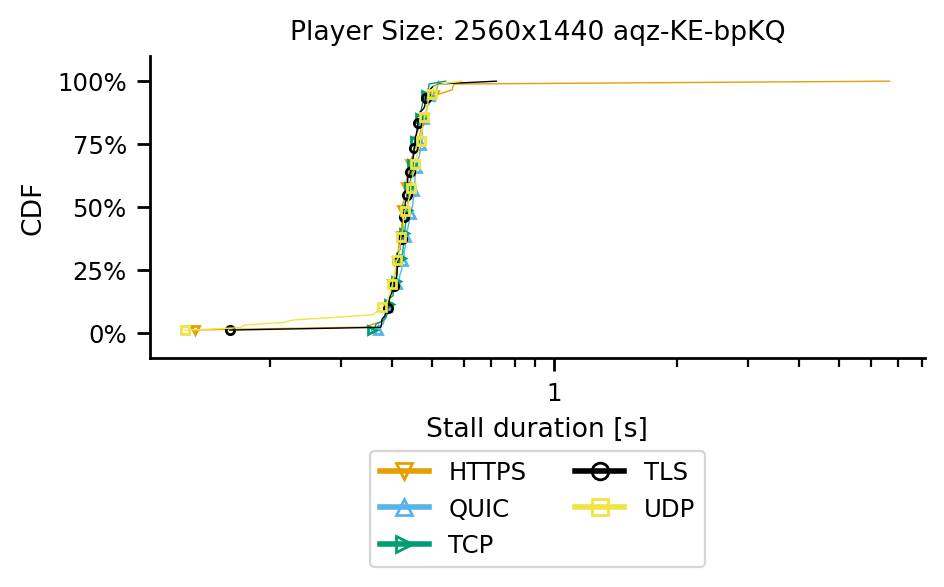

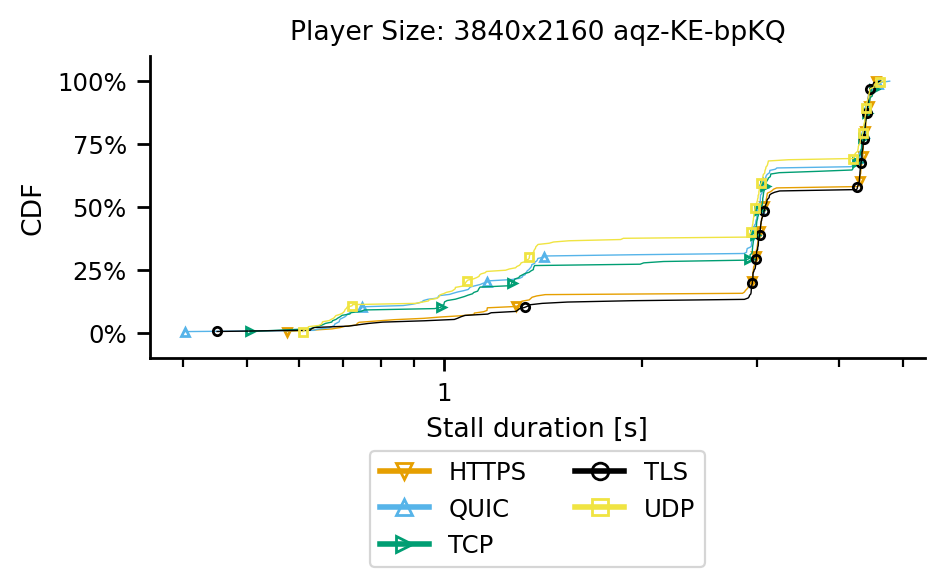

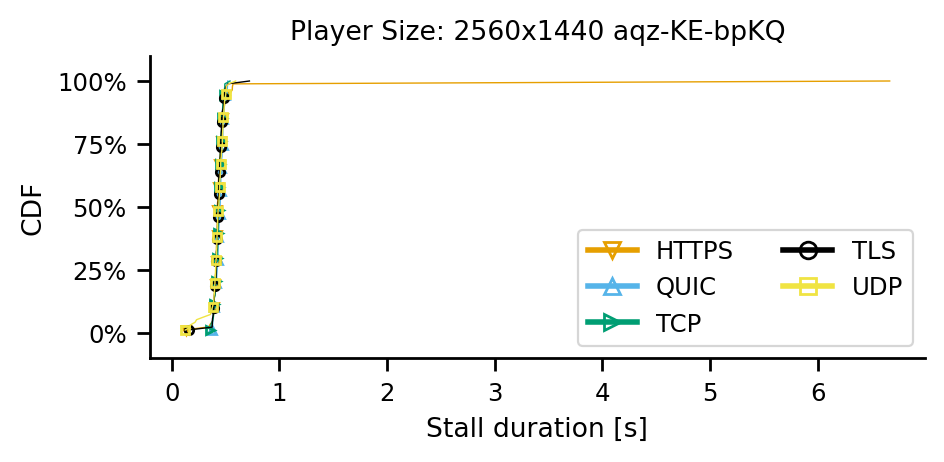

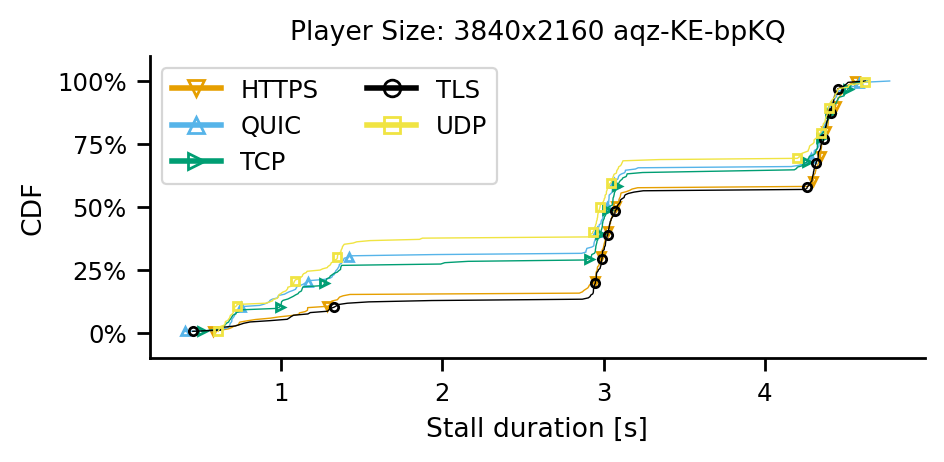

In [440]:
draw_cdf(df_stall_times, 'player_dimensions', 'protocol', 'stall_time', [True,False], 'Stall duration [s]', 'Player Size:', 'stall-durations-by-player-size-and-proto', [0,0])

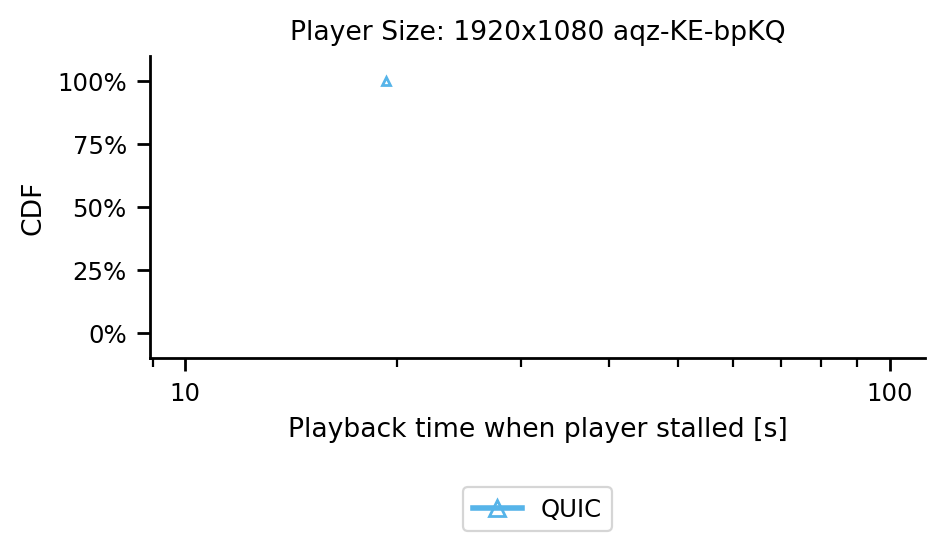

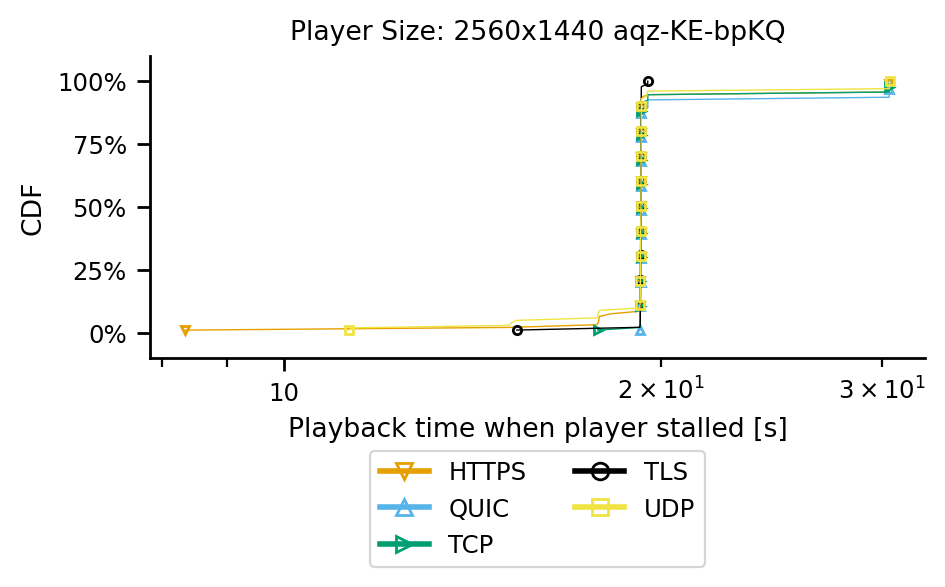

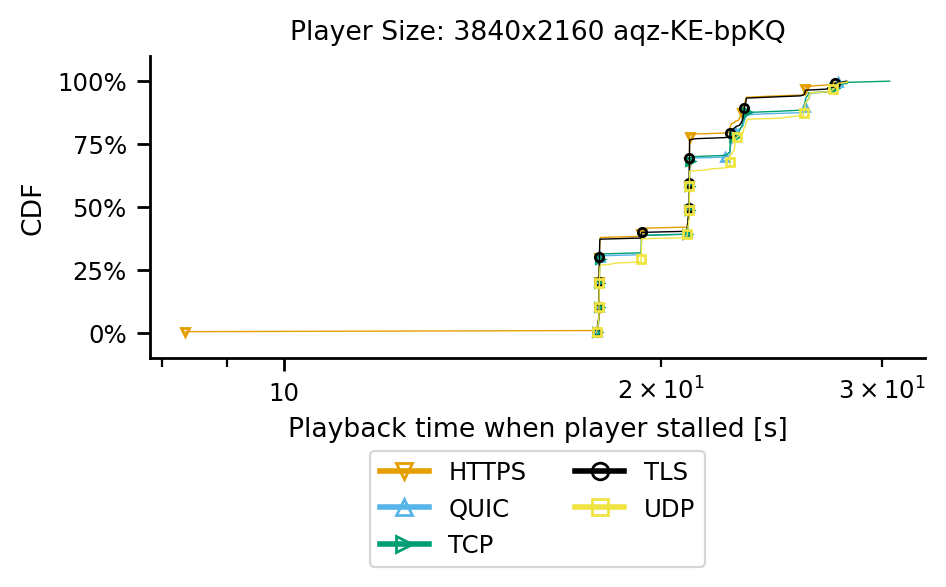

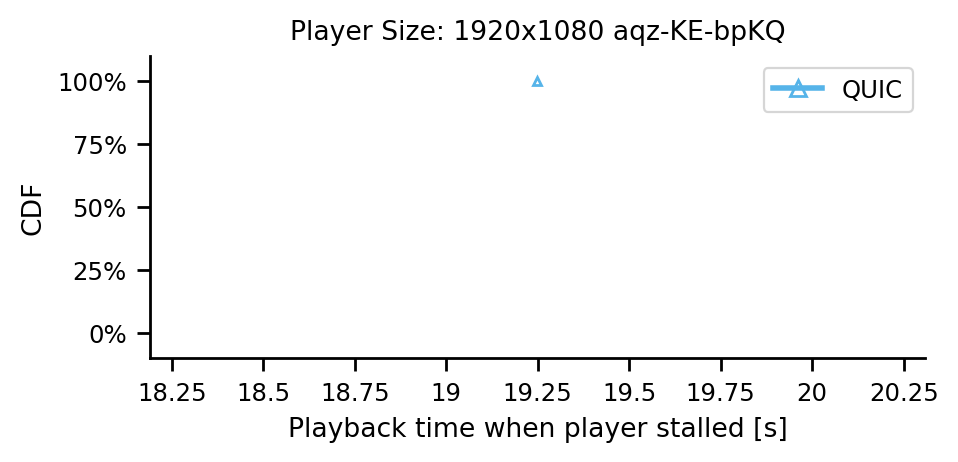

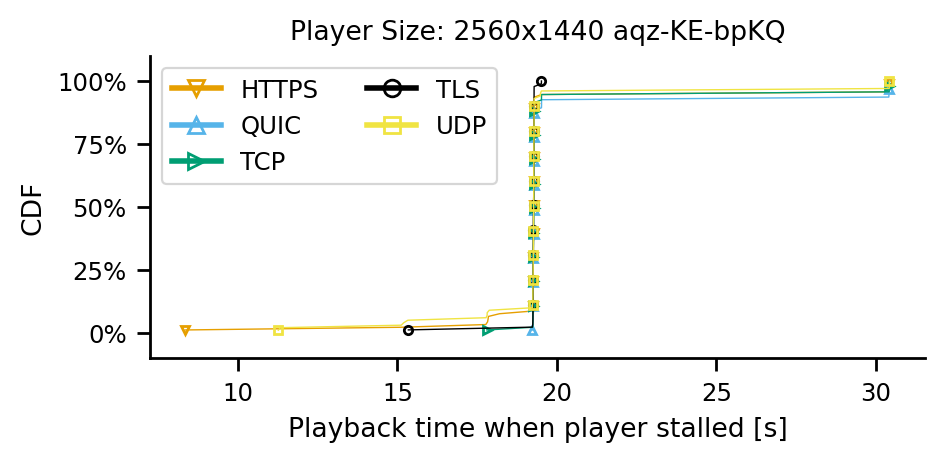

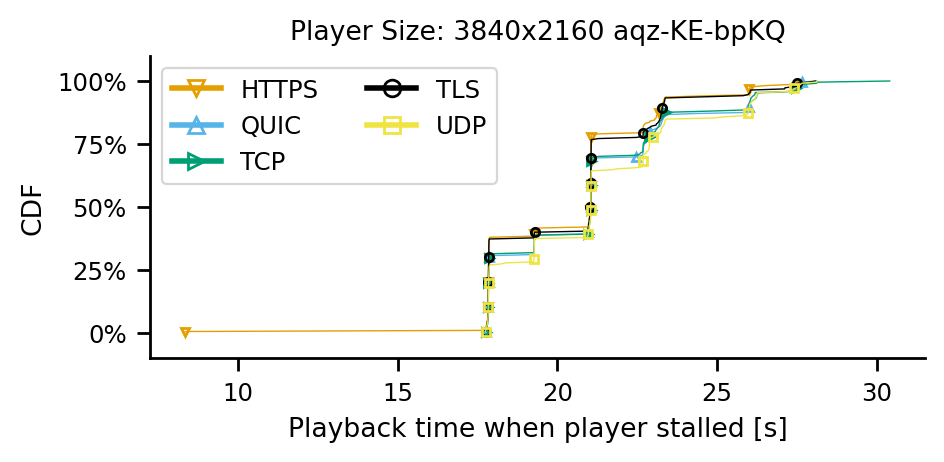

In [441]:
draw_cdf(df_buffering_events_time, 'player_dimensions', 'protocol', 'curr_play_time', [True,False], 'Playback time when player stalled [s]', 'Player Size:', 'buffer-events-by-player-size-and-proto', [0,0])

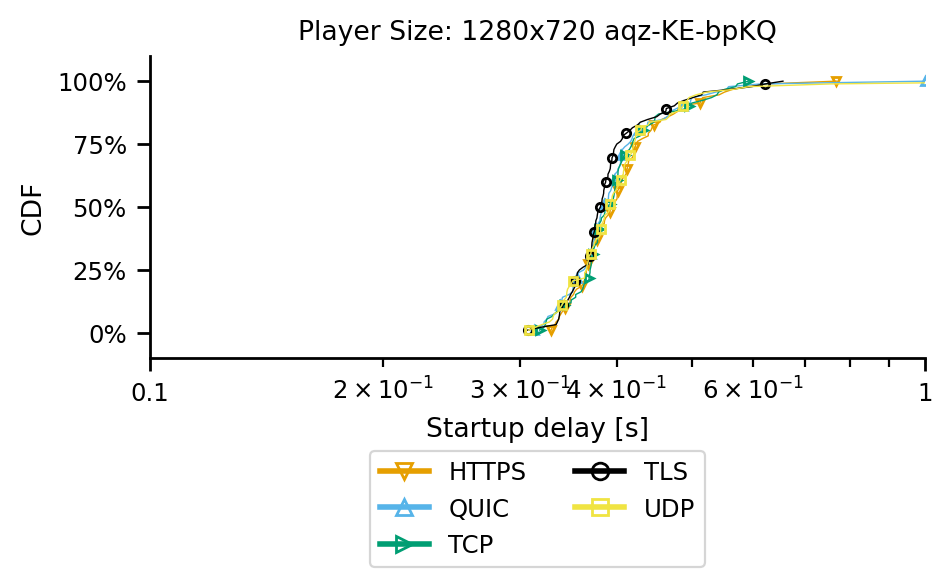

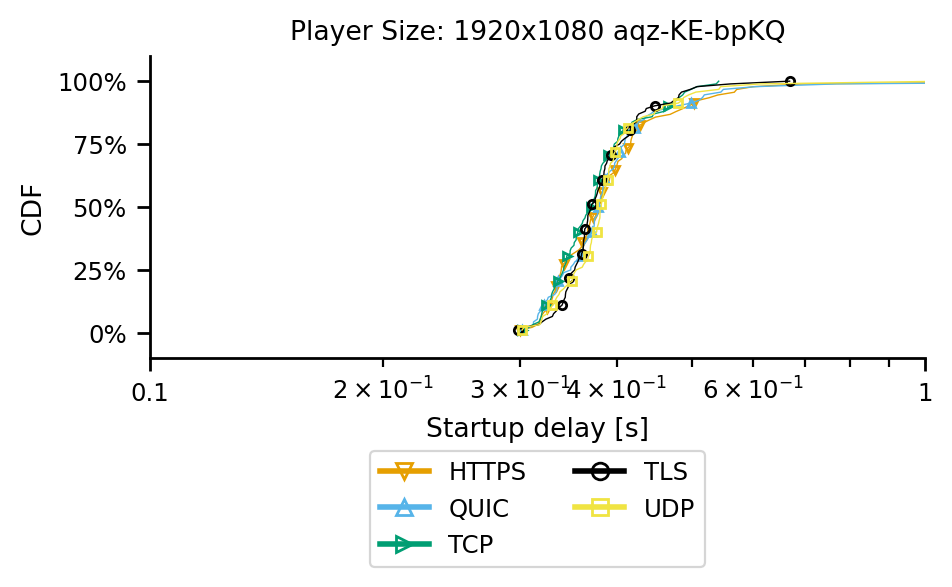

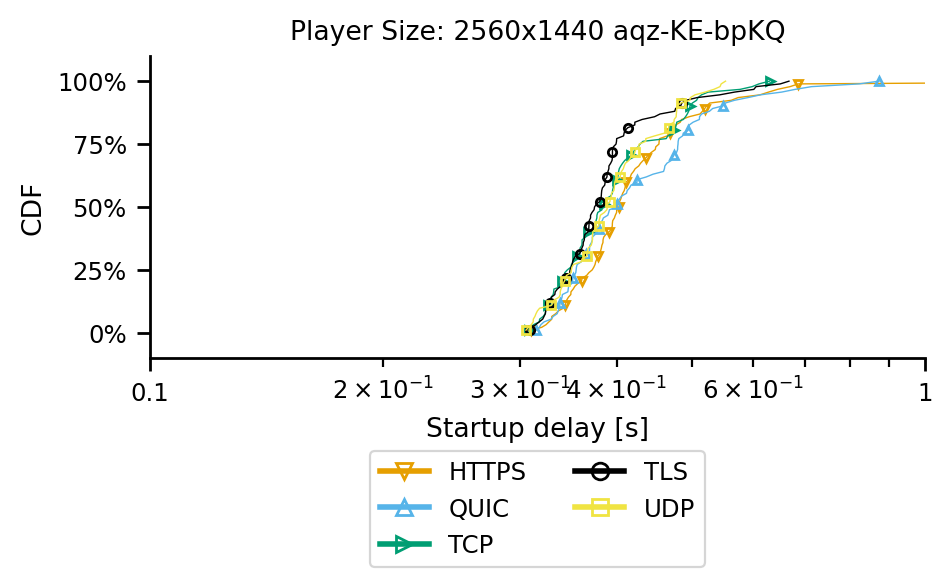

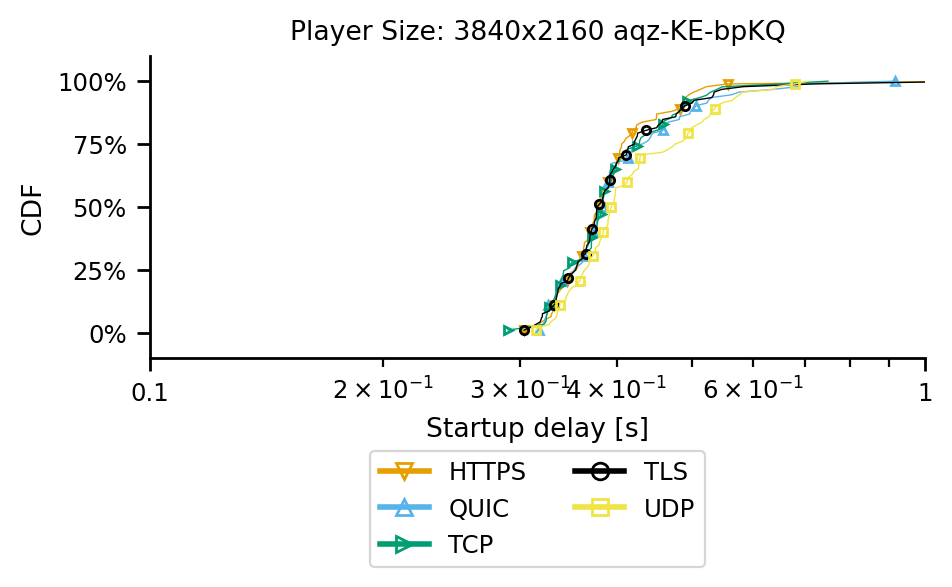

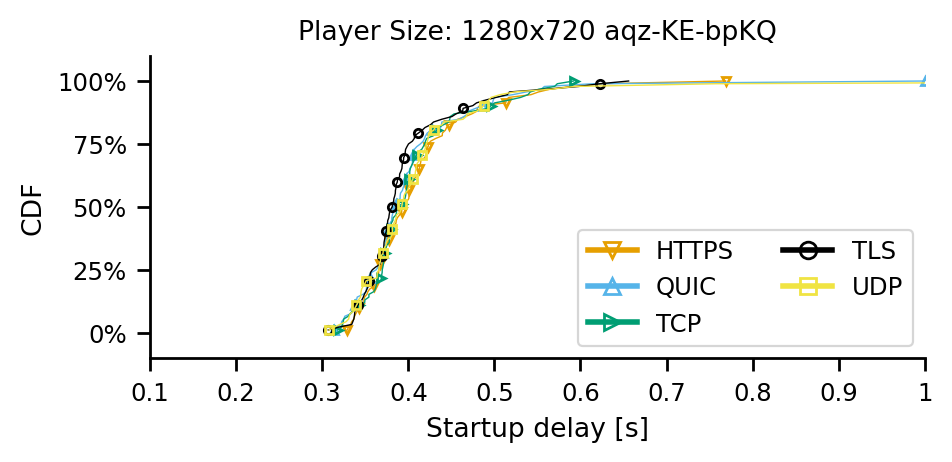

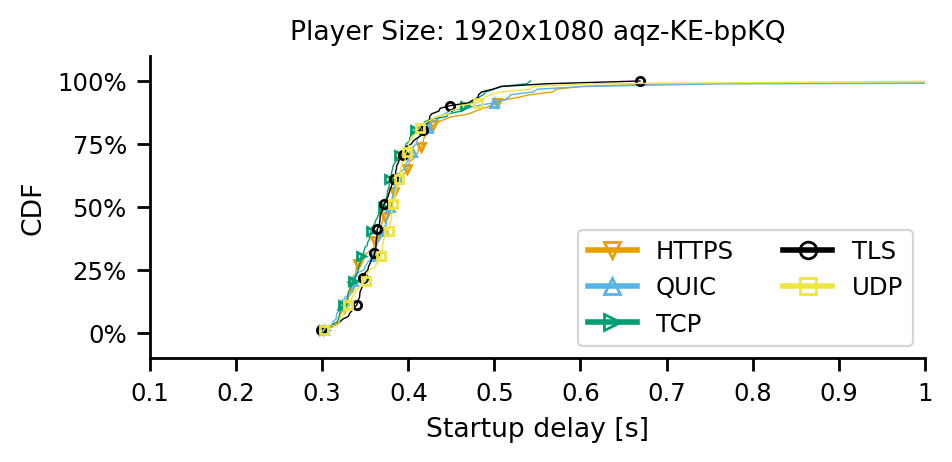

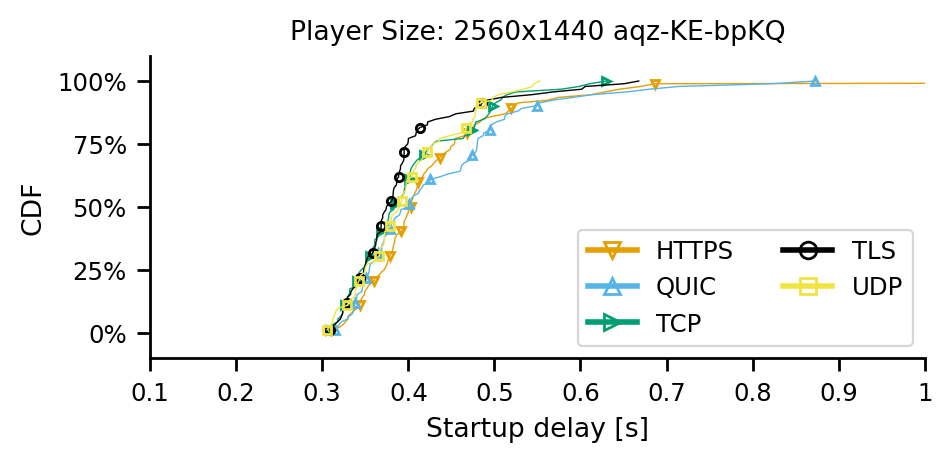

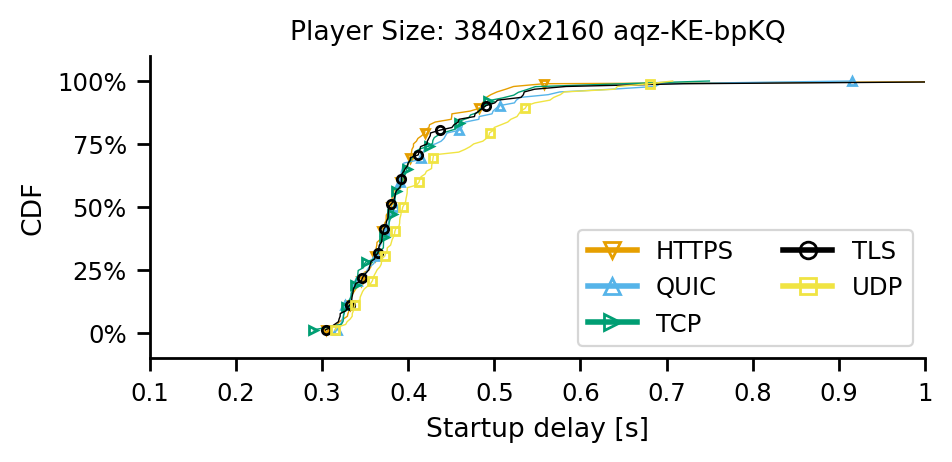

In [442]:
draw_cdf(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0.1,1])

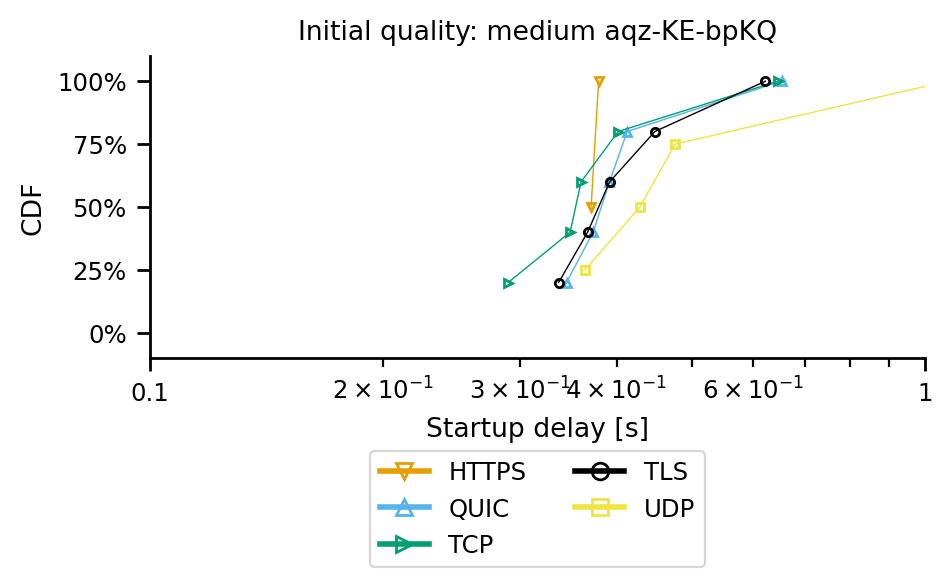

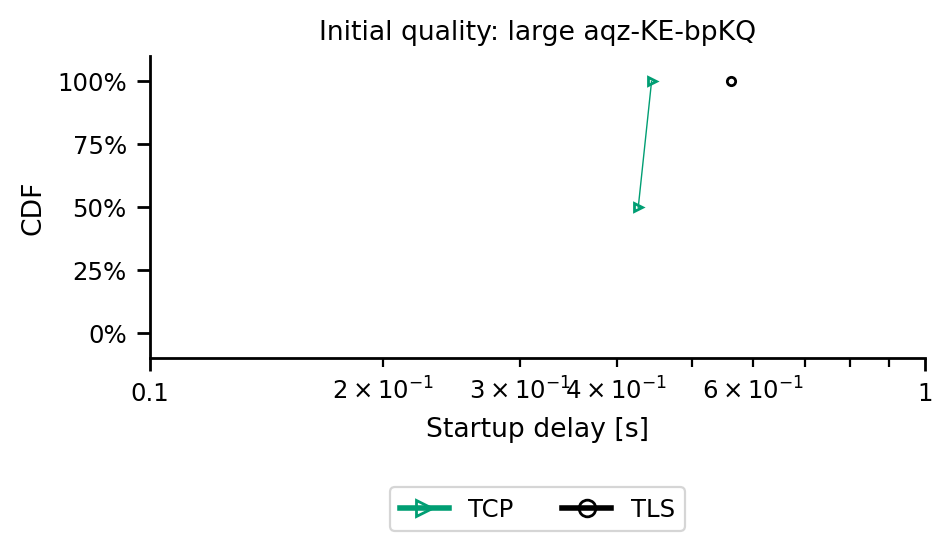

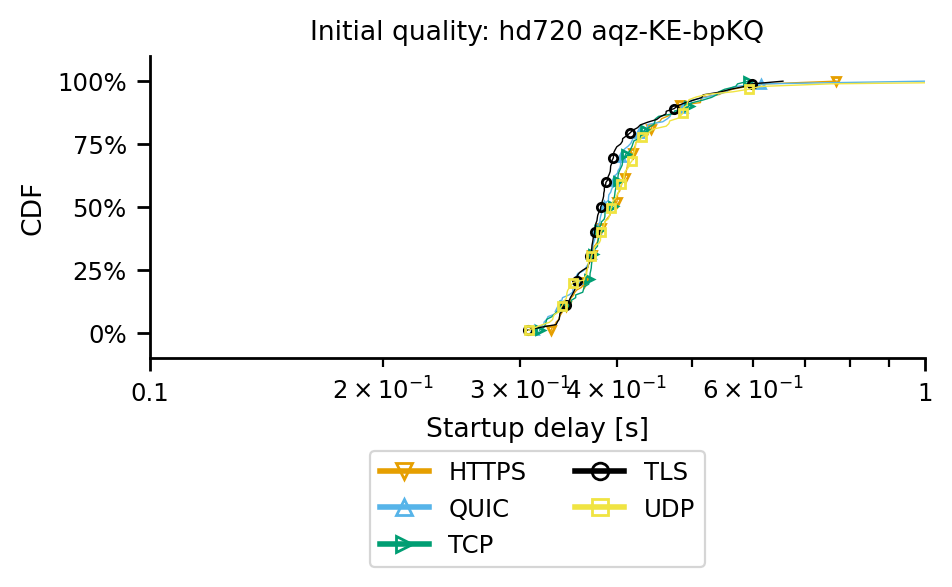

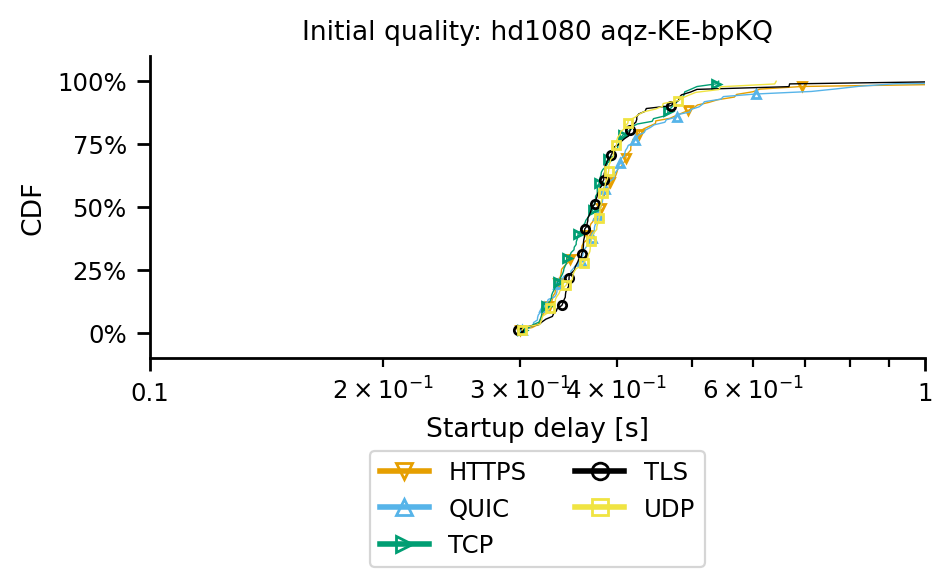

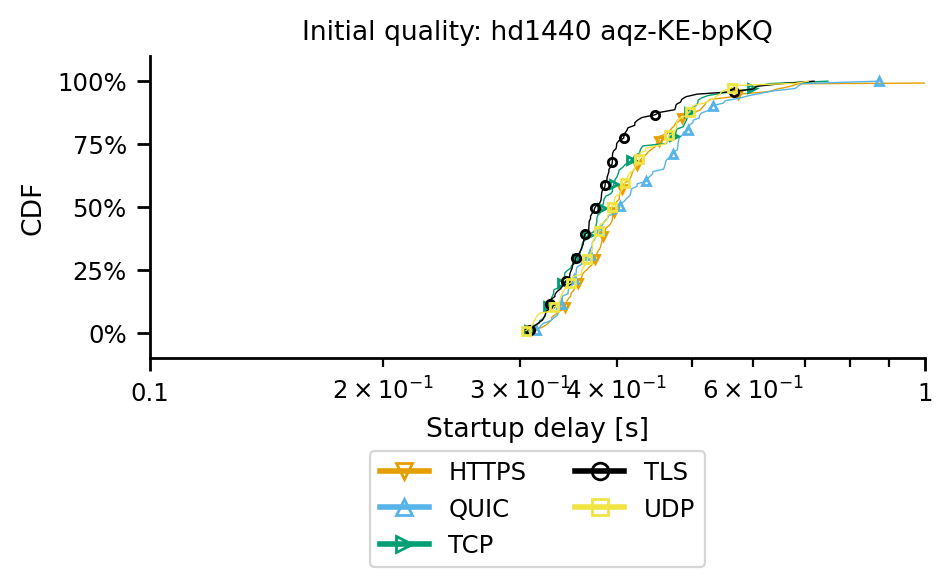

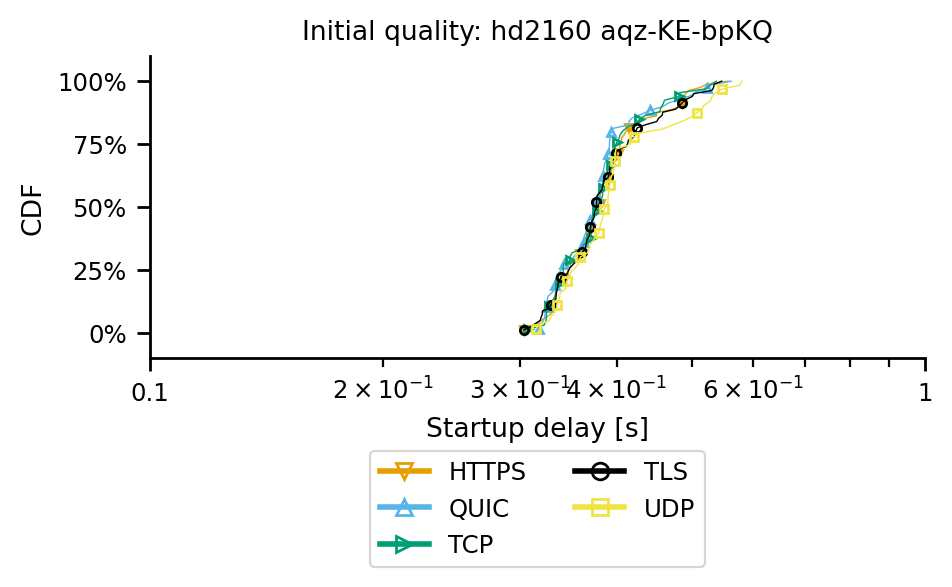

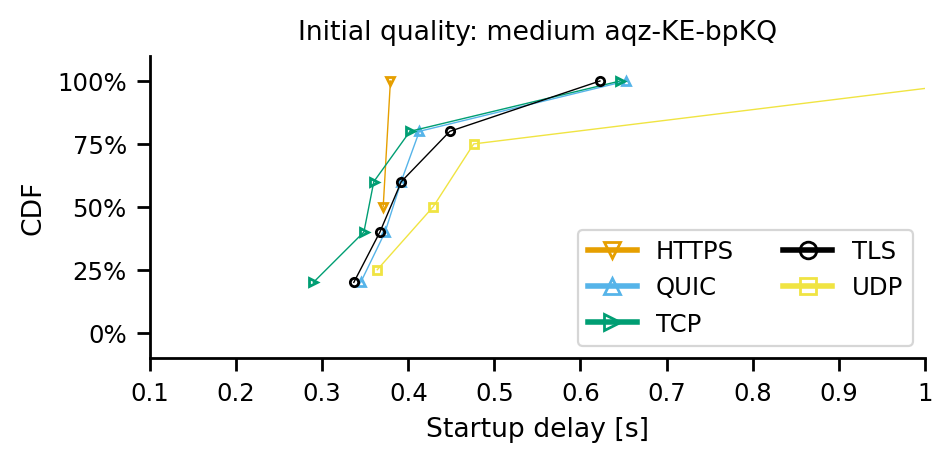

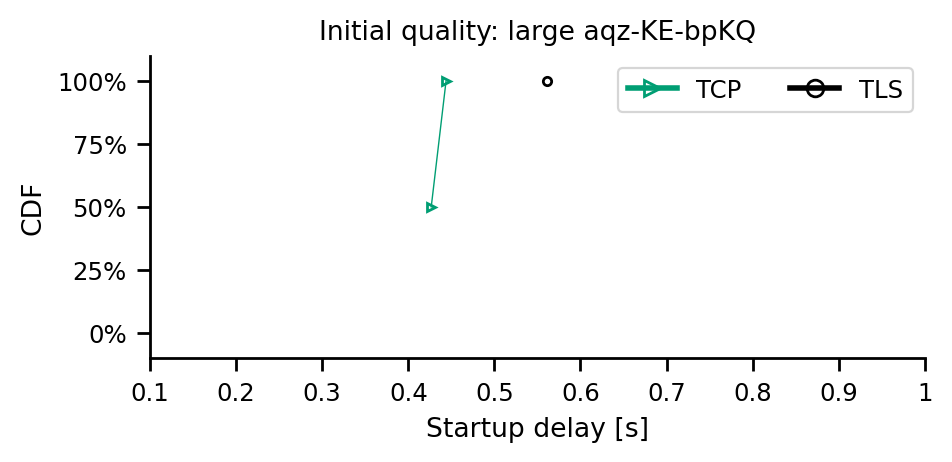

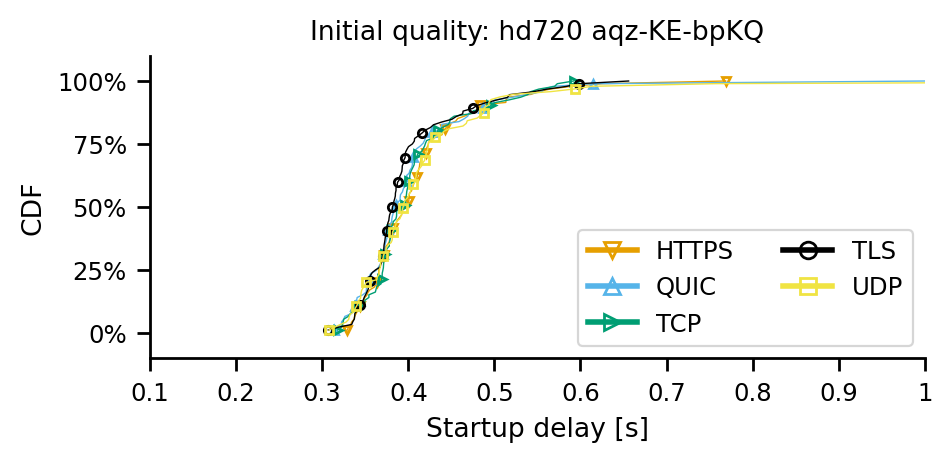

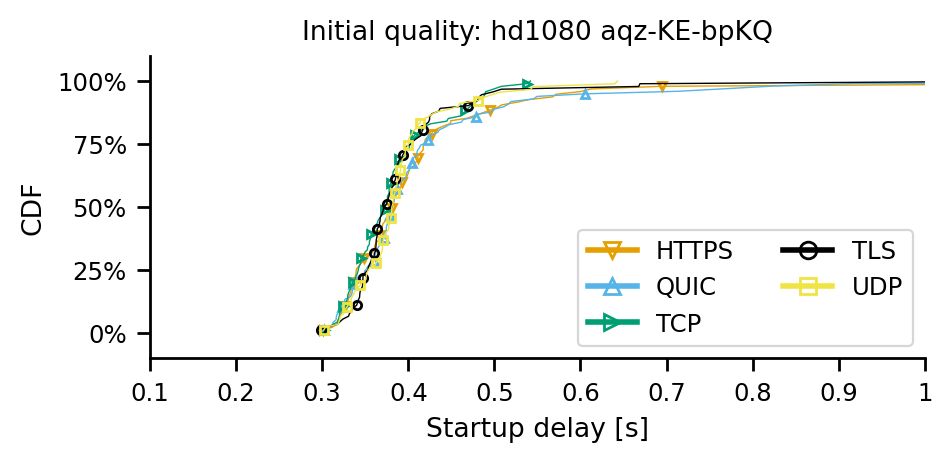

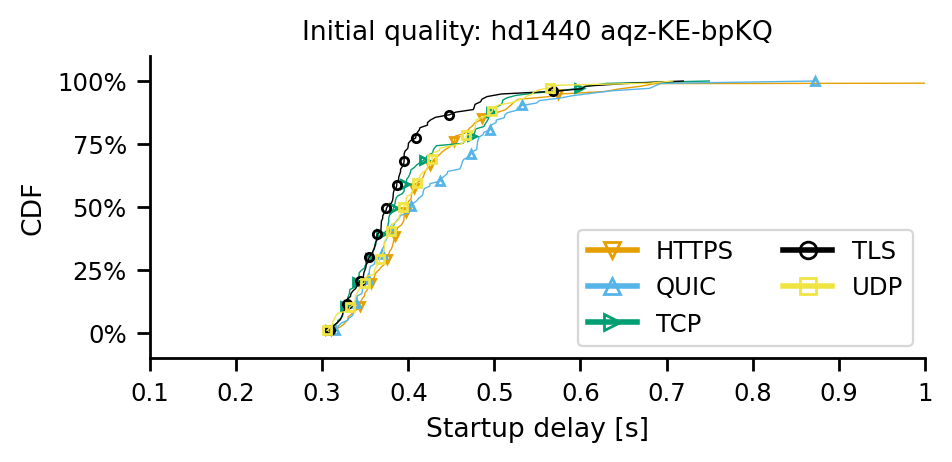

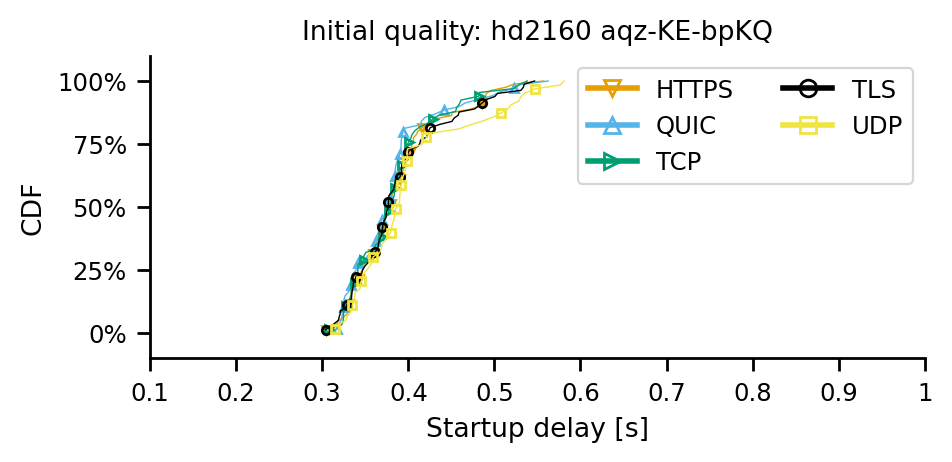

In [443]:
draw_cdf(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0.1,1])

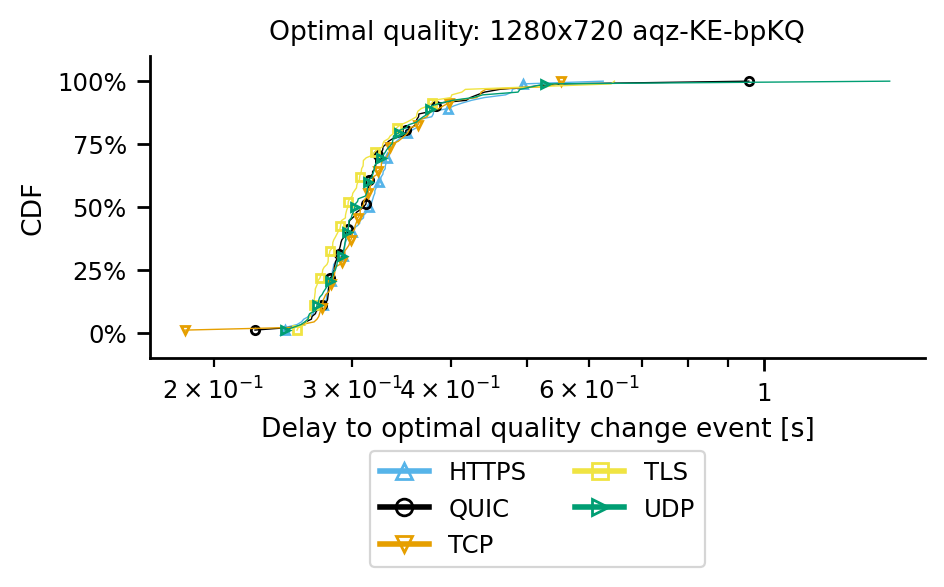

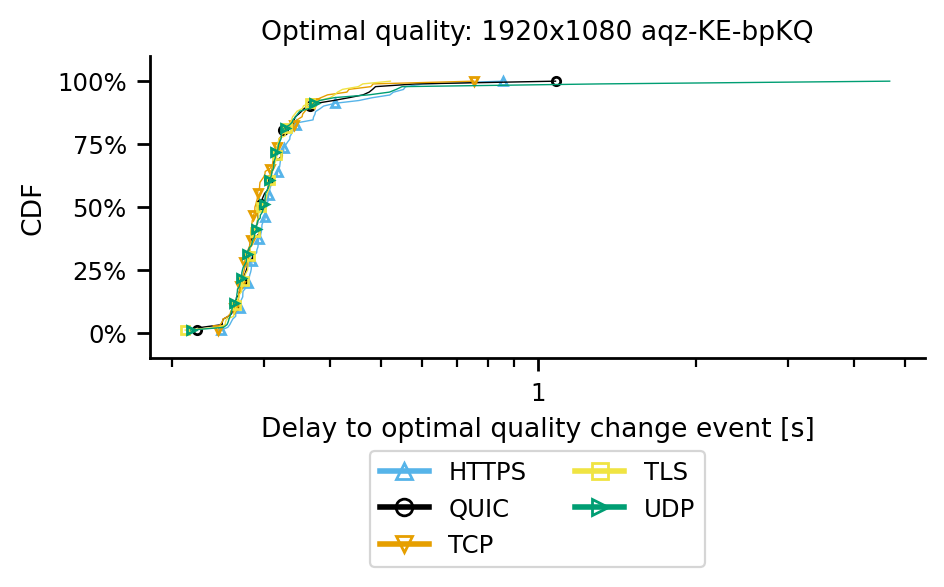

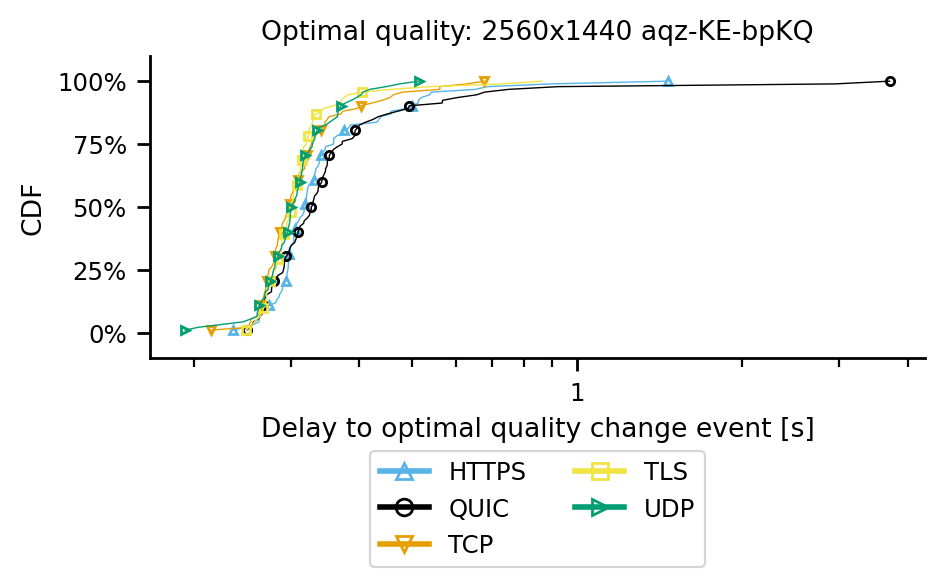

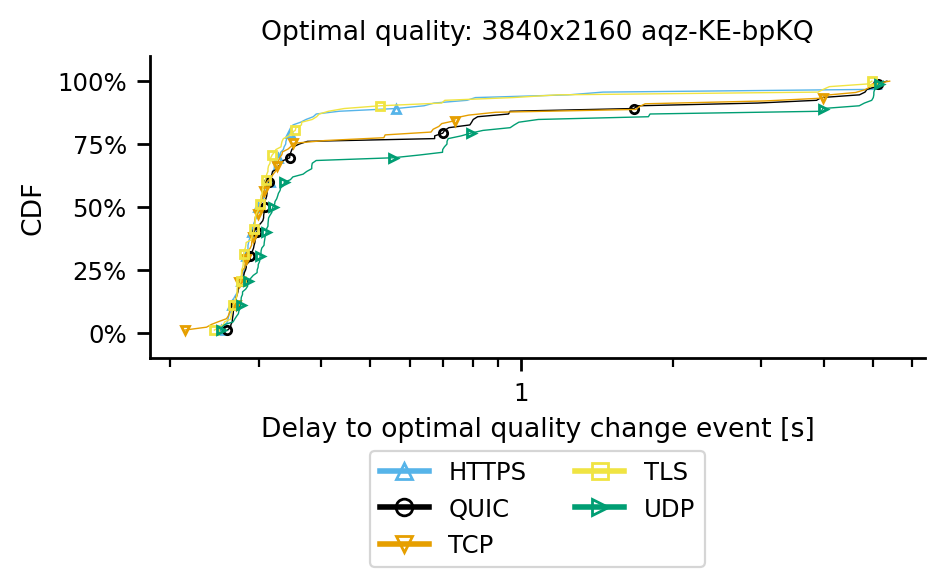

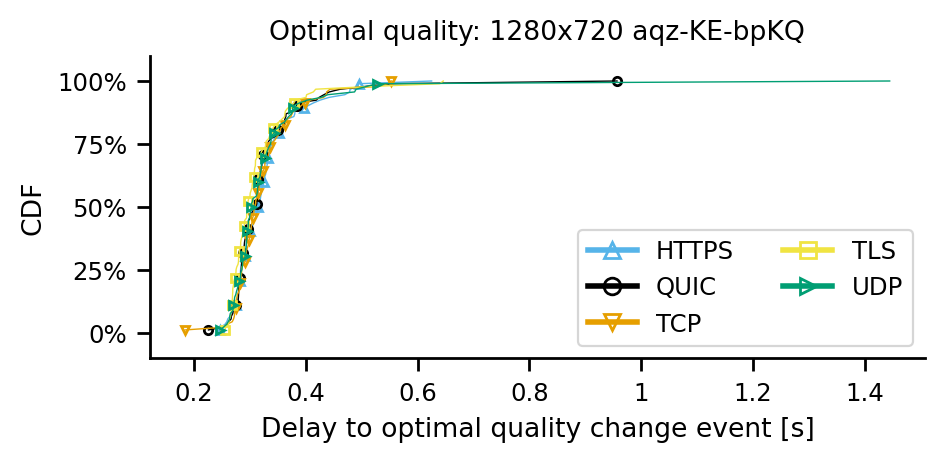

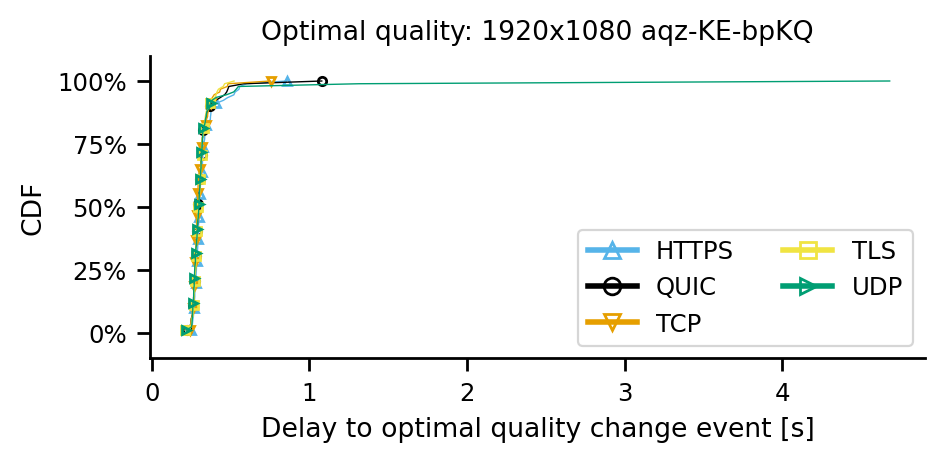

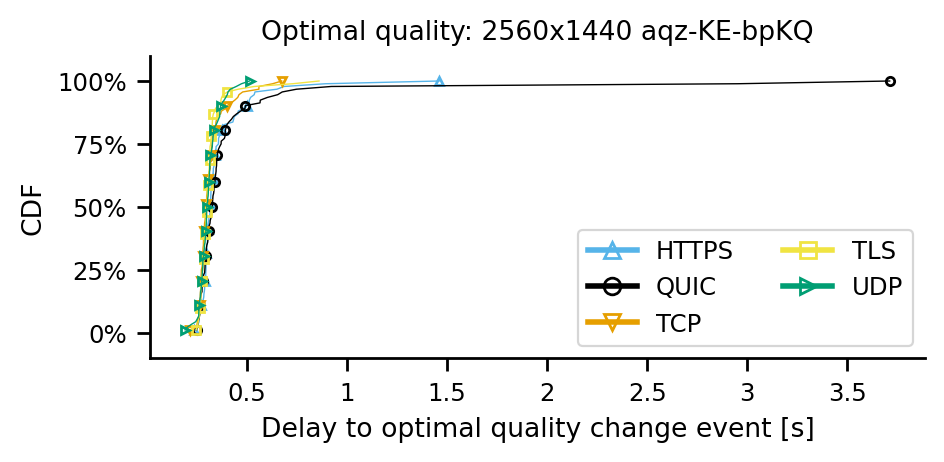

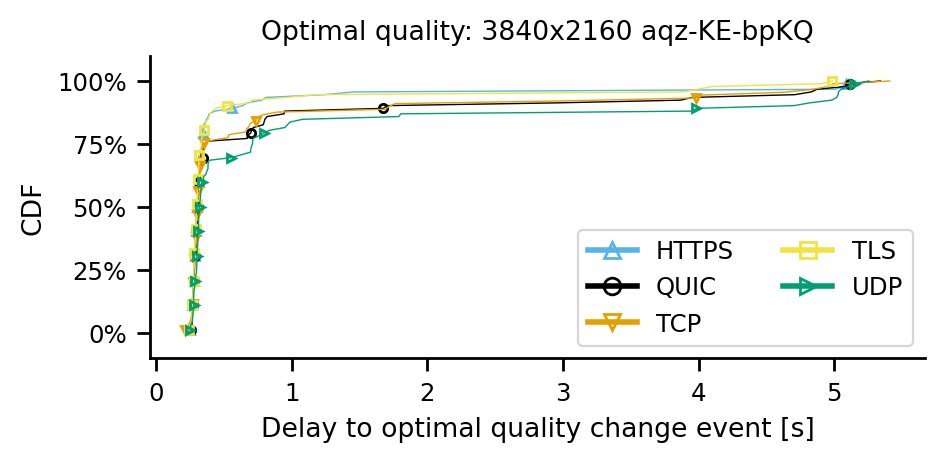

In [444]:

draw_cdf(df_player_quality_change_event_to_opt, 'optimal_res', 'protocol', 'optimal_quality_delay', [True,False], 'Delay to optimal quality change event [s]', 'Optimal quality:', 'optimal-quality-delay-by-optimal-quality-and-proto', [0,0])

In [445]:
def draw_boxplot(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim, ylabel):
    colors = dict(zip(list(df_[col_name_].unique()), ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(list(df_[col_name_].unique()), ['o','v','^','>','s','p','h','d','<','.']))
    with plt.style.context('seaborn-whitegrid'):
        for vp in df_['vantagePoint'].unique():
            print(vp)
            for video in df_['domain'].unique():
                for log in log_list:
                    for col_grp_ in df_[col_outer_groupby_].sort_values().unique():
                        lnwidth = .5
                        mrksize = 3
                        df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                        fig, ax = plt.subplots(figsize=(6,8))
                        #hue=
                        boxplt = sns.boxplot(x=col_metric_, y=col_name_ , data=df_tmp, orient='h', linewidth=1, ax=ax, 
                        showfliers=True, 
                        color='white',
                        meanline = True, showmeans = True, meanprops=dict(color='darkgoldenrod'), medianprops=dict(color='blue'))
                        sw = sns.swarmplot(x=col_metric_, y=col_name_, data=df_tmp, color=".25", ax=ax, orient='h', size=1.5)
                        
                        if log:
                            ax.set_xscale('log')
                        
                        
                        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                        ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


                        ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                        ax.set_xlabel(xlabel)

                        ax.set_ylabel(ylabel)
                        if xlim != [0,0]:
                            ax.set_xlim(xlim)

                        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
                        ax.grid(b=True, which='both')


                        if log:
                            fig.savefig('figures/boxplot-'+figname+col_grp_+video+vp+'-log.pdf', format='pdf', bbox_inches='tight')
                        else:
                            fig.savefig('figures/boxplot-'+figname+col_grp_+video+vp+'.pdf', format='pdf', bbox_inches='tight')
                        plt.show()

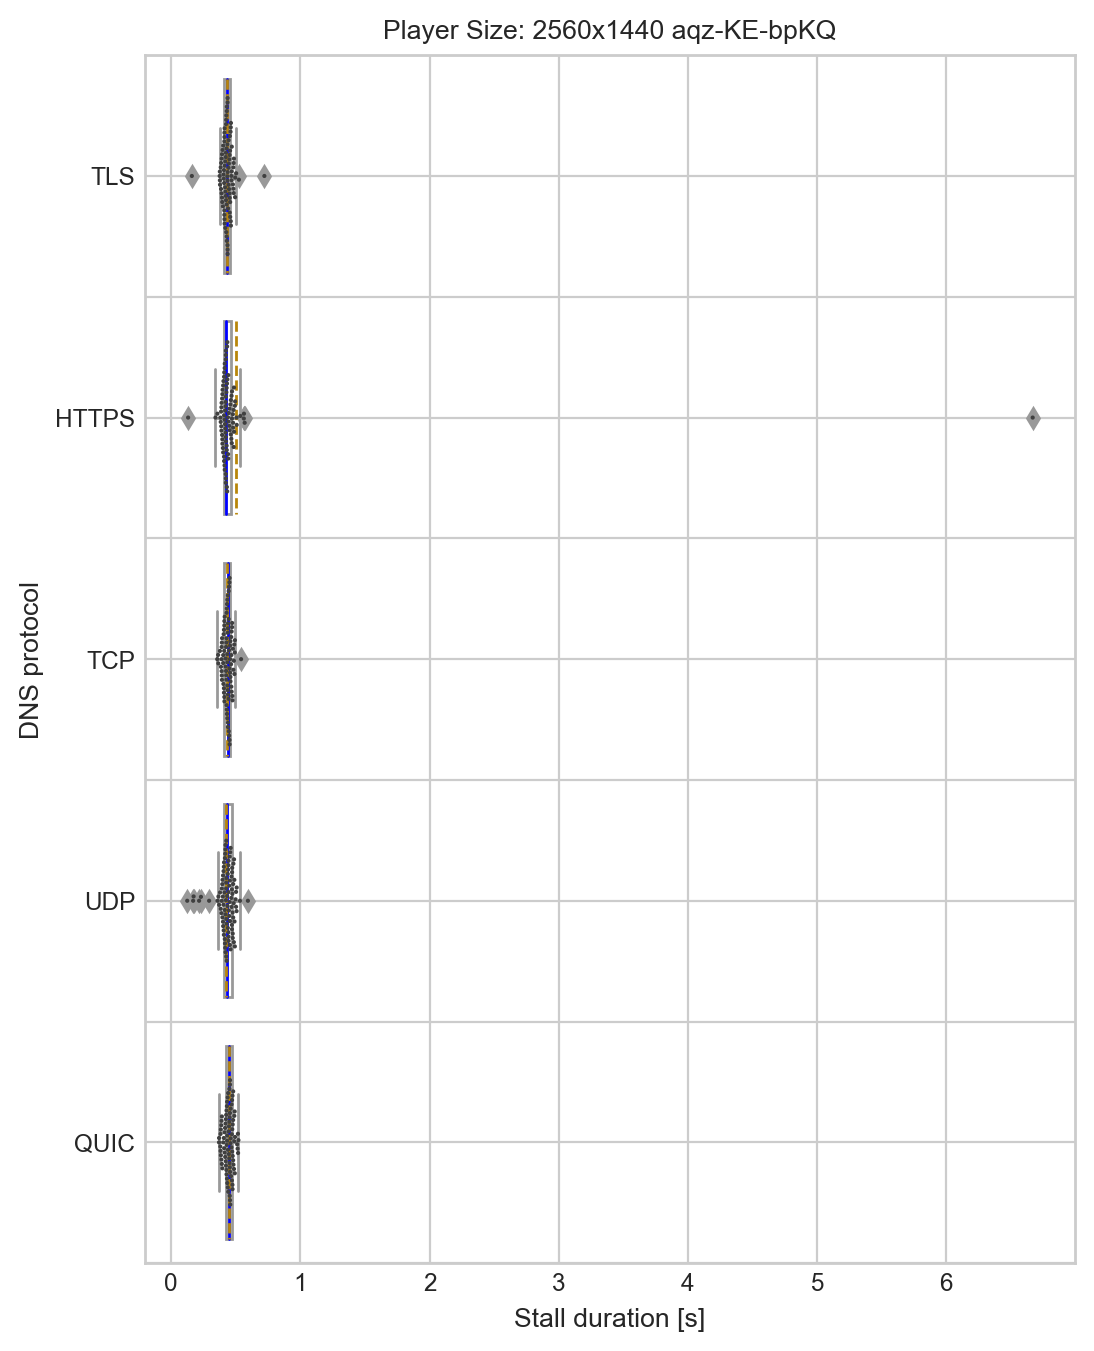

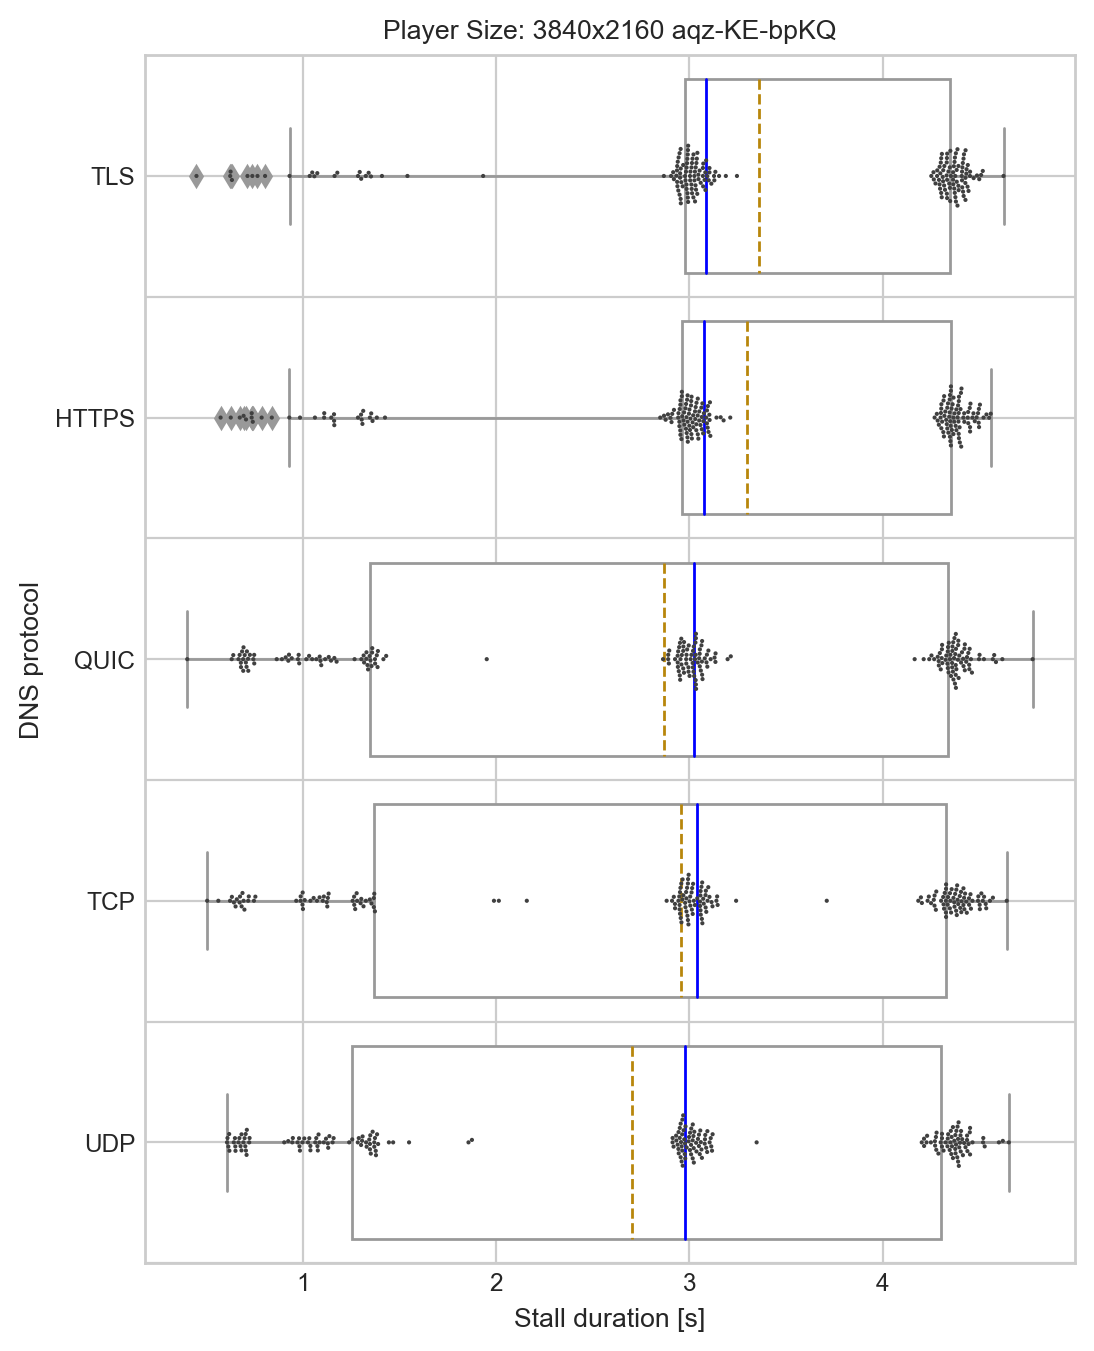

In [446]:
draw_boxplot(df_stall_times, 'player_dimensions', 'protocol', 'stall_time', [False], 'Stall duration [s]', 'Player Size:', 'stall-durations-by-player-size-and-proto', [0,0], "DNS protocol")

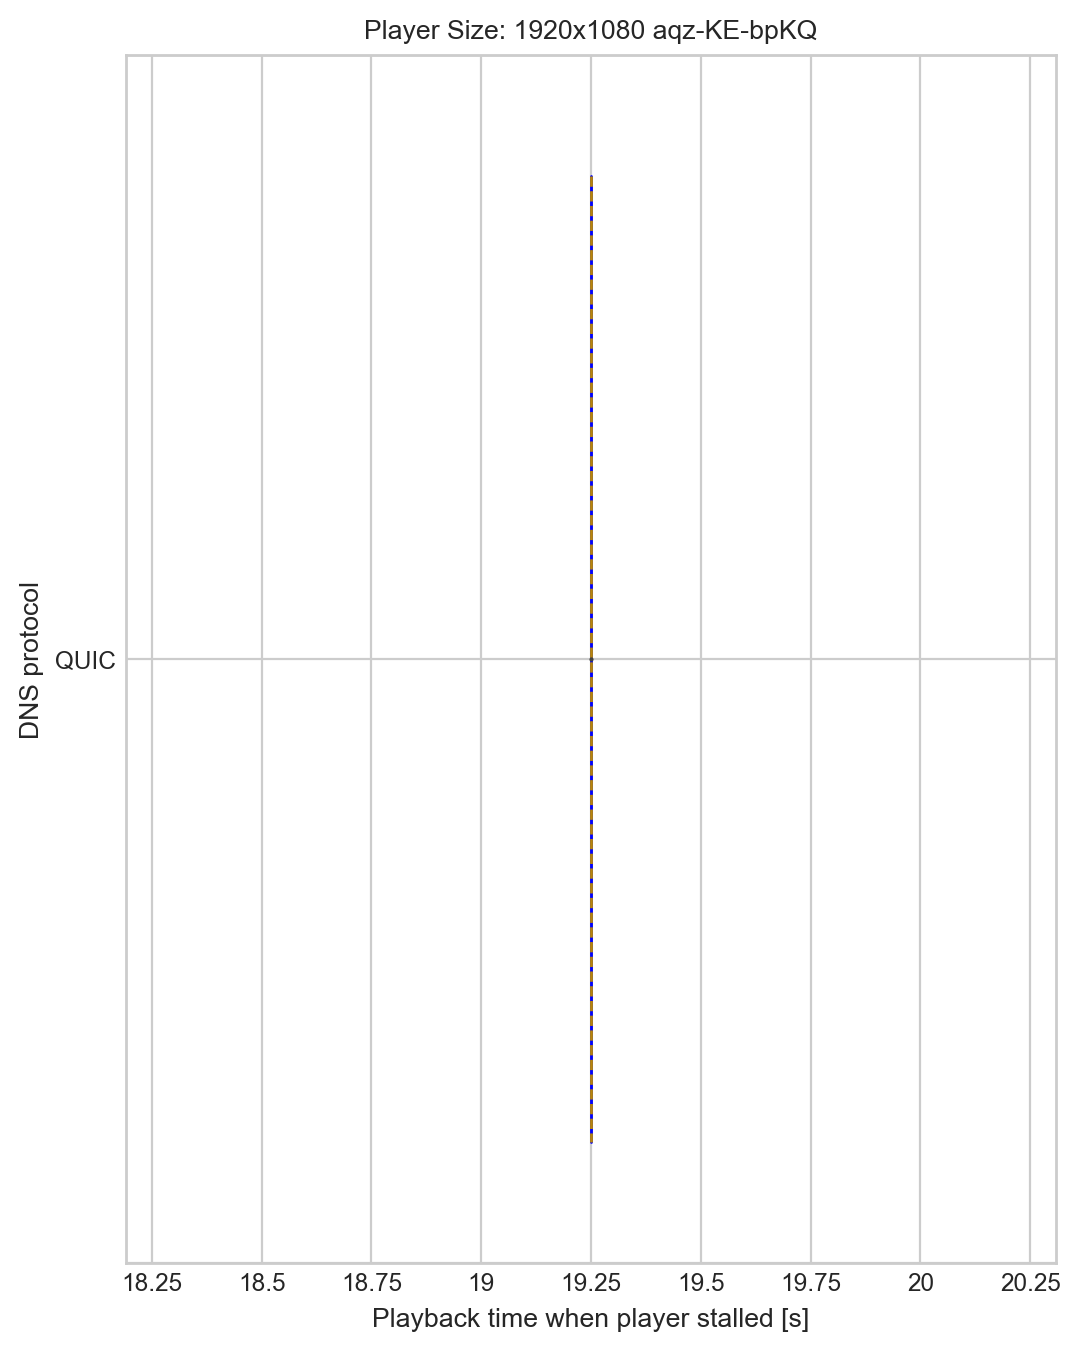

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 47.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 37.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 41.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot

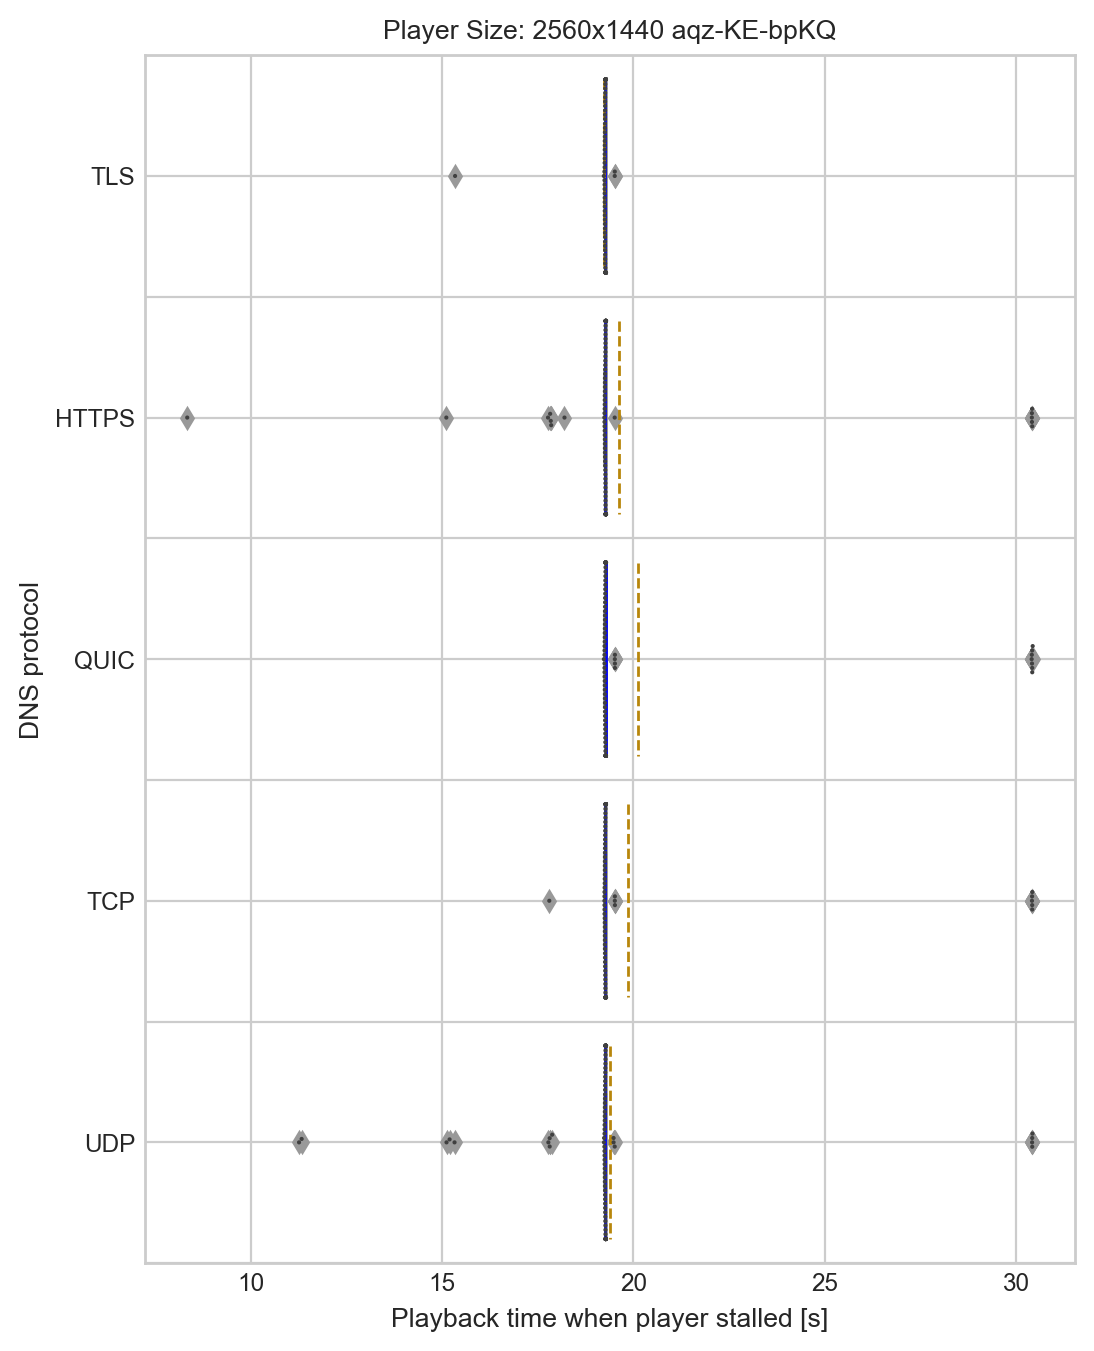

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 19.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot

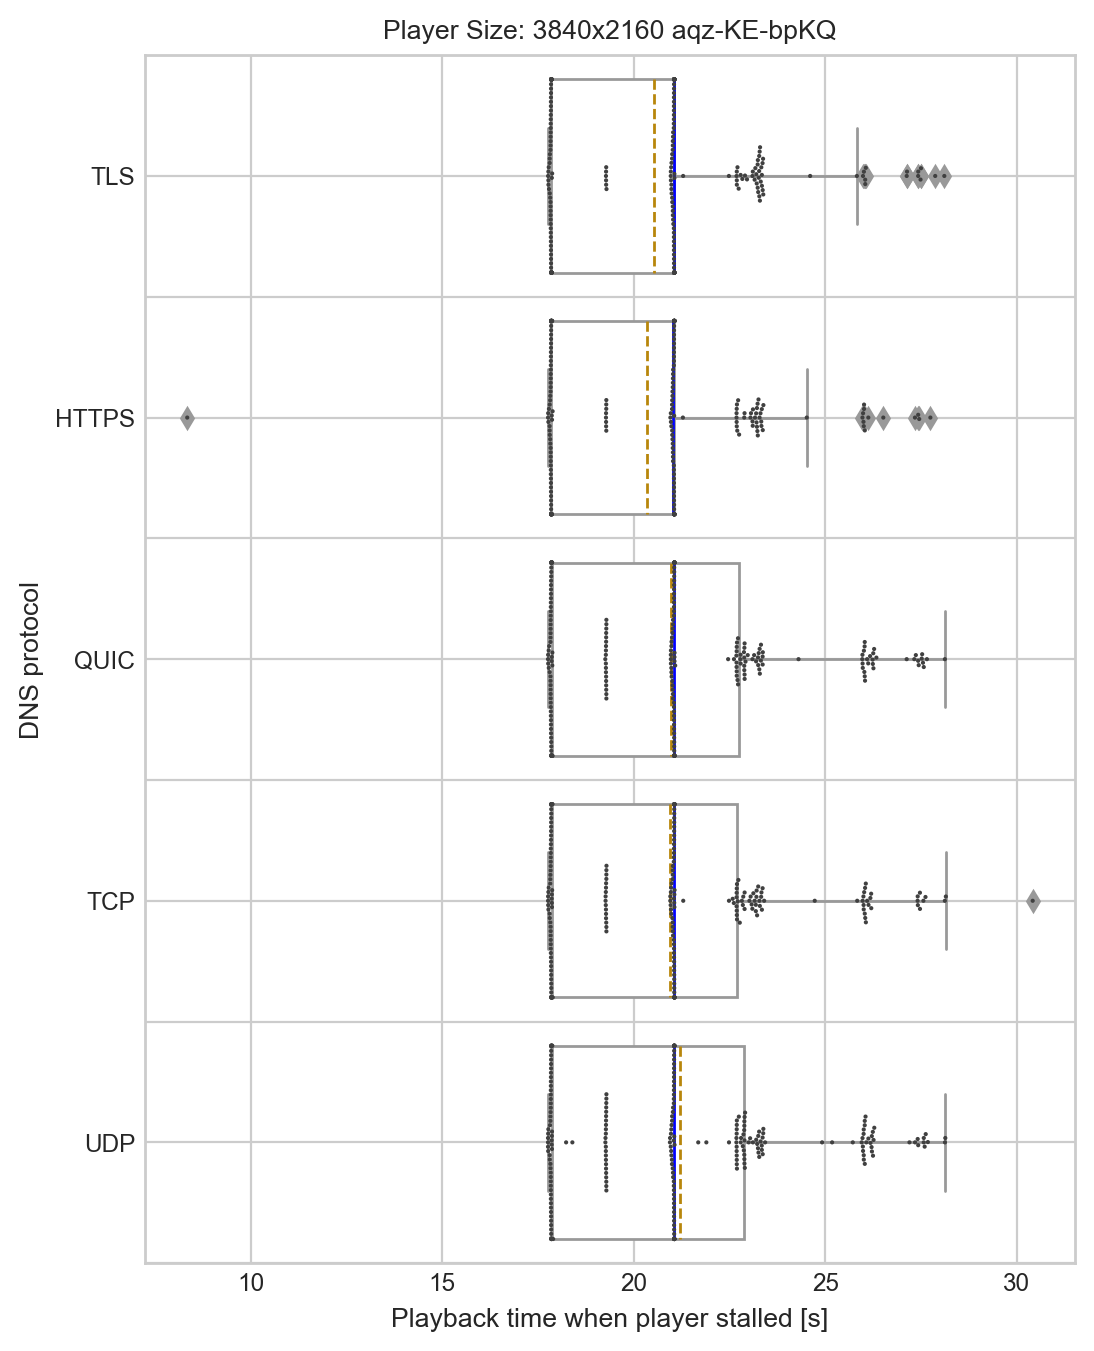

In [447]:
draw_boxplot(df_buffering_events_time, 'player_dimensions', 'protocol', 'curr_play_time', [False], 'Playback time when player stalled [s]', 'Player Size:', 'buffer-events-by-player-size-and-proto', [0,0], "DNS protocol")

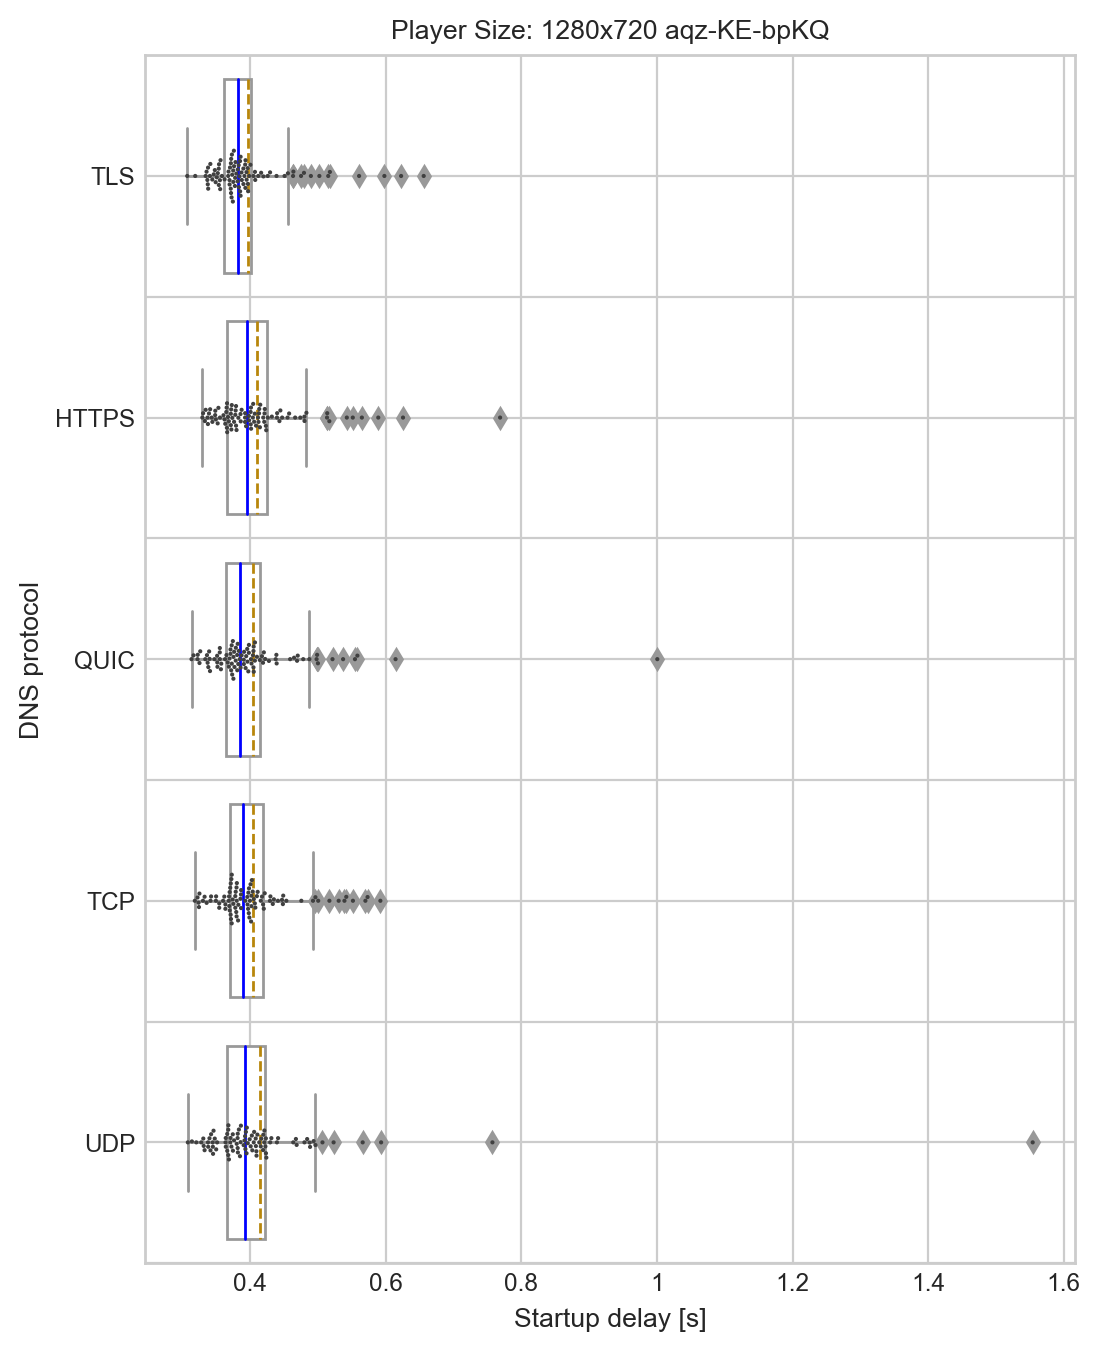

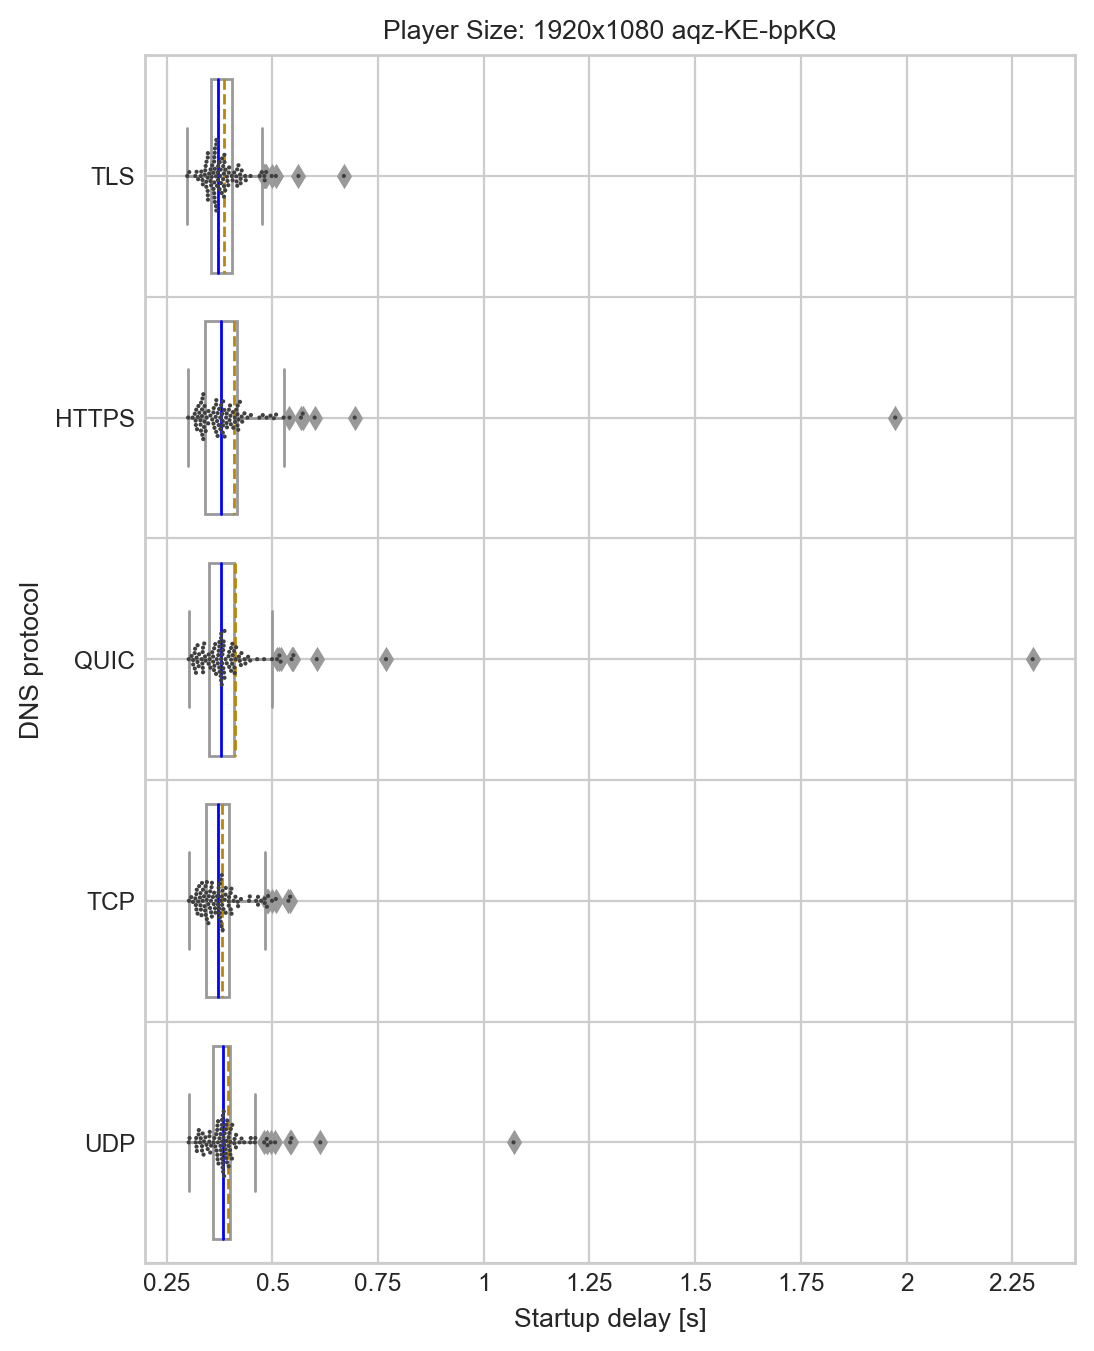

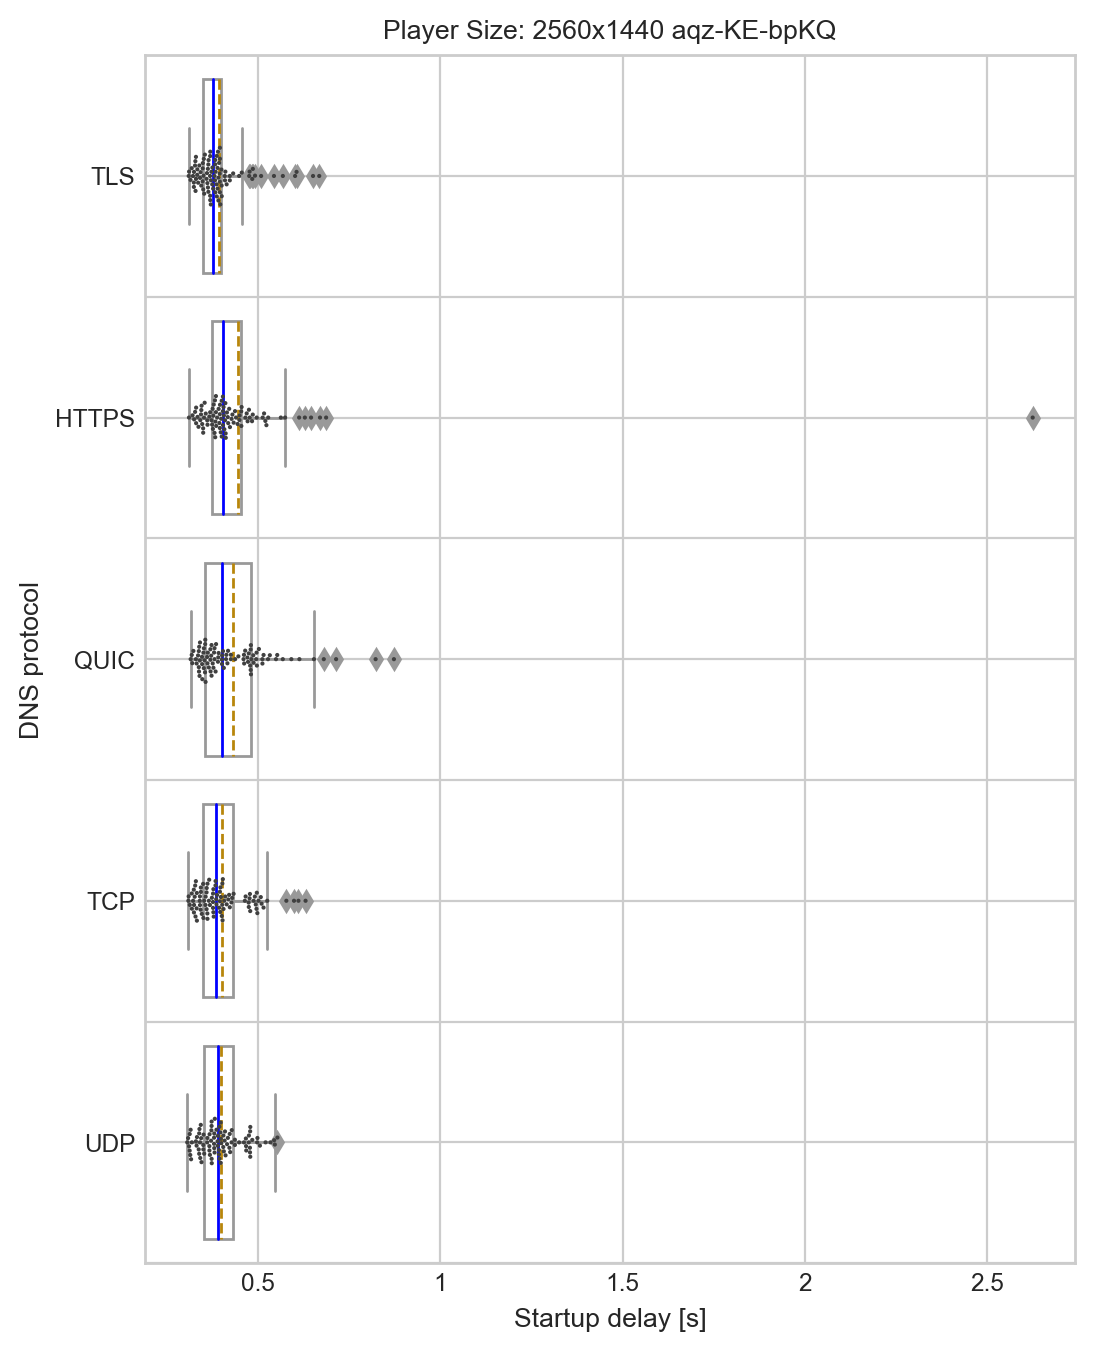

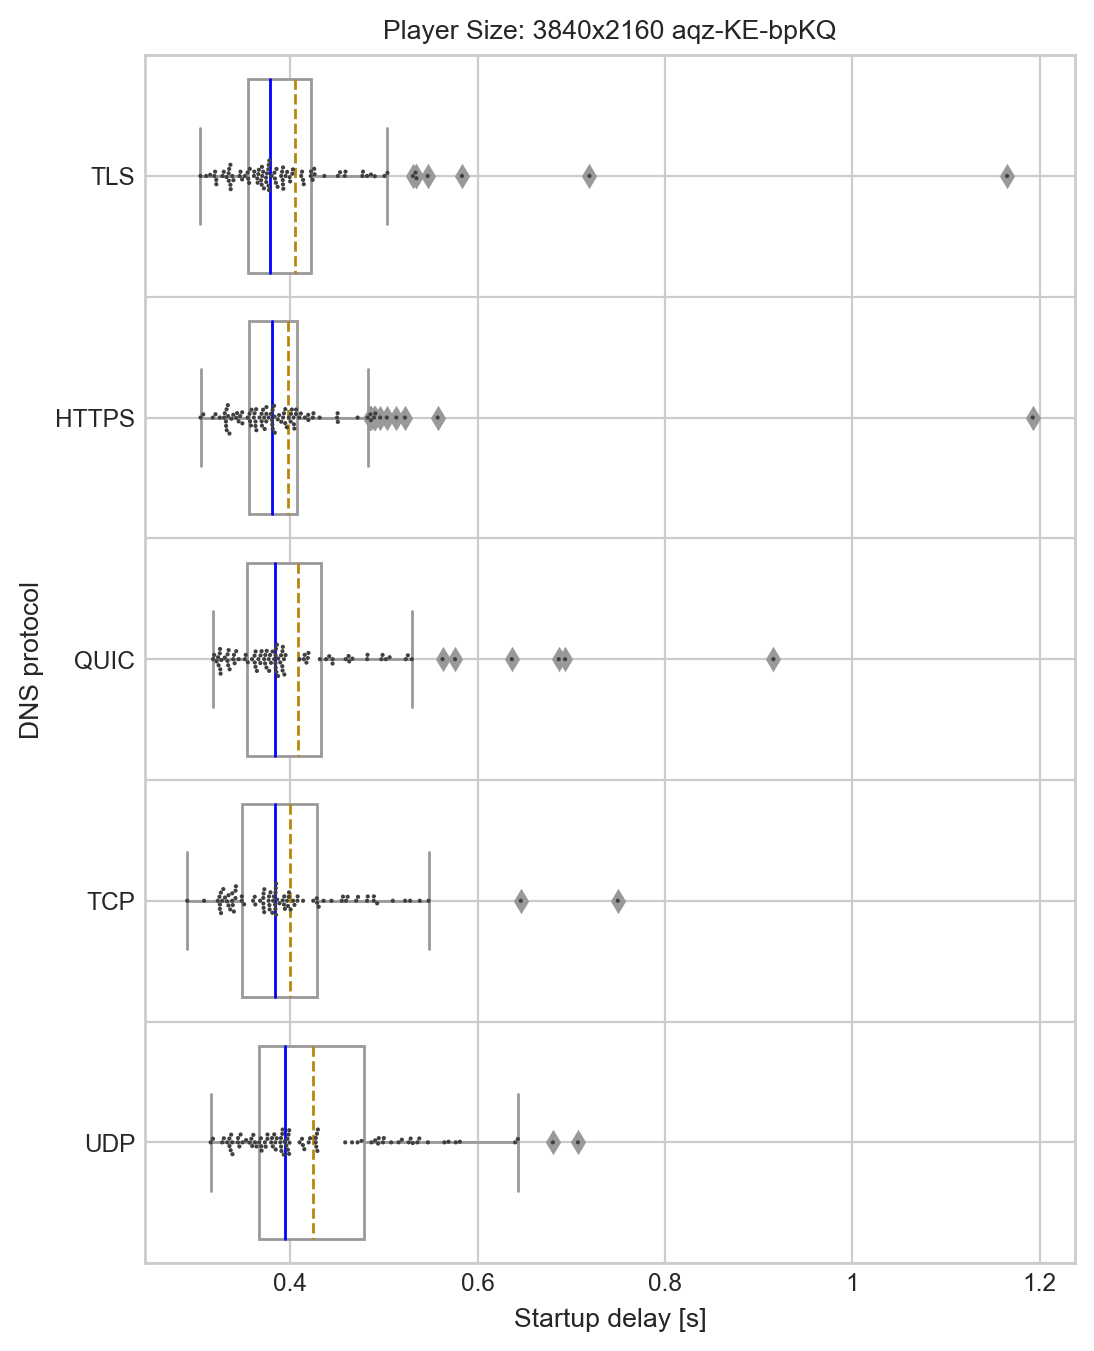

In [448]:
draw_boxplot(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0,0], "DNS protocol")

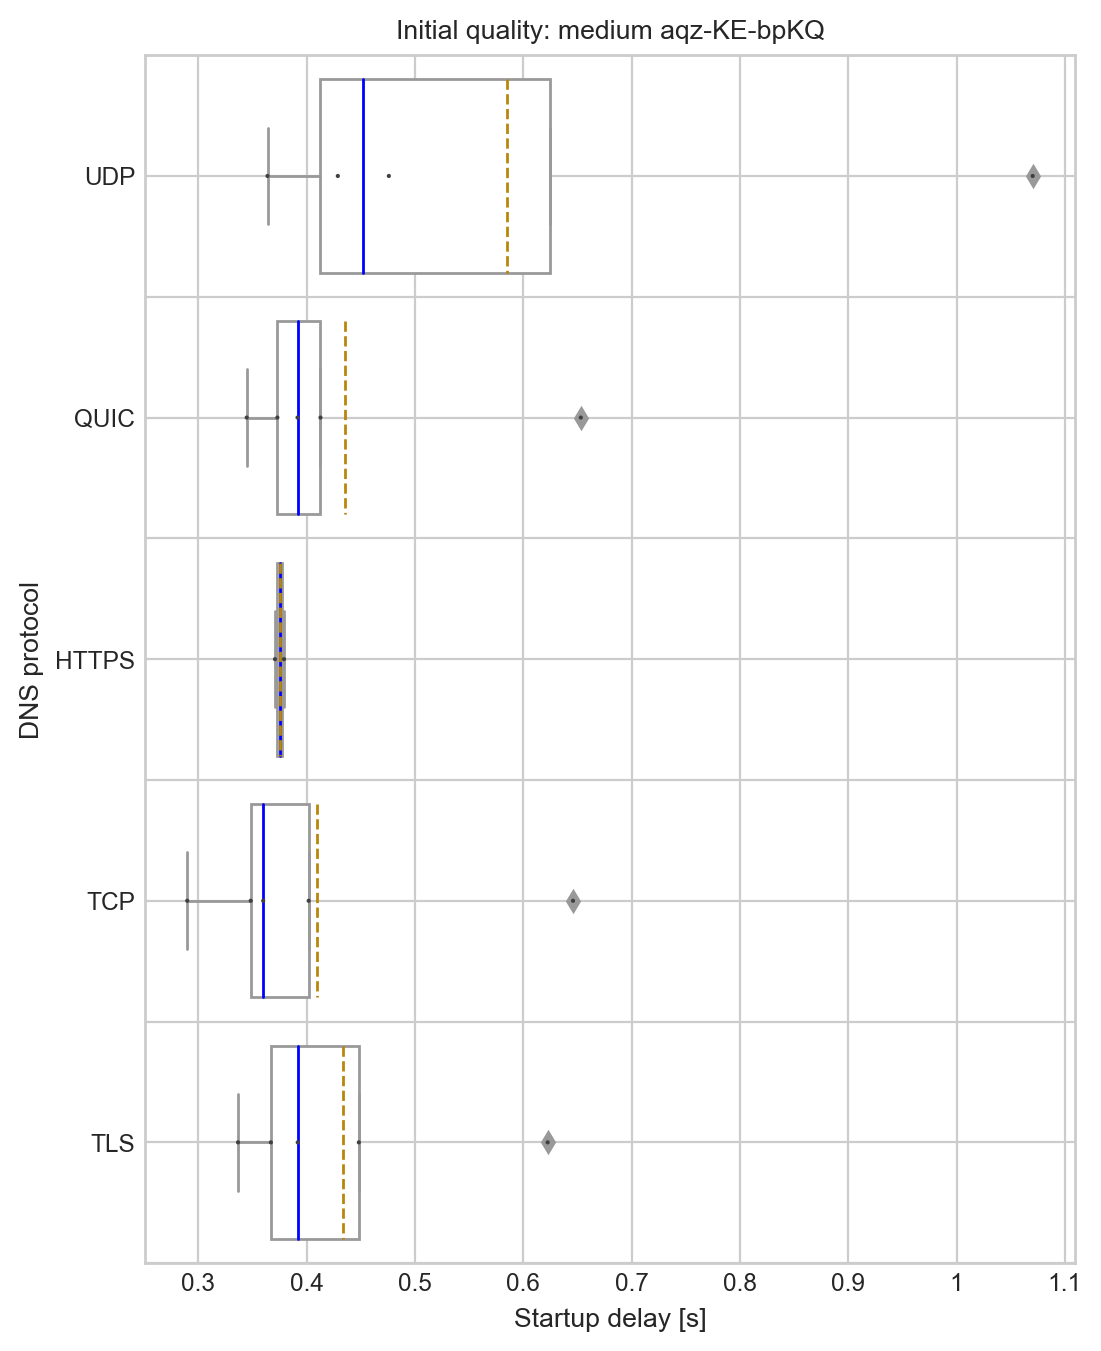

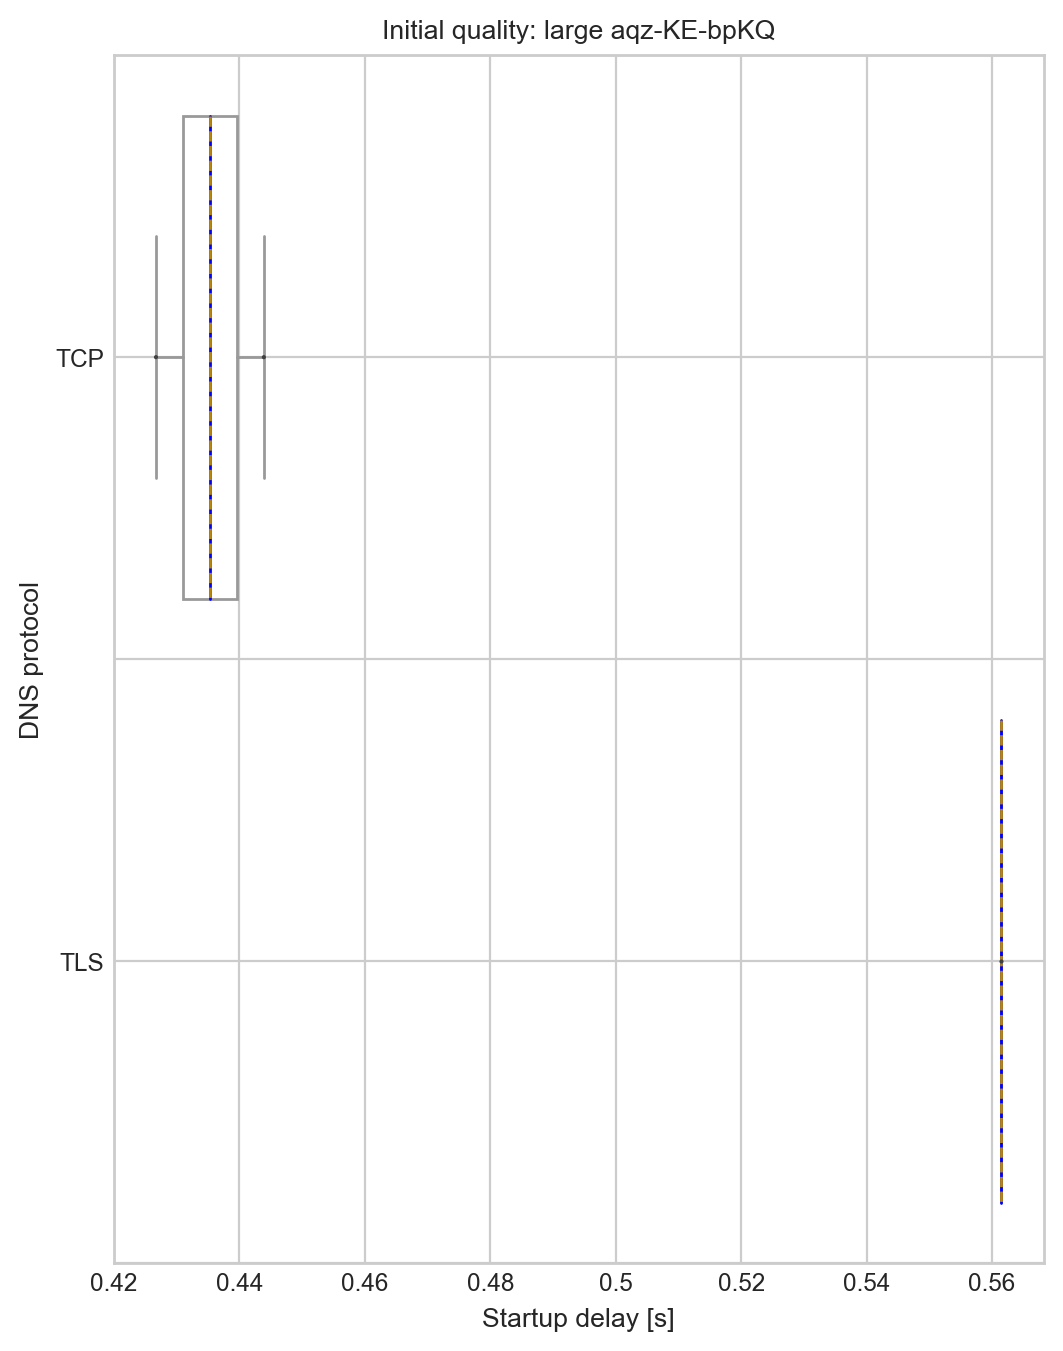

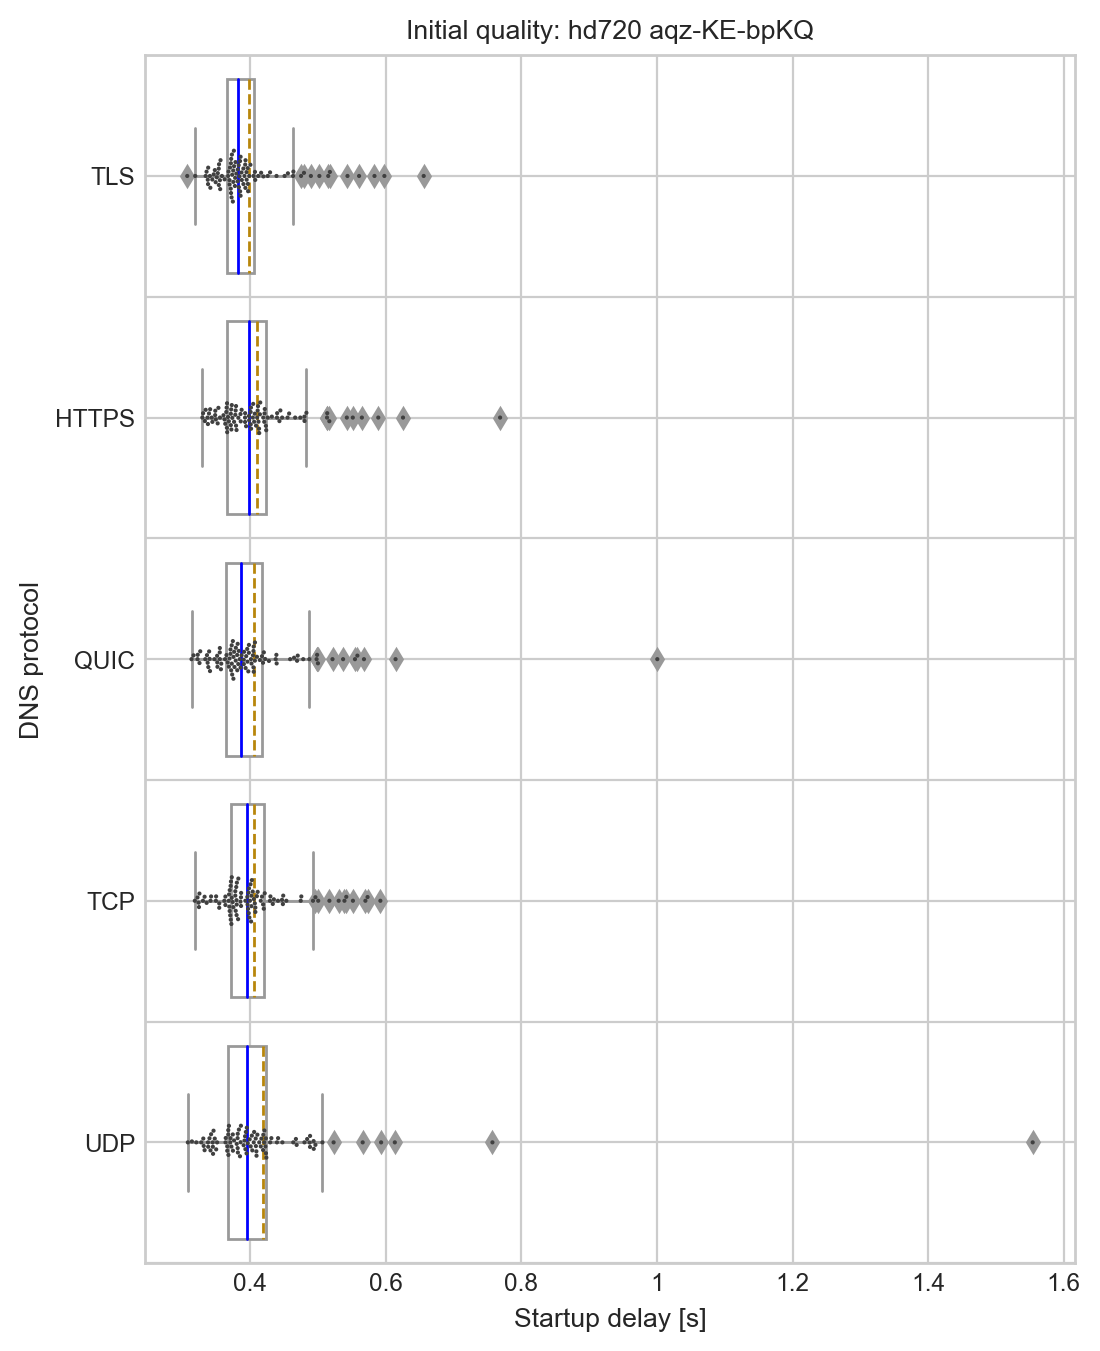

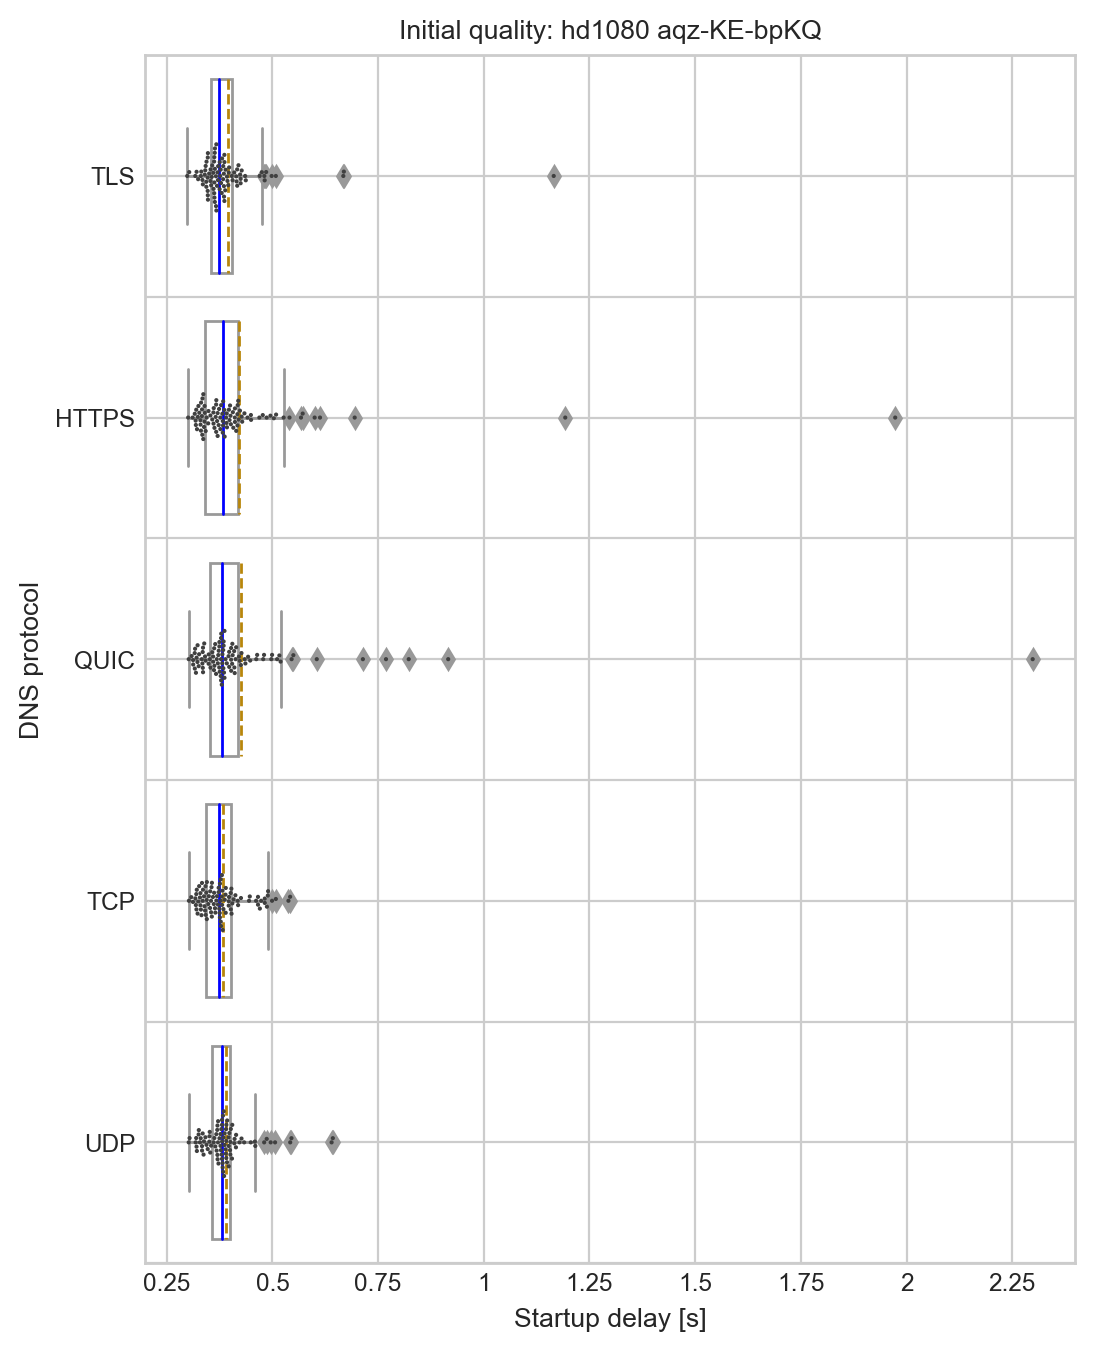

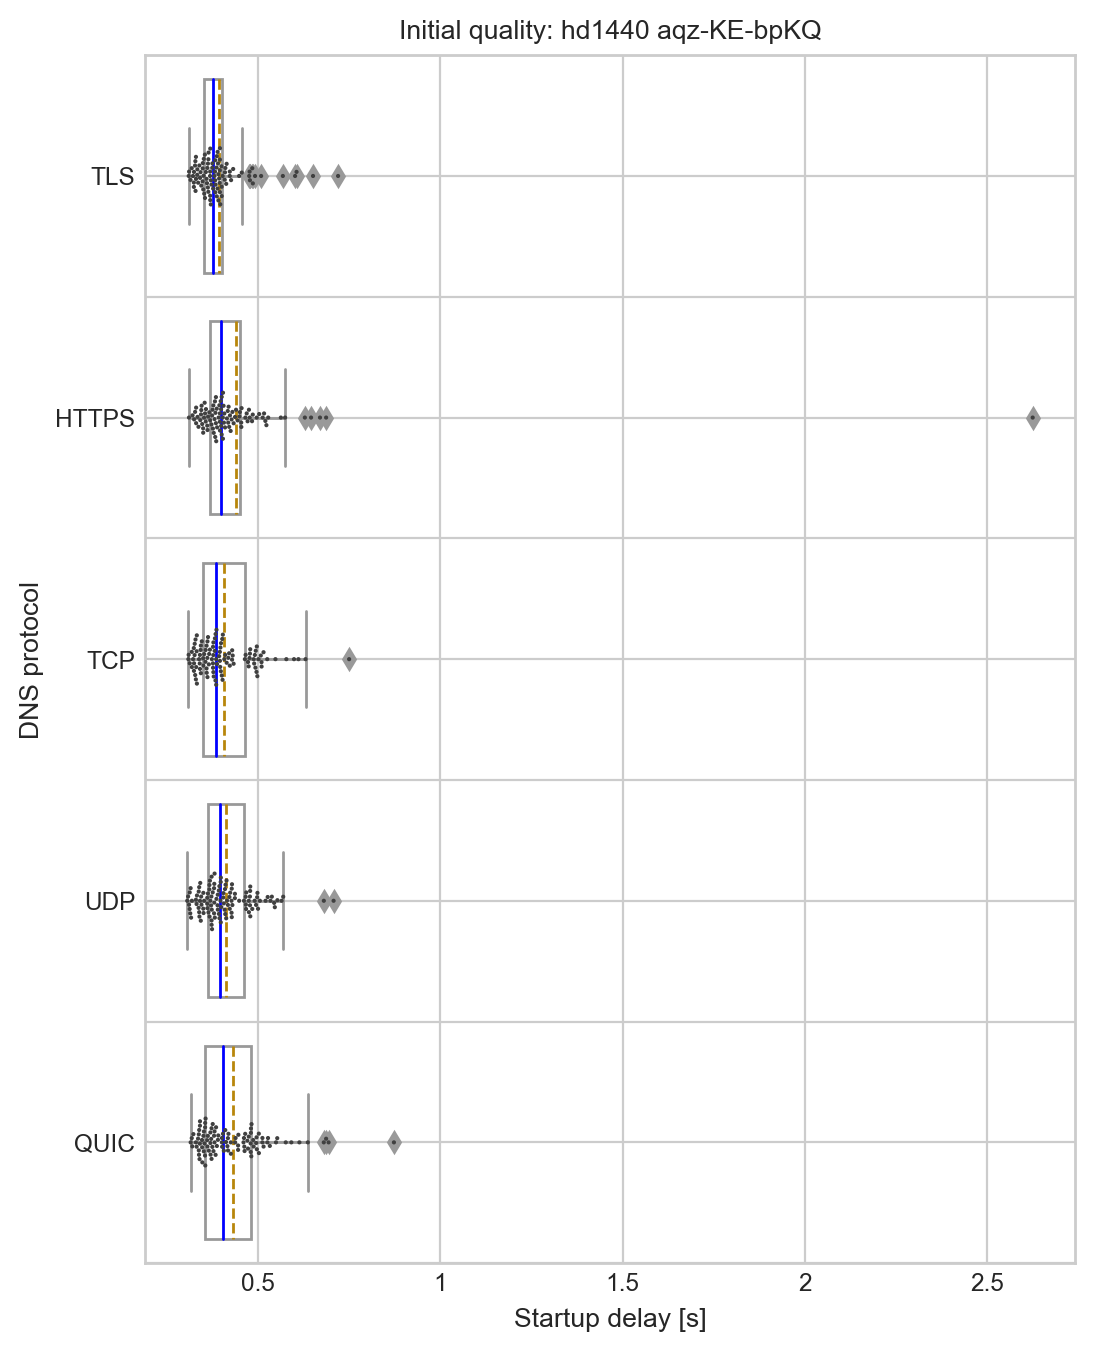

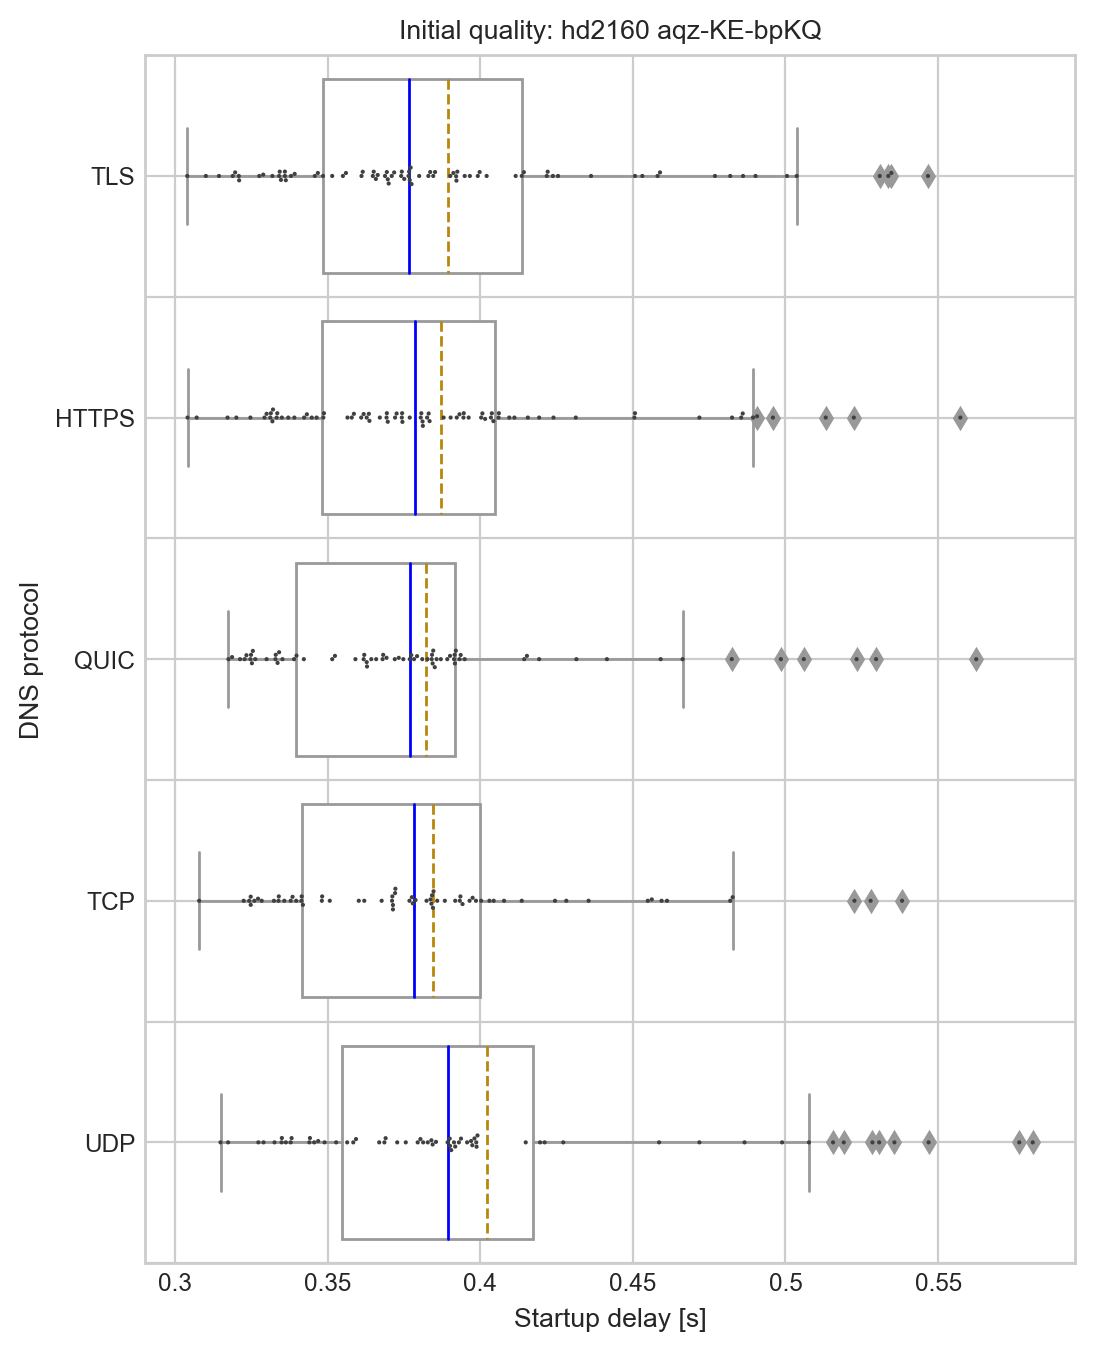

In [449]:
draw_boxplot(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0,0], "DNS protocol")


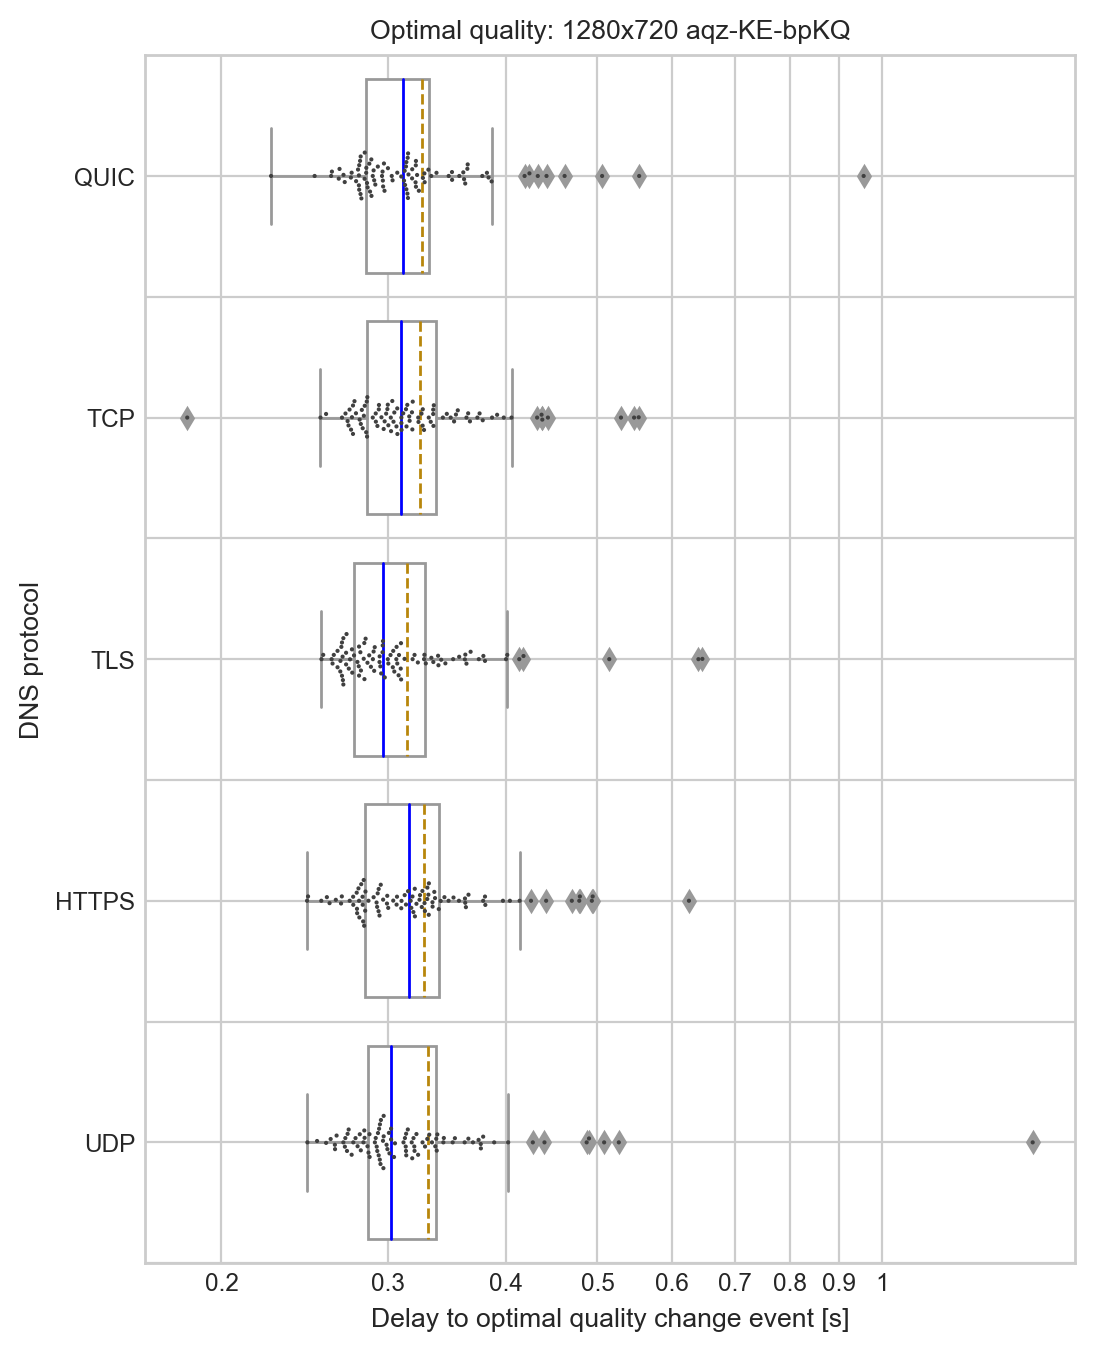

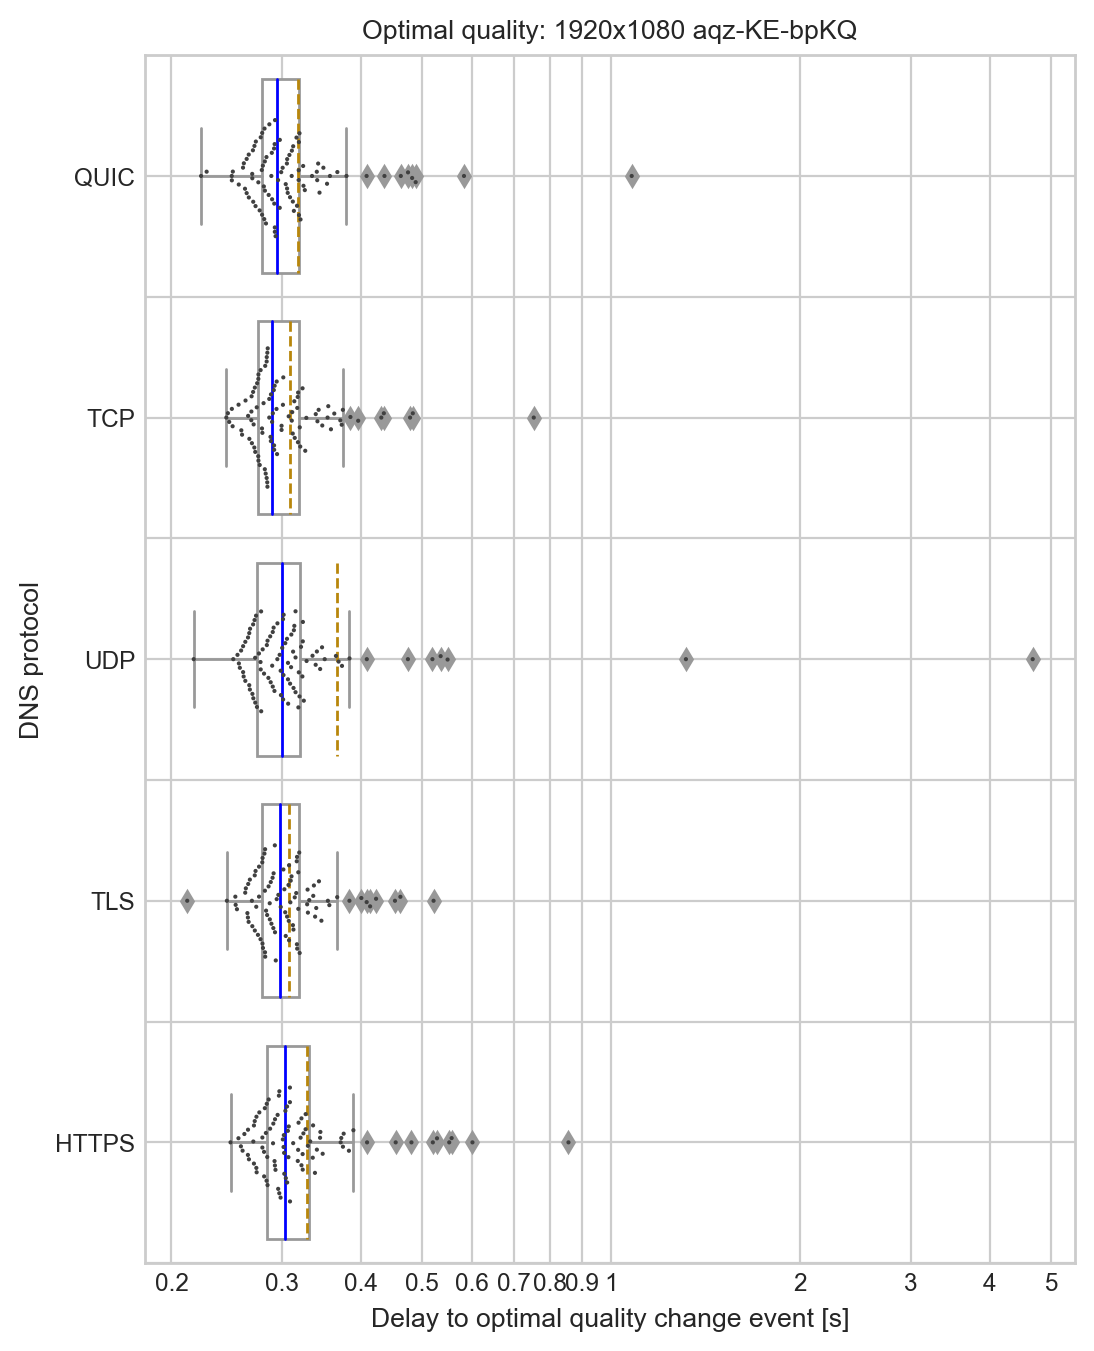

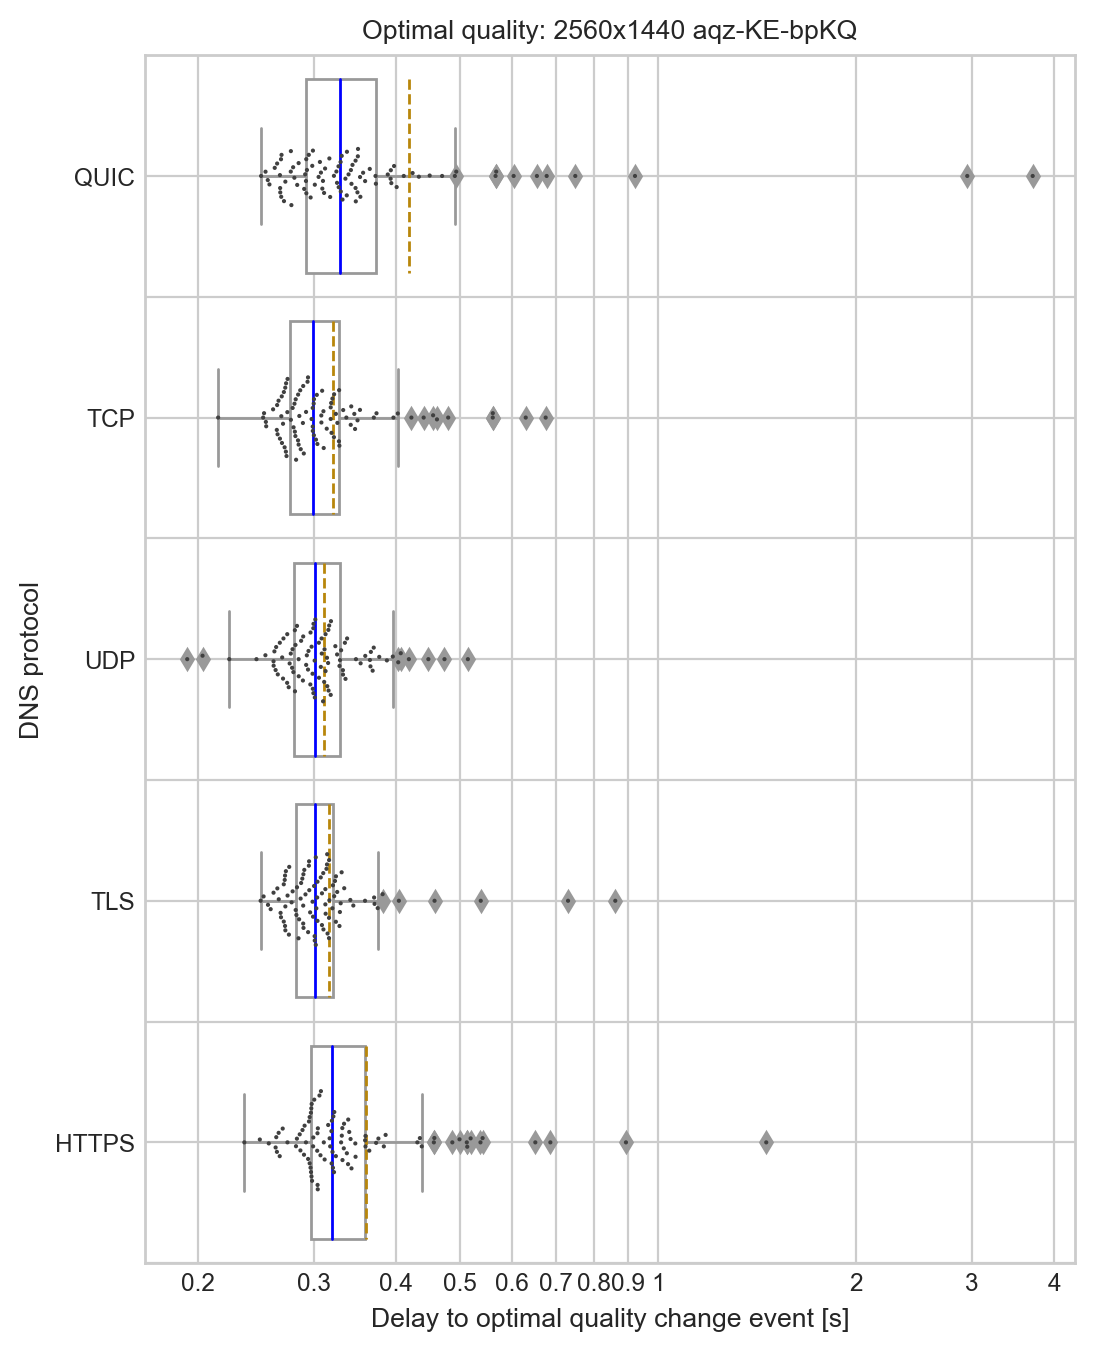

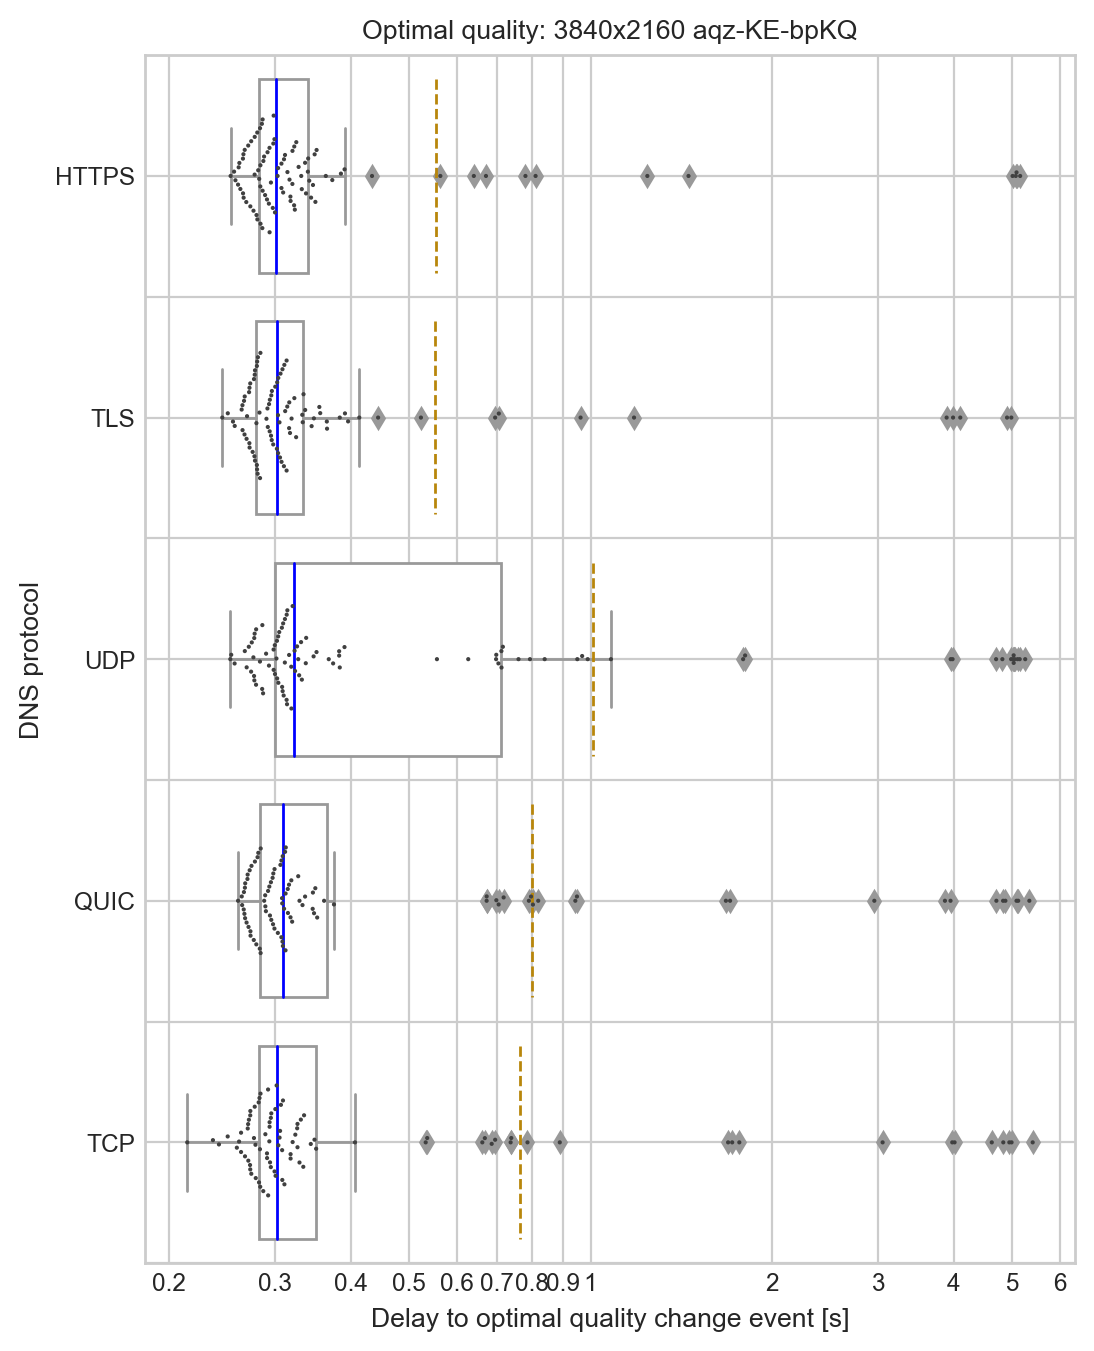

In [450]:

draw_boxplot(df_player_quality_change_event_to_opt, 'optimal_res', 'protocol', 'optimal_quality_delay', [True], 'Delay to optimal quality change event [s]', 'Optimal quality:', 'optimal-quality-delay-by-optimal-quality-and-proto', [0,0], "DNS protocol")

In [188]:
conn.close()